# Прогнозирование оттока клиентов Банка

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением F1-меры и измерить AUC-ROC, сравнивая её значение с F1-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)



### Описание данных

Признаки:
- `RowNumber` — индекс строки в данных,
- `CustomerId` — уникальный идентификатор клиента,
- `Surname` — фамилия,
- `CreditScore` — кредитный рейтинг,
- `Geography` — страна проживания,
- `Gender` — пол,
- `Age` — возраст,
- `Tenure` — сколько лет человек является клиентом банка,
- `Balance` — баланс на счёте,
- `NumOfProducts` — количество продуктов банка, используемых клиентом,
- `HasCrCard` — наличие кредитной карты,
- `IsActiveMember` — активность клиента,
- `EstimatedSalary` — предполагаемая зарплата.

Целевой признак:
- `Exited` — факт ухода клиента.

## Подготовка данных

Откроем файл, изучим его и подготовим данные для обучения модели.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score, recall_score, make_scorer
from sklearn.utils import shuffle
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from scipy.sparse import csc_matrix

import warnings
warnings.filterwarnings(action='ignore')

Random_state = 12345

In [2]:
# сделаем настройку для удобства и наглядности

# снимем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставим ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавим стиль графиков
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook') 
sns.set_style('ticks') 
sns.set_style('whitegrid')

### Изучение данных из файла

In [3]:
# загрузим датасет и сохраним его в переменную data
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [4]:
# выведем 10 случайных строк на экран
data.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3088,3089,15730448,Iroawuchi,538,Germany,Male,25,5.00,"62,482.95",1,1,1,"102,758.43",0
5026,5027,15673223,Hou,626,France,Male,44,10.00,0.00,2,0,0,"164,287.86",0
7127,7128,15808662,Krylov,624,France,Male,44,3.00,0.00,2,1,0,"88,407.51",0
3361,3362,15754952,Su,602,Germany,Female,48,7.00,"76,595.08",2,0,0,"127,095.14",0
473,474,15681705,Fanucci,785,France,Male,28,NaN,0.00,2,1,0,"77,231.27",0
1971,1972,15780954,Cran,582,Spain,Male,26,4.00,"65,848.36",2,1,0,"30,149.21",0
1099,1100,15673055,Sung,494,Spain,Male,38,NaN,0.00,2,1,1,"6,203.66",0
7239,7240,15772329,Fiorentino,580,Germany,Male,45,8.00,"103,741.14",1,1,0,"47,428.73",1
3973,3974,15669281,Ch'iu,711,Spain,Male,38,3.00,"128,718.78",1,0,0,"114,793.45",0
8825,8826,15797081,Ajuluchukwu,611,Germany,Female,49,9.00,"115,488.52",2,1,1,"138,656.81",1


In [5]:
# изучим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
# определим процент пропущенных значений в каждом столбце
data.isna().sum().sort_values(ascending=False) \
    / data.shape[0] * 100

Tenure            9.09
RowNumber         0.00
CustomerId        0.00
Surname           0.00
CreditScore       0.00
Geography         0.00
Gender            0.00
Age               0.00
Balance           0.00
NumOfProducts     0.00
HasCrCard         0.00
IsActiveMember    0.00
EstimatedSalary   0.00
Exited            0.00
dtype: float64

In [7]:
# проверим наличие дубликатов
data.duplicated().sum()

0

In [8]:
# изучим детальнее числовые признаки
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


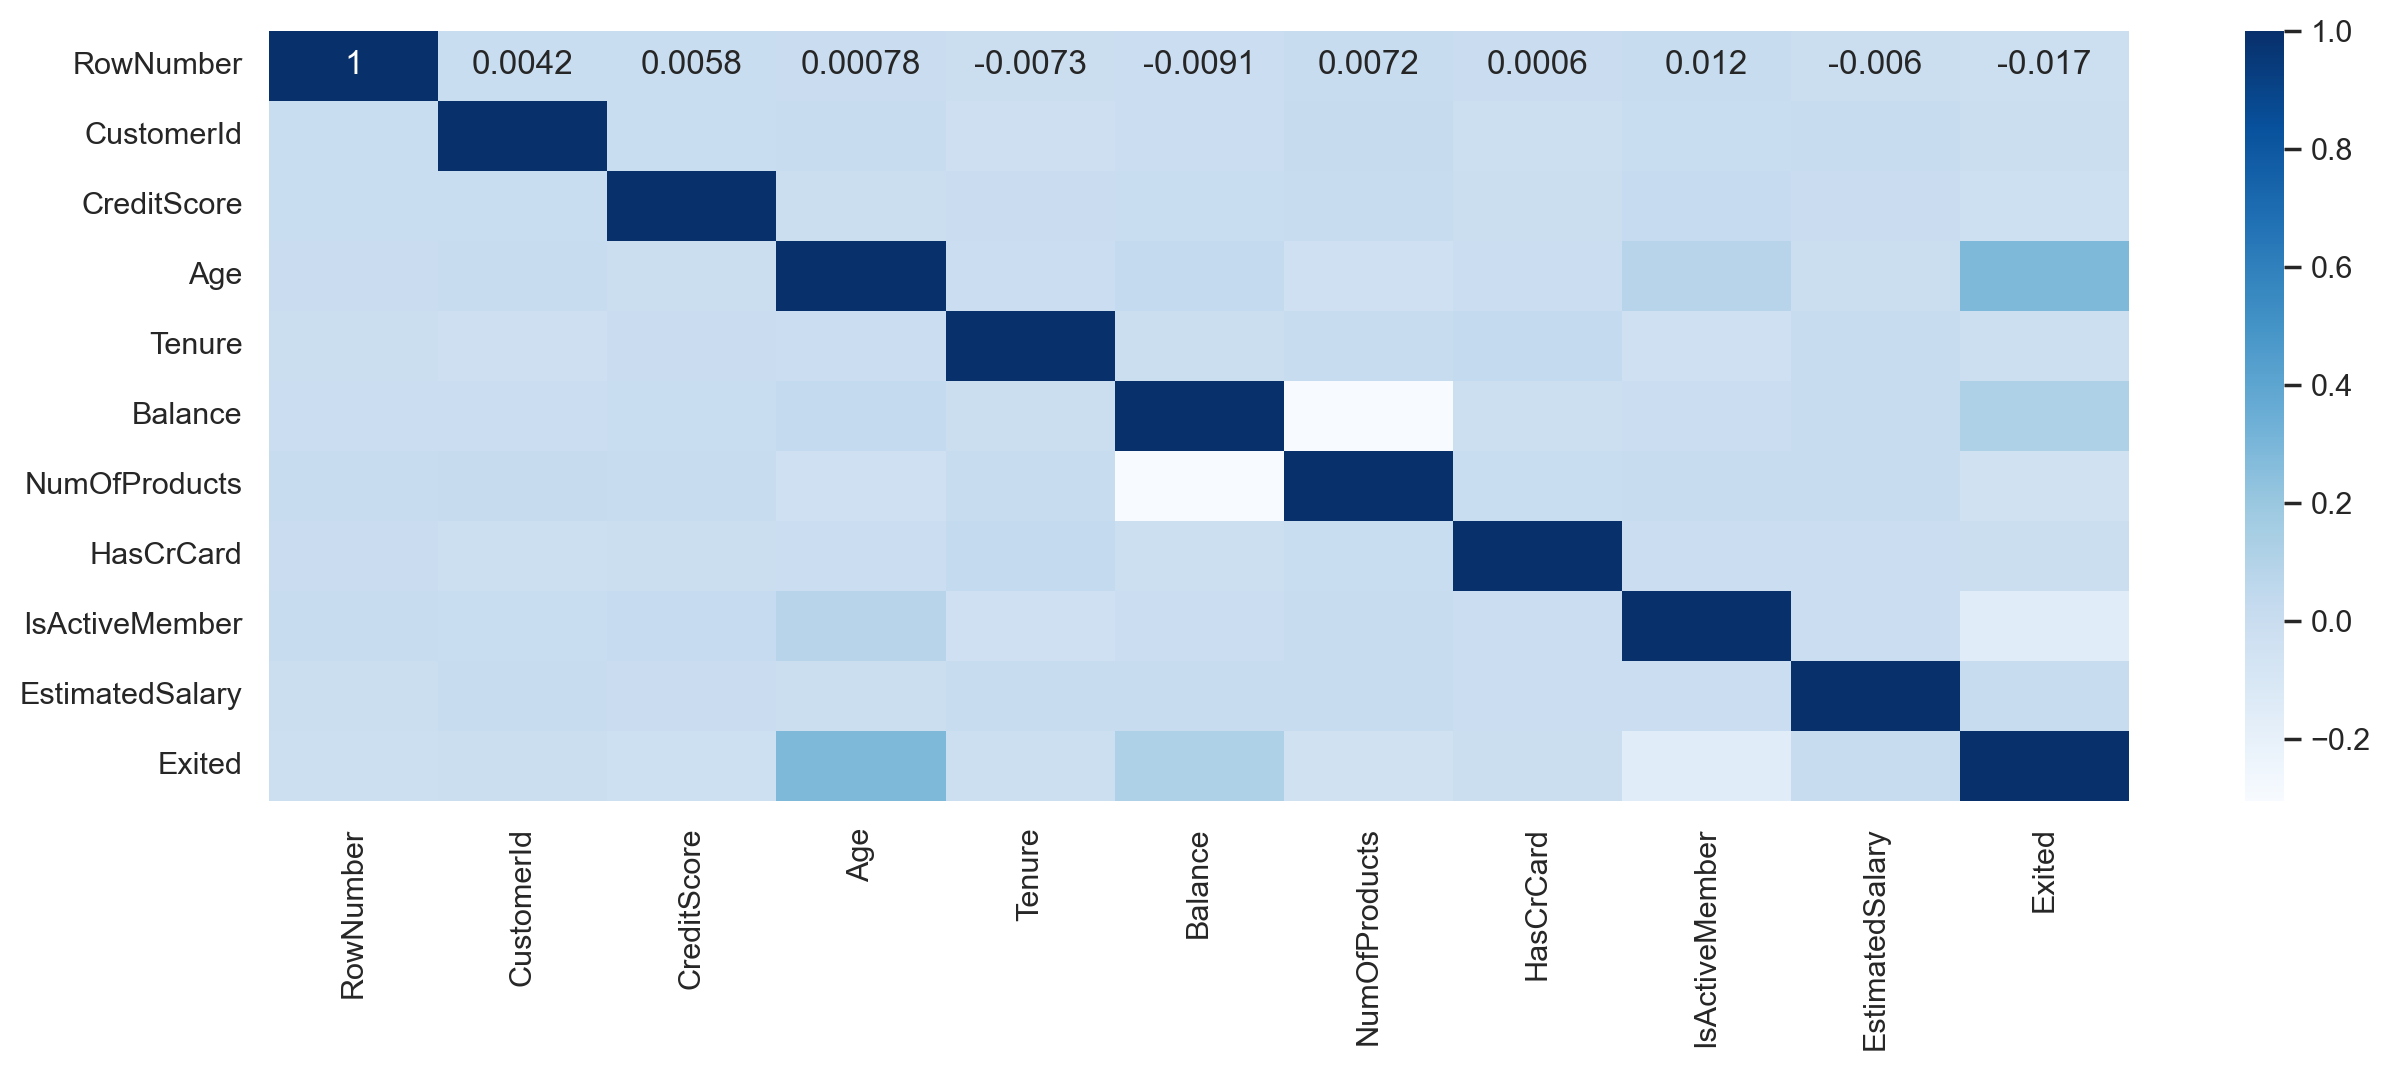

In [9]:
#проверим, нет ли мультиколлинеарности между некторыми признаками
plt.figsize=(16, 8)
correlation = data.corr(numeric_only=True)
plt.figure(figsize = (15,5))
sns.heatmap(correlation, annot = True, cmap="Blues")
plt.show()

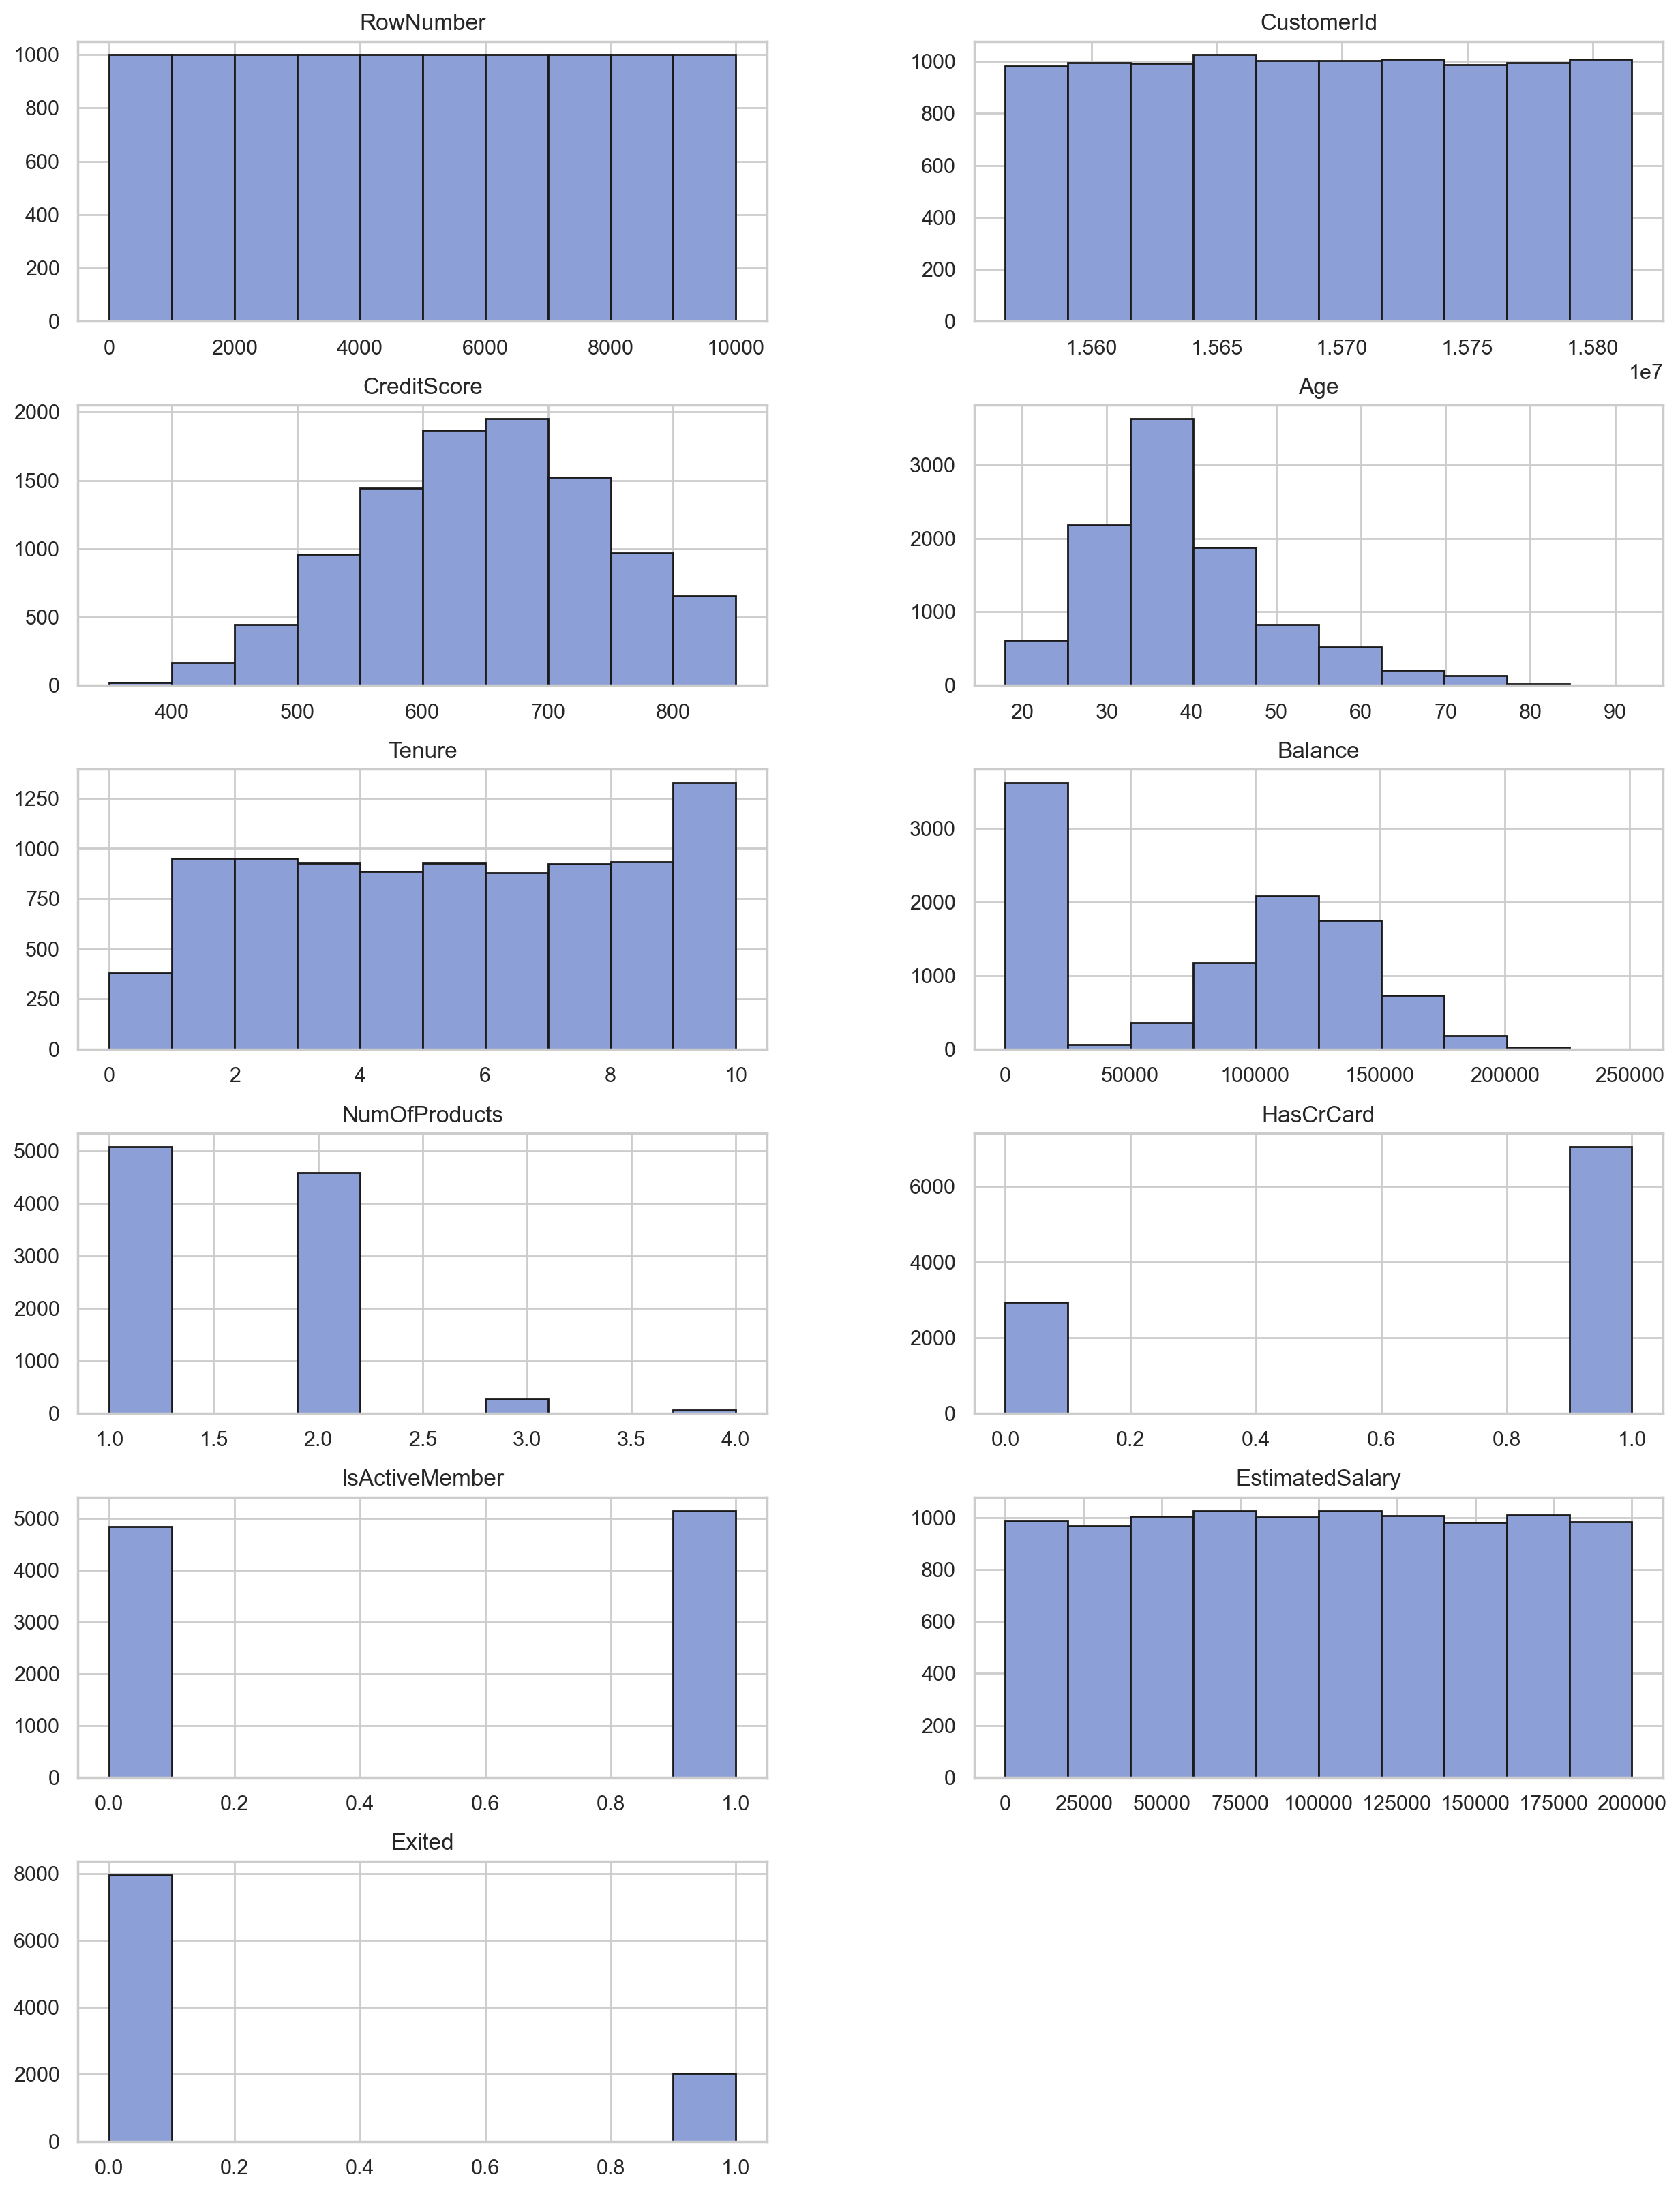

In [10]:
# проверим распределения числовых признаков
data.hist(figsize=(15, 20), layout=(6, 2), color = '#8CA0D7', ec='k')
plt.show()

**Вывод:**

- Файл содержит данные по 10000 клиентам банка, каждый из которых описывается 14-ю признаками;
- Целевой признак для нашей задачи – столбец `Exited` (факт ухода клиента из банка). Модель будет предсказывать значение `1`, если клиент собирается покинуть банк или `0`, если нет;
- Перед нами задача бинарной классификации.

### Подготовка данных для обучения модели

На этом этапе необходимо:

- Удалить столбцы, которые не несут ценности для обучения модели
- Изменить названия столбцов
- Обработать пропущенные значения
- Разделим данные на обучающую и тестовую выборки

In [11]:
# удалим столбцы,  которые не несут ценности для обучения модели, то есть не влияют на целевой признак
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.shape

(10000, 11)

In [12]:
# изменим названия столбцов
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
data.columns.tolist()

['credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

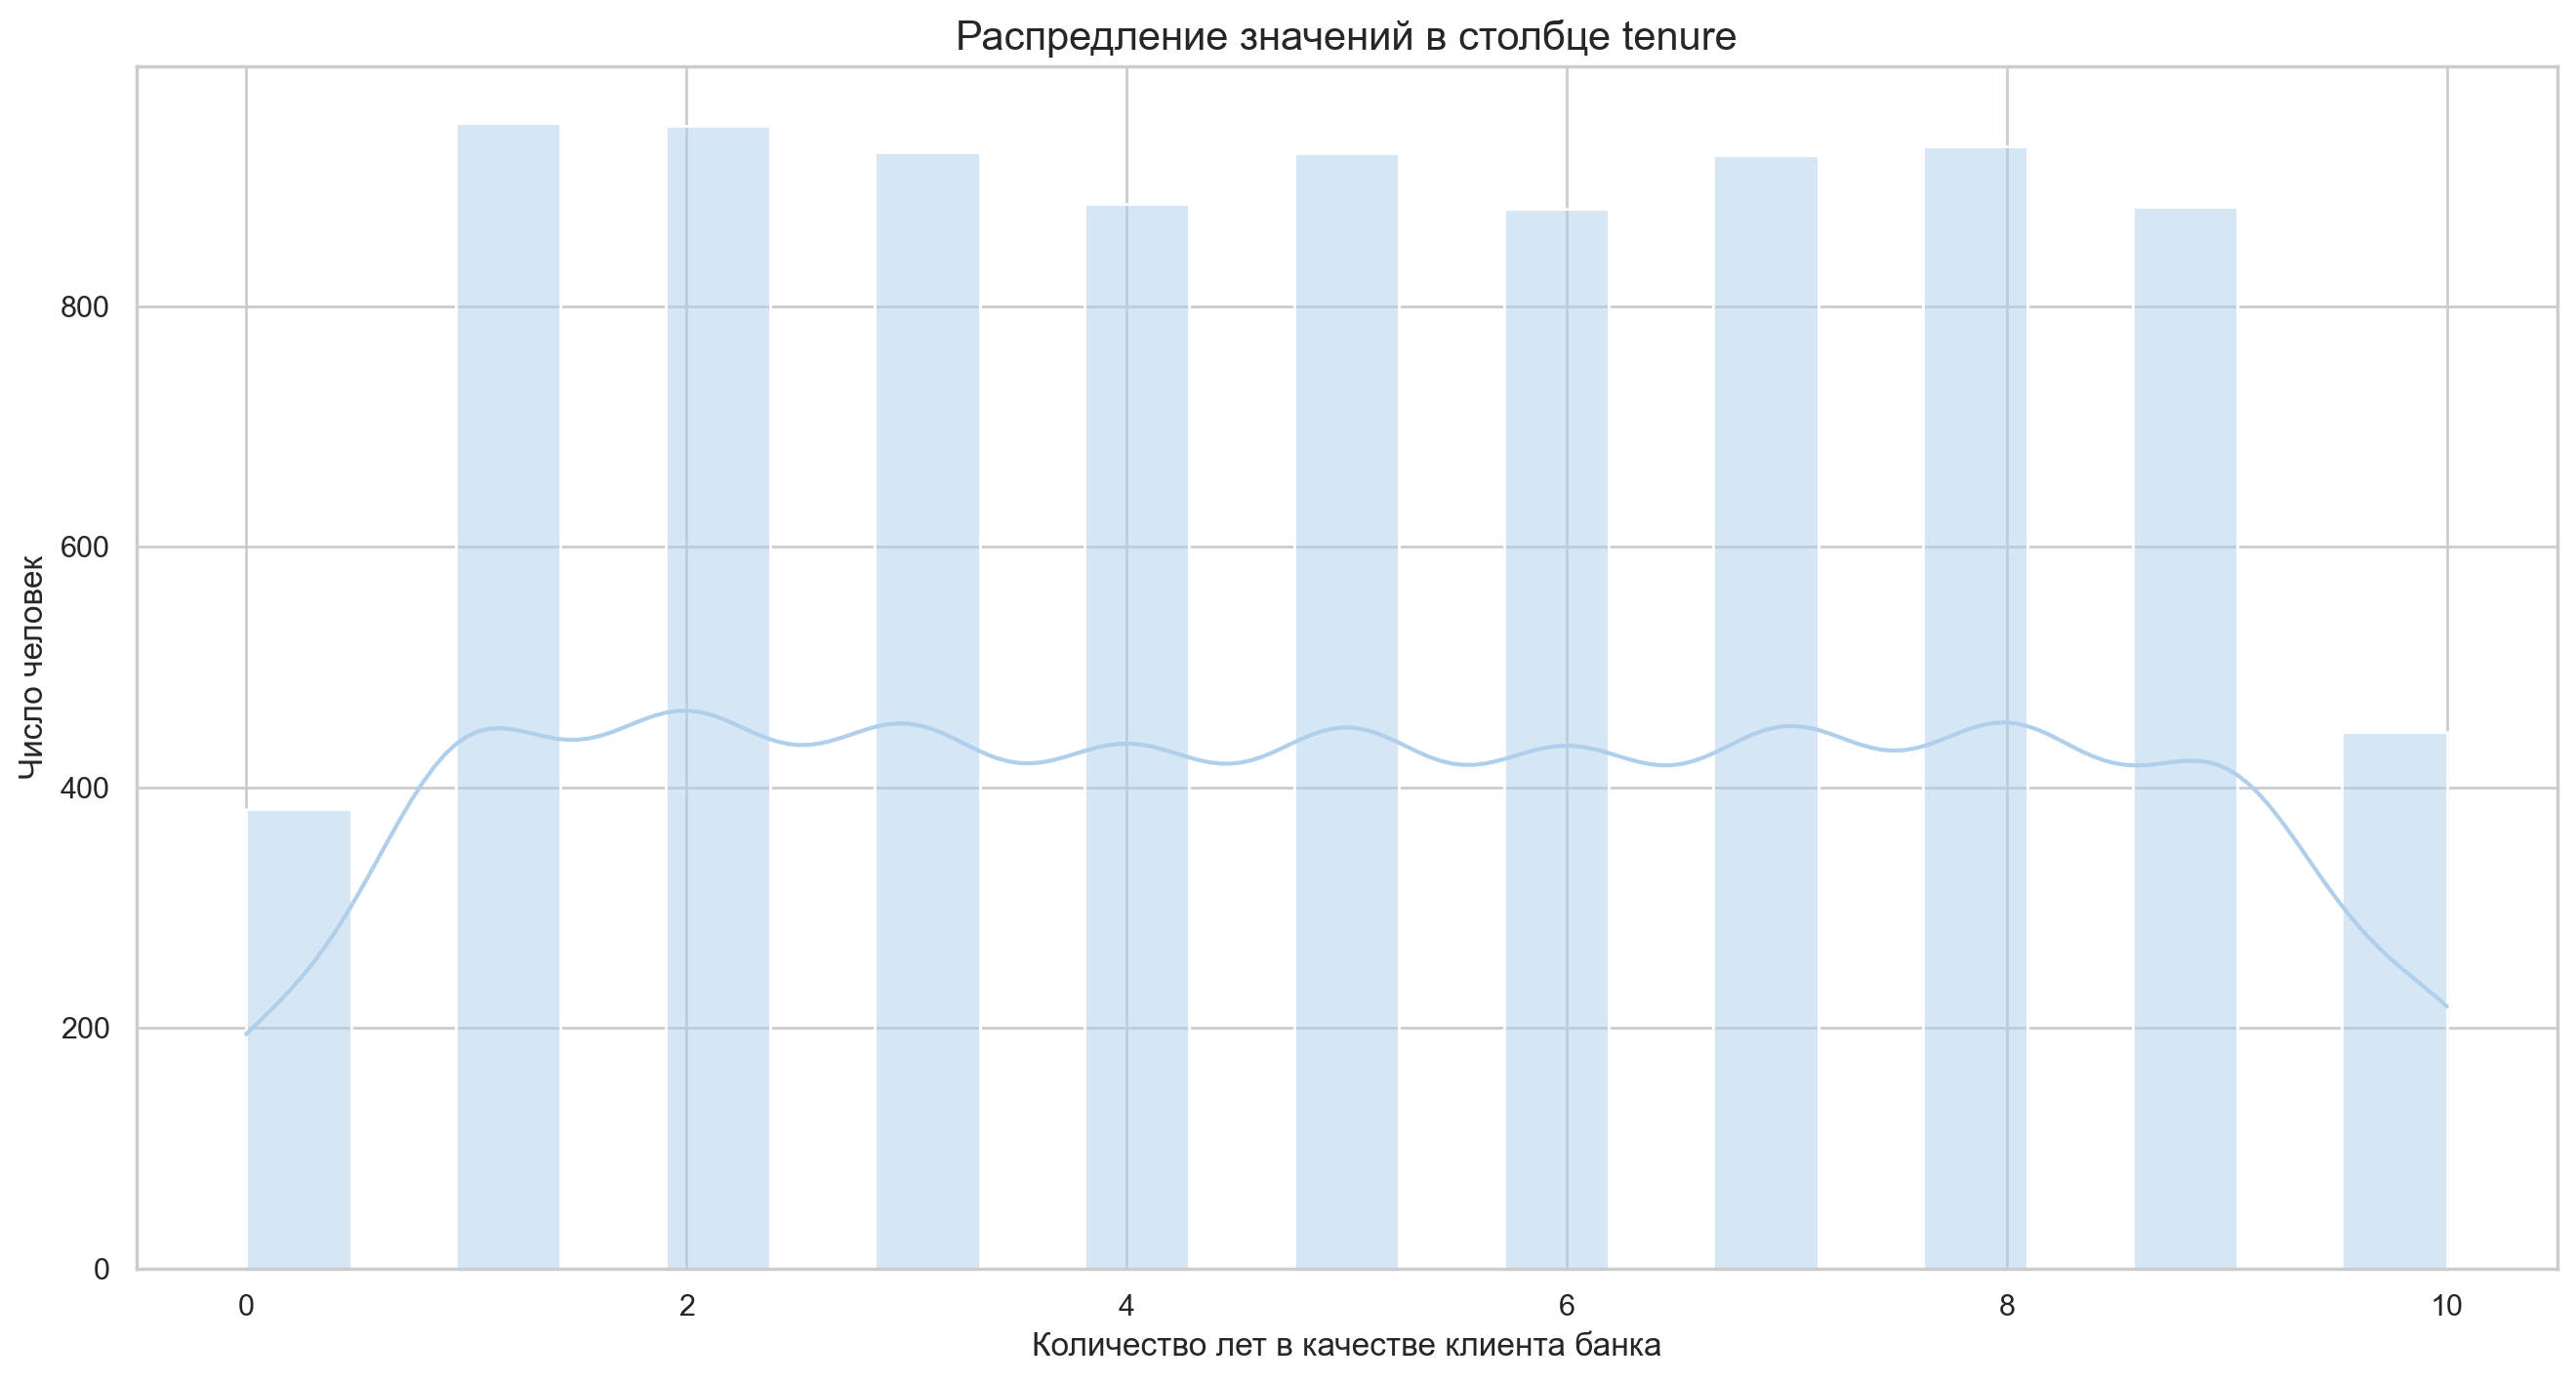

In [13]:
# построим распредление значений в столбце tenure
plt.figure(figsize=(16, 8))
sns.histplot(data.tenure, color='#AFCFEA', kde=True)
plt.title("Распредление значений в столбце tenure", fontsize=15)
plt.xlabel("Количество лет в качестве клиента банка")
plt.ylabel("Число человек")
plt.show()

In [14]:
# заполним пропущенные значения в столбце 'tenure' медианой
data.tenure = data.tenure.fillna(data.tenure.median())
data.tenure.isna().sum()

0

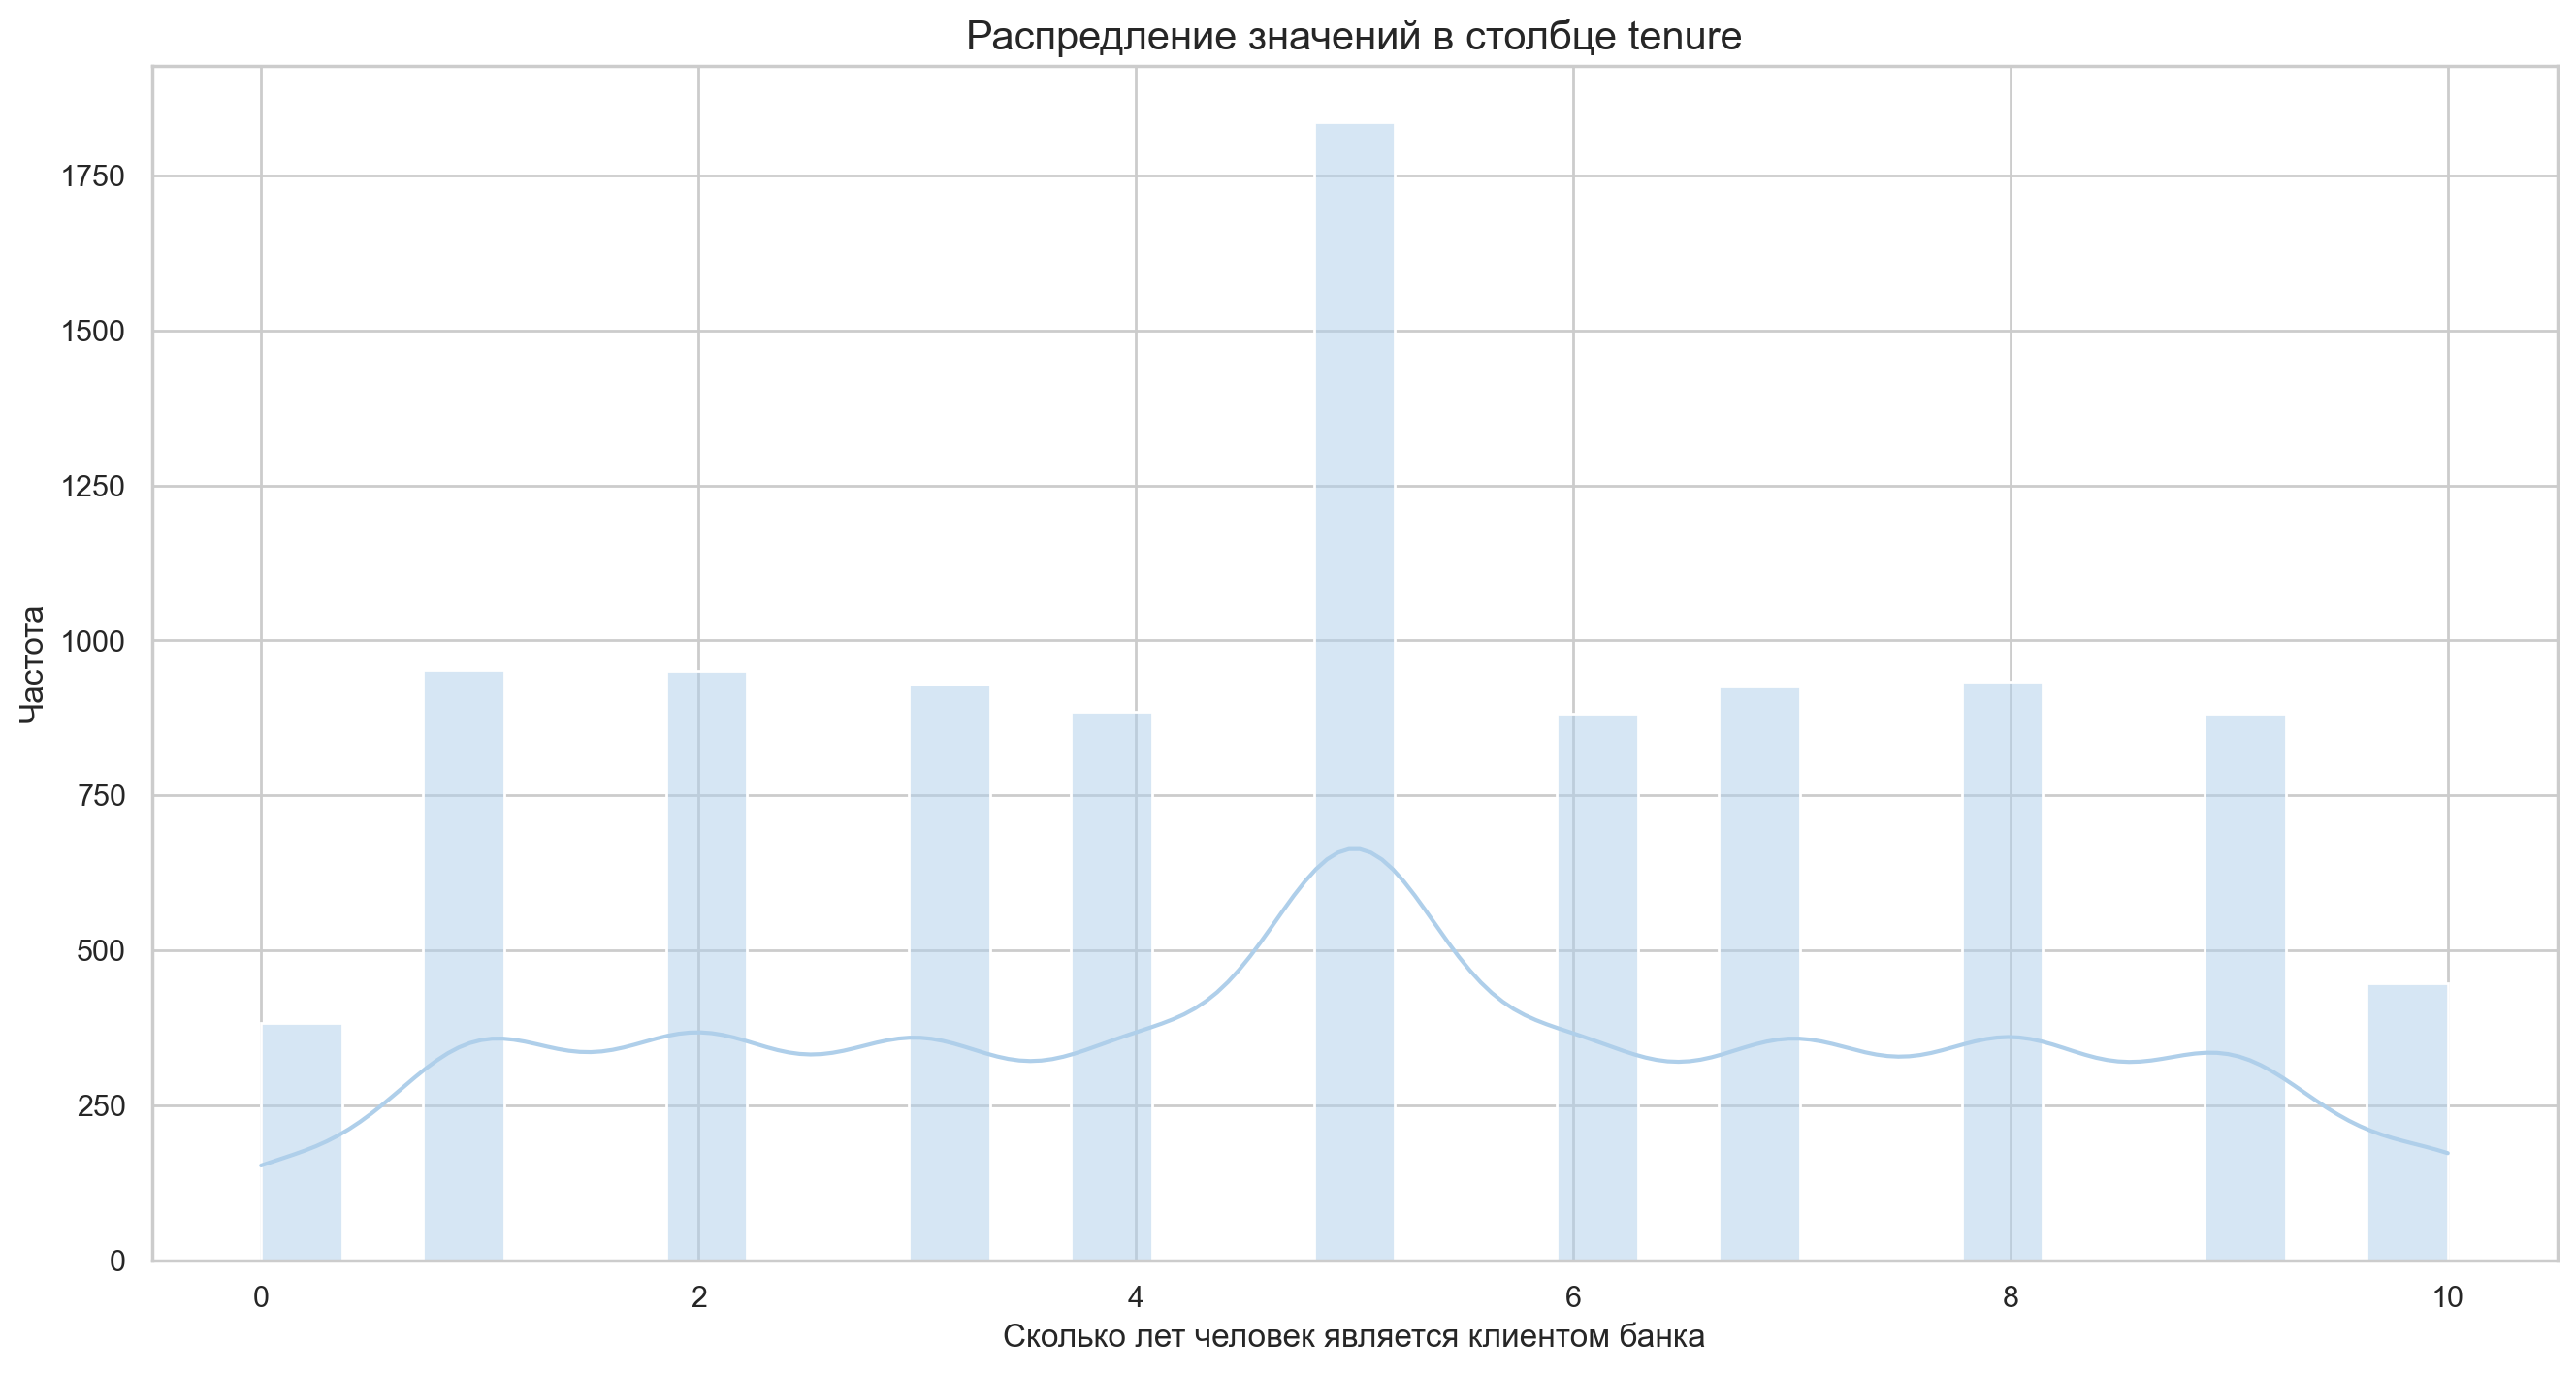

In [15]:
# еще раз построим распредление значений в столбце tenure
plt.figure(figsize=(16, 8))
sns.histplot(data.tenure, color='#AFCFEA', kde=True)
plt.title("Распредление значений в столбце tenure", fontsize=15)
plt.xlabel("Сколько лет человек является клиентом банка")
plt.ylabel("Частота")
plt.show()

In [16]:
# разделим данные и целевой признак
features = data.drop(['exited'], axis=1)
target = data['exited']
print('Размер получившихся данных:', features.shape)
print('Целевой признак:', target.shape)
features.head()

Размер получившихся данных: (10000, 10)
Целевой признак: (10000,)


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88"
1,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58"
2,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57"
3,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63"
4,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10"


In [17]:
# разделим данные на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=0.25, 
    stratify=target,
    random_state=Random_state)
    
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)
print('Размер целевого признака для обучающей выборки:', target_train.shape)
print('Размер целевого признака для тестовой выборки:', target_test.shape)

Размер обучающей выборки: (7500, 10)
Размер тестовой выборки: (2500, 10)
Размер целевого признака для обучающей выборки: (7500,)
Размер целевого признака для тестовой выборки: (2500,)


In [18]:
# выделим в отдельную переменную признаки, которые будут кодироваться и масштабироваться
cat_columns = ['geography', 'gender']
numeric_columns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

**Вывод:**

- Столбцы с индексом строки, идентификатором клиента и фамилией клиента были удалены, так как они не несут ценности для обучения модели
- Названия столбцов приведены к нижнему регистру
- Пропущенные значения в столбце 'tenure' (сколько лет человек является клиентом банка) были заменены медианой
- Исходные данные разделены на обучающую (75%) и тестовую (25%) выборки.

### Вывод по этапу "Подготовка данных": 

1. Перед нами задача бинарной классификации. Целевой признак – столбец `Exited` (факт ухода клиента из банка). Модель будет предсказывать значение `1`, если клиент собирается покинуть банк или `0`, если нет.


2. Для обучения модели будут использоваться 10 признаков.


3. Исходные данные разделены на обучающую и тестовую выборки. После разбивки данных получаем:
    - Обучающая выборка - 75% всех данных,
    - Тестовая выборка - 25% всех данных.

## Исследование задачи

Исследуем баланс классов и обучим модели без учёта дисбаланса. Для исследования будем использовать следующие модели:
   - Дерево решений / Decision Tree
   - Случайный лес / Random Forest
   - Логистическая регрессия / Logistic Regression

In [19]:
# создадим функцию для построения матрицы ошибок и ROC кривой
def matrix_roc_auc(model, features):
    predictions = model.predict(features)
    matrix = confusion_matrix(target_train, predictions)

    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues_r")
    plt.title('Матрица ошибок', fontsize=14)
    plt.xlabel('Предсказания', fontsize=12)
    plt.ylabel('Ответы', fontsize=12)
    
    plt.subplot(1, 2, 2)
    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_train, probabilities_one_valid) 
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0])
    plt.xlabel("Доля ложноположительных ответов", fontsize=12) 
    plt.ylabel("Доля истинно положительных ответов", fontsize=12)
    plt.title("ROC-кривая", fontsize=14)
    
    plt.show()

In [20]:
# функция для построения графика важности признаков
def feature_importance(data_impotance, fi_yerr, name=' '):
    plt.figure(figsize=(16, 6))
    data_impotance.plot.bar(yerr=fi_yerr, color='#48BDE1')
    plt.title(f'Важность признаков для модели {name}', fontsize=14)
    plt.ylabel('Важность признака', fontsize=12)
    plt.show()

### Исследование баланса классов

In [21]:
# определим долю ушедших клиентов банка
data['exited'].mean()

0.2037

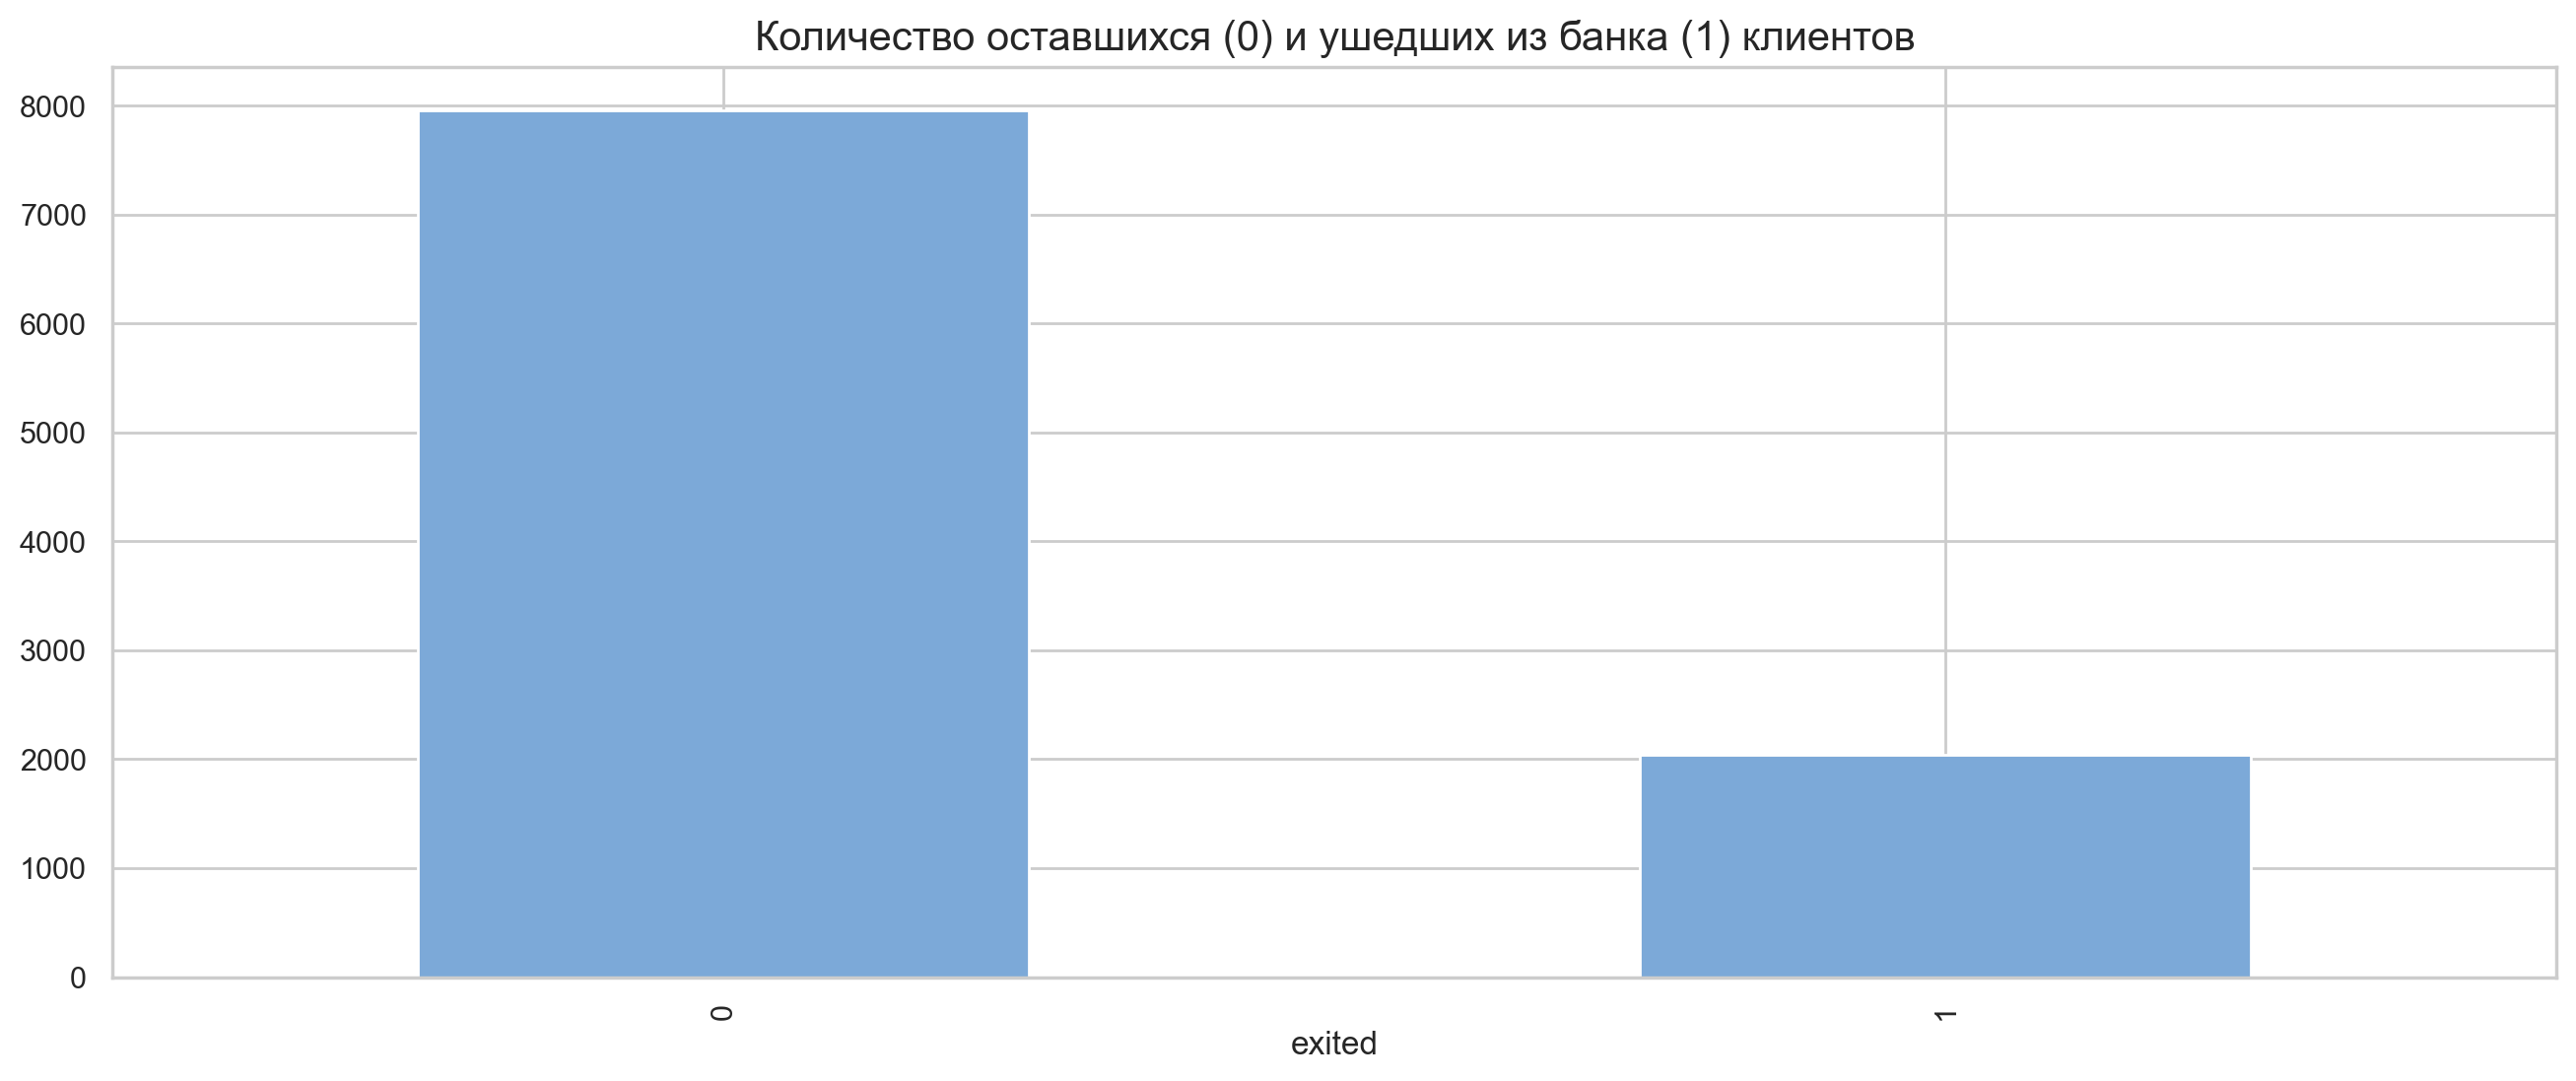

In [22]:
# построим распределение
plt.figure(figsize=(16, 6))
data['exited'].value_counts().plot(kind='bar', color='#7ca9d8', grid=True)
plt.title("Количество оставшихся (0) и ушедших из банка (1) клиентов", fontsize=15)
plt.show()

**Вывод:**

В данных наблюдается дисбаланс классов. Количество оставшихся в банке клиентов превышает количество ушедших клиентов в 4 раза.

### Дерево решений / Decision Tree. Обучение модели без учета дисбаланса классов

- Для перебора различных гиперпараметров Decision Tree будем использовать Grid Search CV
- Используем пайплайны, это предотвратит возможность утечки на кросс-валидации
- Обучим модель с наилучшими параметрами и оценим ее качество с помощью кроссвалидации, используя метрики F1 и AUC-ROC
- Построим матрицу ошибок и ROC кривую

In [23]:
# для кодирования и масштабирования признаков применим make_column_transformer
col_transformer_tree = make_column_transformer(
    (OrdinalEncoder(), cat_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [24]:
# применим make_column_transformer к обучающим данным
features_train_tree = col_transformer_tree.fit_transform(features_train)
features_train_tree = csc_matrix(features_train_tree)
features_train_tree = pd.DataFrame.sparse.from_spmatrix(
    features_train_tree, 
    columns=col_transformer_tree.get_feature_names_out()
)

features_train_tree.head()

,geography,gender,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.15,0.58,-0.00,1.26,0.81,-0.85,1.00,0.00
1,0.00,0.00,-0.10,2.69,-0.73,-1.22,-0.92,-1.00,0.00,1.00
2,0.00,0.00,-0.04,-0.86,-0.00,-1.22,0.81,-1.51,1.00,0.00
3,0.00,1.00,0.84,-0.28,-0.00,-1.22,0.81,1.06,1.00,0.00
4,0.00,1.00,1.45,-0.28,0.36,0.56,-0.92,1.55,1.00,1.00


In [25]:
# переберем различные гиперпараметры DecisionTreeClassifier с помощью Grid Search CV. Найдем лучшие
model_tree = DecisionTreeClassifier(random_state=Random_state)
pipeline_tree = make_pipeline(col_transformer_tree, model_tree)

param_grid_tree = {
    'decisiontreeclassifier__max_depth': [None] + [i for i in range(2, 7)],
    'decisiontreeclassifier__random_state': [Random_state],
}

gs_tree_pl = GridSearchCV (
    pipeline_tree, 
    param_grid_tree, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_tree_pl.fit(features_train, target_train)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_tree_pl.cv_results_)[metrics].iloc[gs_tree_pl.best_index_]
f1_tree = results[0]
roc_auc_tree = results[1]
best_model_tree = gs_tree_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_tree, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_tree, 3)}')
print(f'Лучшие параметры: {gs_tree_pl.best_params_}')

Среднее значение F1-меры: 0.536
Среднее значение AUC-ROC: 0.827
Лучшие параметры: {'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__random_state': 12345}


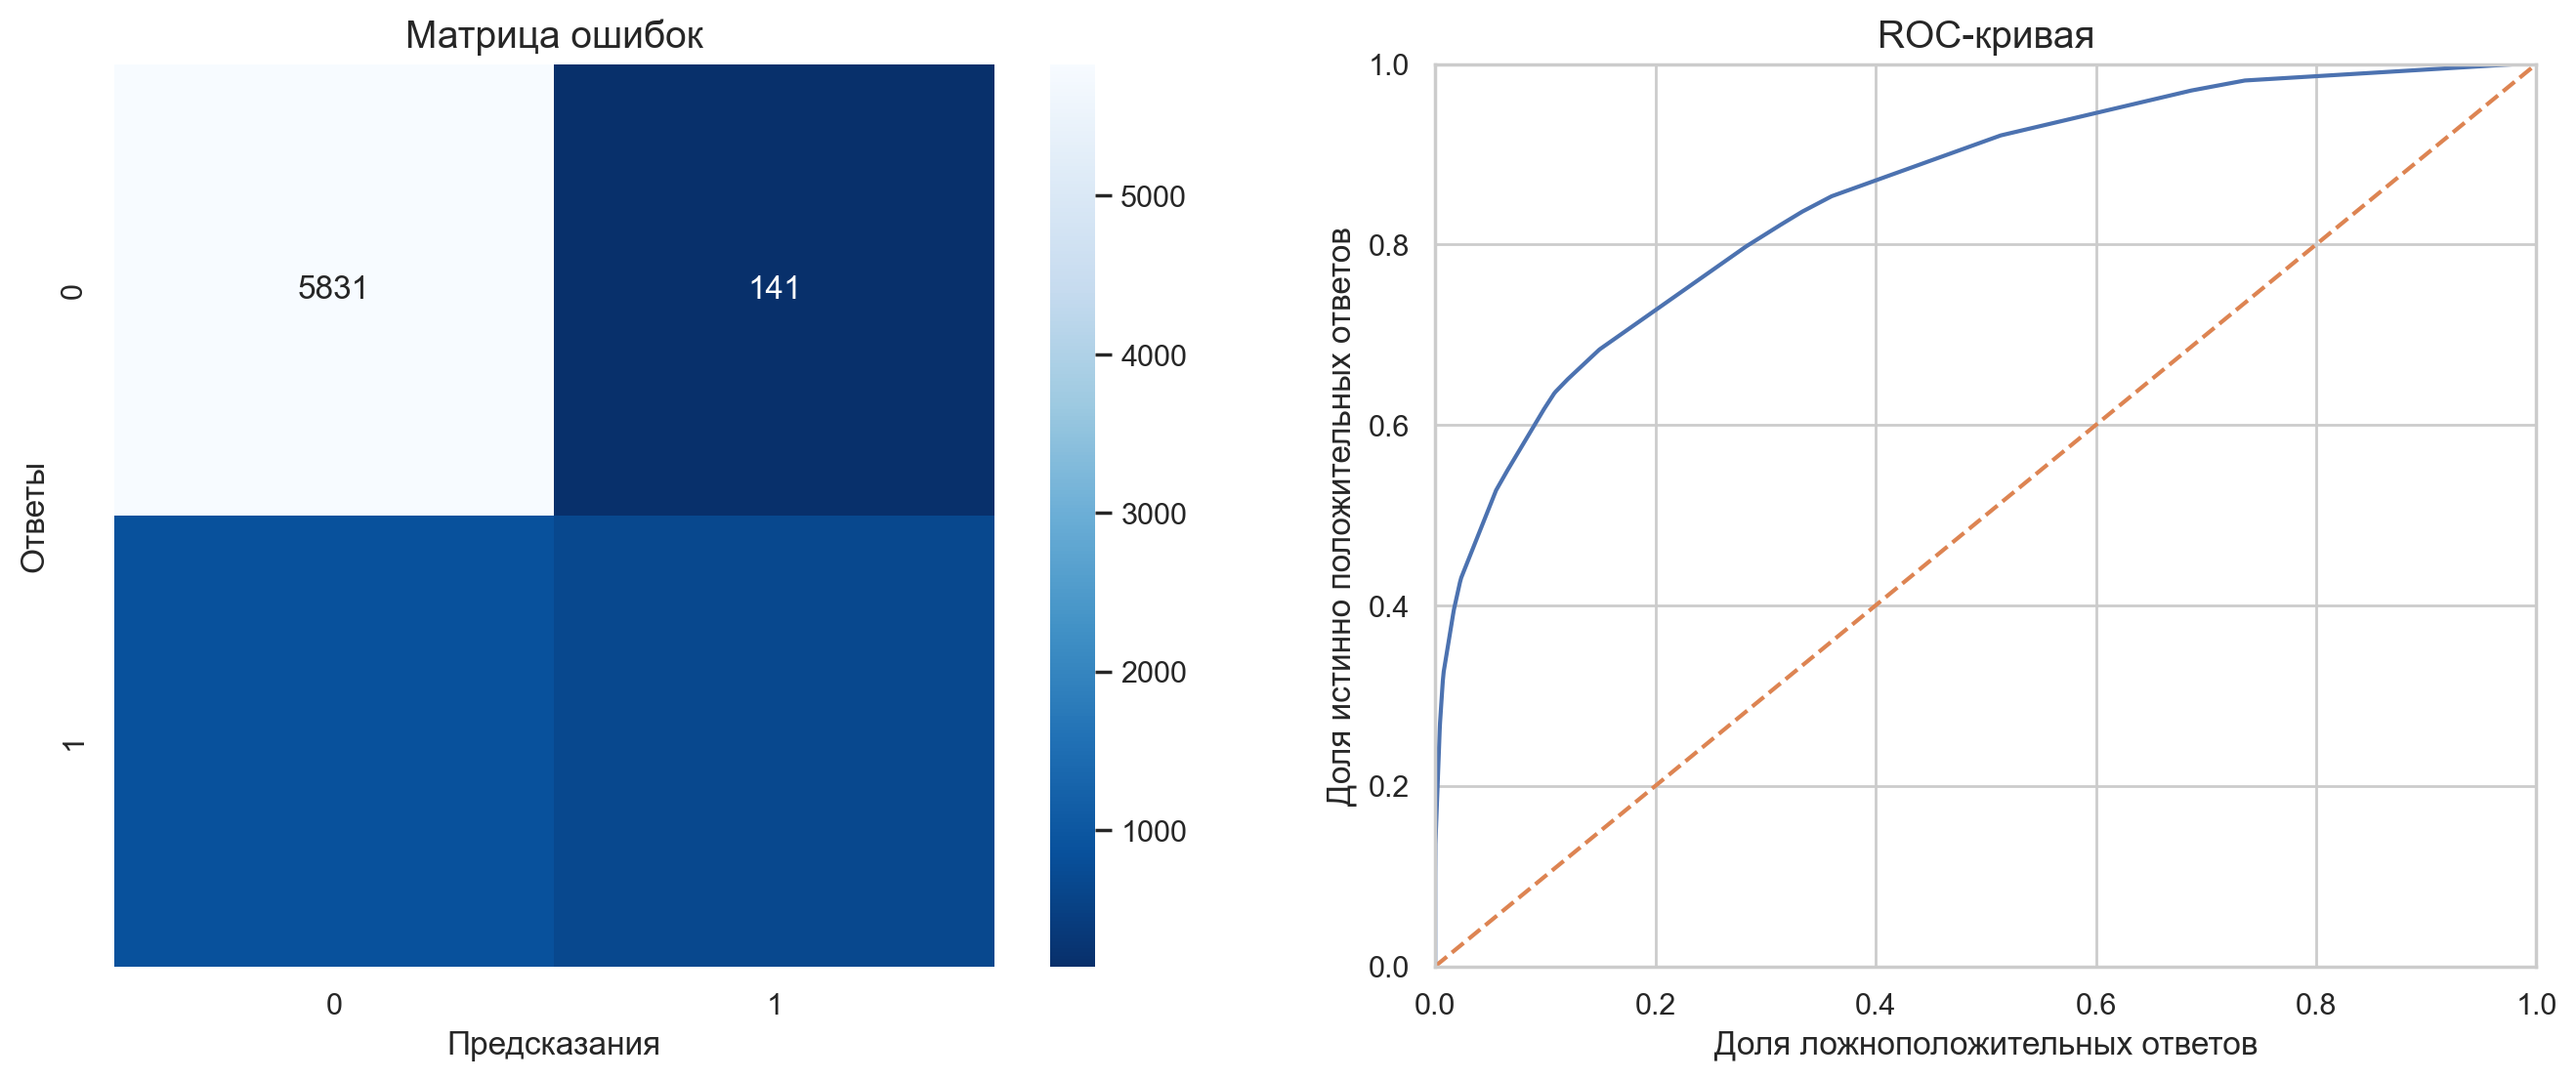

In [26]:
# построим матрицу ошибок и ROC-кривую
matrix_roc_auc(best_model_tree, features_train)

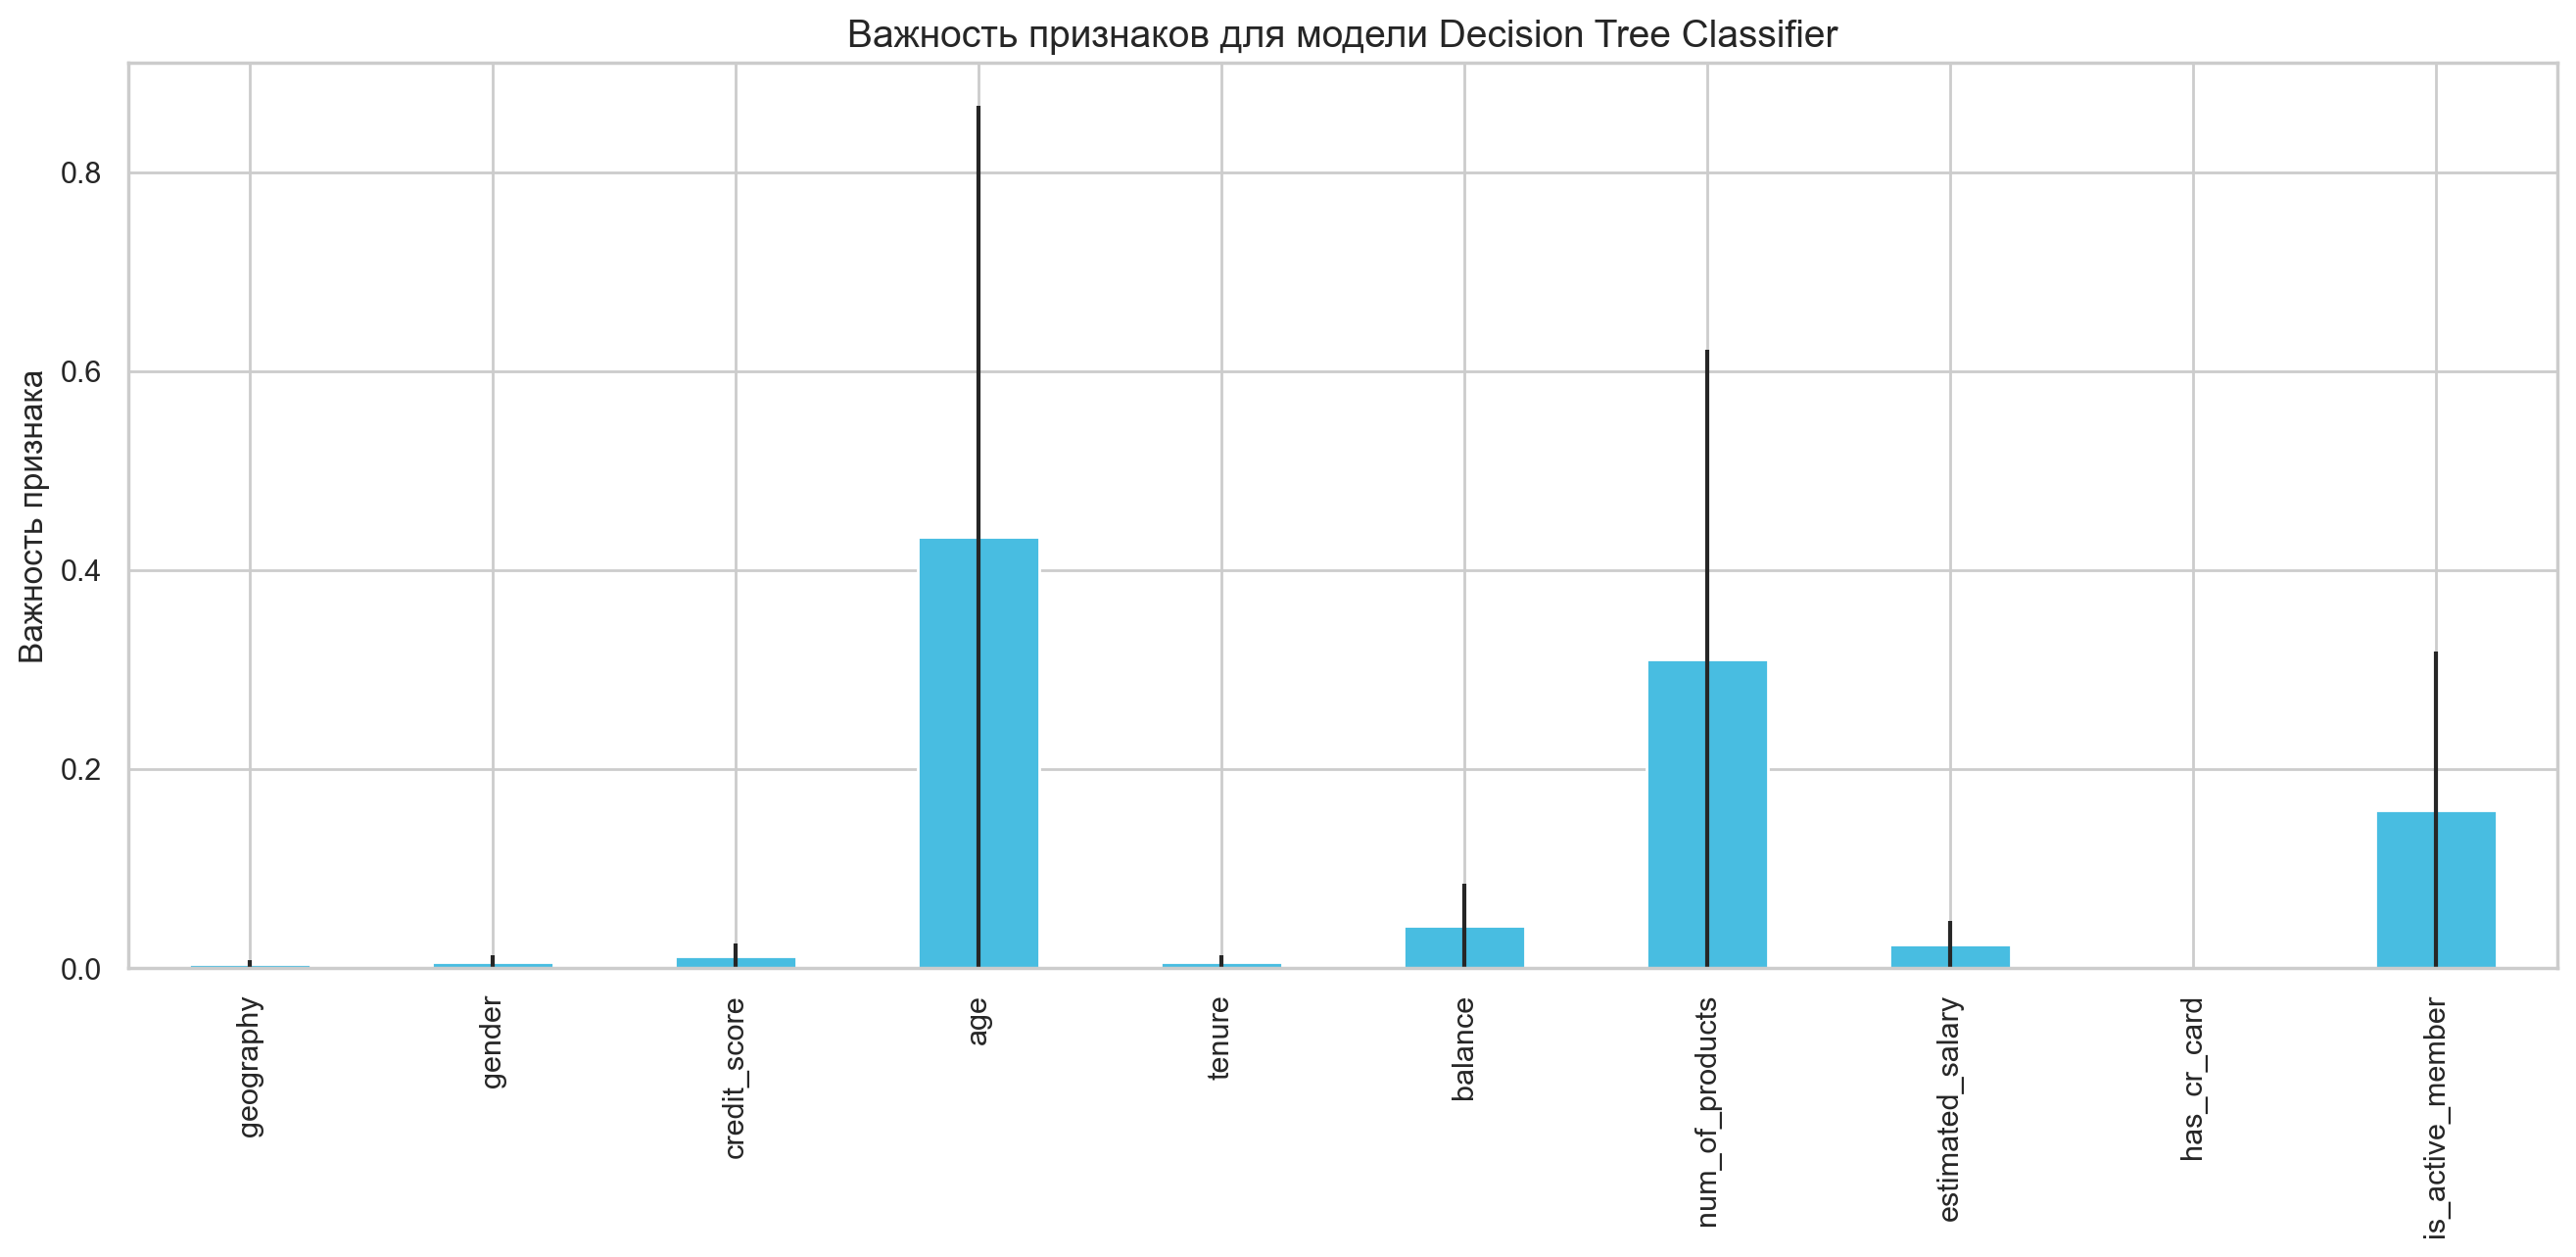

In [27]:
# построим график важности признаков
coef_tree = best_model_tree[1].feature_importances_
tree_importances = pd.Series(coef_tree, index=features_train_tree.columns)
feature_importance(tree_importances, tree_importances, name='Decision Tree Classifier')

**Вывод:**

- После проверки моделей на несбалансированной выборке видим, что дерево решений имеет самую высокое значение F1-меры 0.54, когда задан гиперпараметр глубины дерева равный 6;
- На матрице ошибок видим, что модель ошибается в предсказании положительного класса (клиент ушел из банка) примерно в 60% случаев, то есть ложноотрицательных ответов более 60%;
- При этом значение AUC-ROC для данной модели равно 0.83, что является достаточно неплохим результатом.

### Случайный лес / Random Forest. Обучение модели без учета дисбаланса классов

- Для перебора различных гиперпараметров Random Forest будем использовать Grid Search CV
- Используем пайплайны, это предотвратит возможность утечки на кросс-валидации
- Обучим модель с наилучшими параметрами и оценим ее качество с помощью кроссвалидации, используя метрики F1 и AUC-ROC
- Построим матрицу ошибок и ROC кривую

In [28]:
# для кодирования и масштабирования признаков применим make_column_transformer
col_transformer_forest = make_column_transformer(
    (OrdinalEncoder(), cat_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [29]:
# применим make_column_transformer к обучающим данным
features_train_forest = col_transformer_forest.fit_transform(features_train)
features_train_forest = csc_matrix(features_train_forest)
features_train_forest = pd.DataFrame.sparse.from_spmatrix(
    features_train_forest, 
    columns=col_transformer_forest.get_feature_names_out()
)

features_train_forest.head()

,geography,gender,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.15,0.58,-0.00,1.26,0.81,-0.85,1.00,0.00
1,0.00,0.00,-0.10,2.69,-0.73,-1.22,-0.92,-1.00,0.00,1.00
2,0.00,0.00,-0.04,-0.86,-0.00,-1.22,0.81,-1.51,1.00,0.00
3,0.00,1.00,0.84,-0.28,-0.00,-1.22,0.81,1.06,1.00,0.00
4,0.00,1.00,1.45,-0.28,0.36,0.56,-0.92,1.55,1.00,1.00


In [30]:
# переберем различные гиперпараметры RandomForestClassifier с помощью Grid Search CV. Найдем лучшие
model_forest = RandomForestClassifier(random_state=Random_state)
pipeline_forest = make_pipeline(col_transformer_forest, model_forest)

param_grid_forest = {
    'randomforestclassifier__max_depth': [None] + [i for i in range(2, 7)],
    'randomforestclassifier__n_estimators': range(10, 500, 50),
    'randomforestclassifier__random_state': [Random_state],
}

gs_forest_pl = GridSearchCV (
    pipeline_forest, 
    param_grid_forest, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_forest_pl.fit(features_train, target_train)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_forest_pl.cv_results_)[metrics].iloc[gs_forest_pl.best_index_]
f1_forest = results[0]
roc_auc_forest = results[1]

best_model_forest = gs_forest_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_forest, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_forest, 3)}')
print(f'Лучшие параметры: {gs_forest_pl.best_params_}')

Среднее значение F1-меры: 0.564
Среднее значение AUC-ROC: 0.844
Лучшие параметры: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 360, 'randomforestclassifier__random_state': 12345}


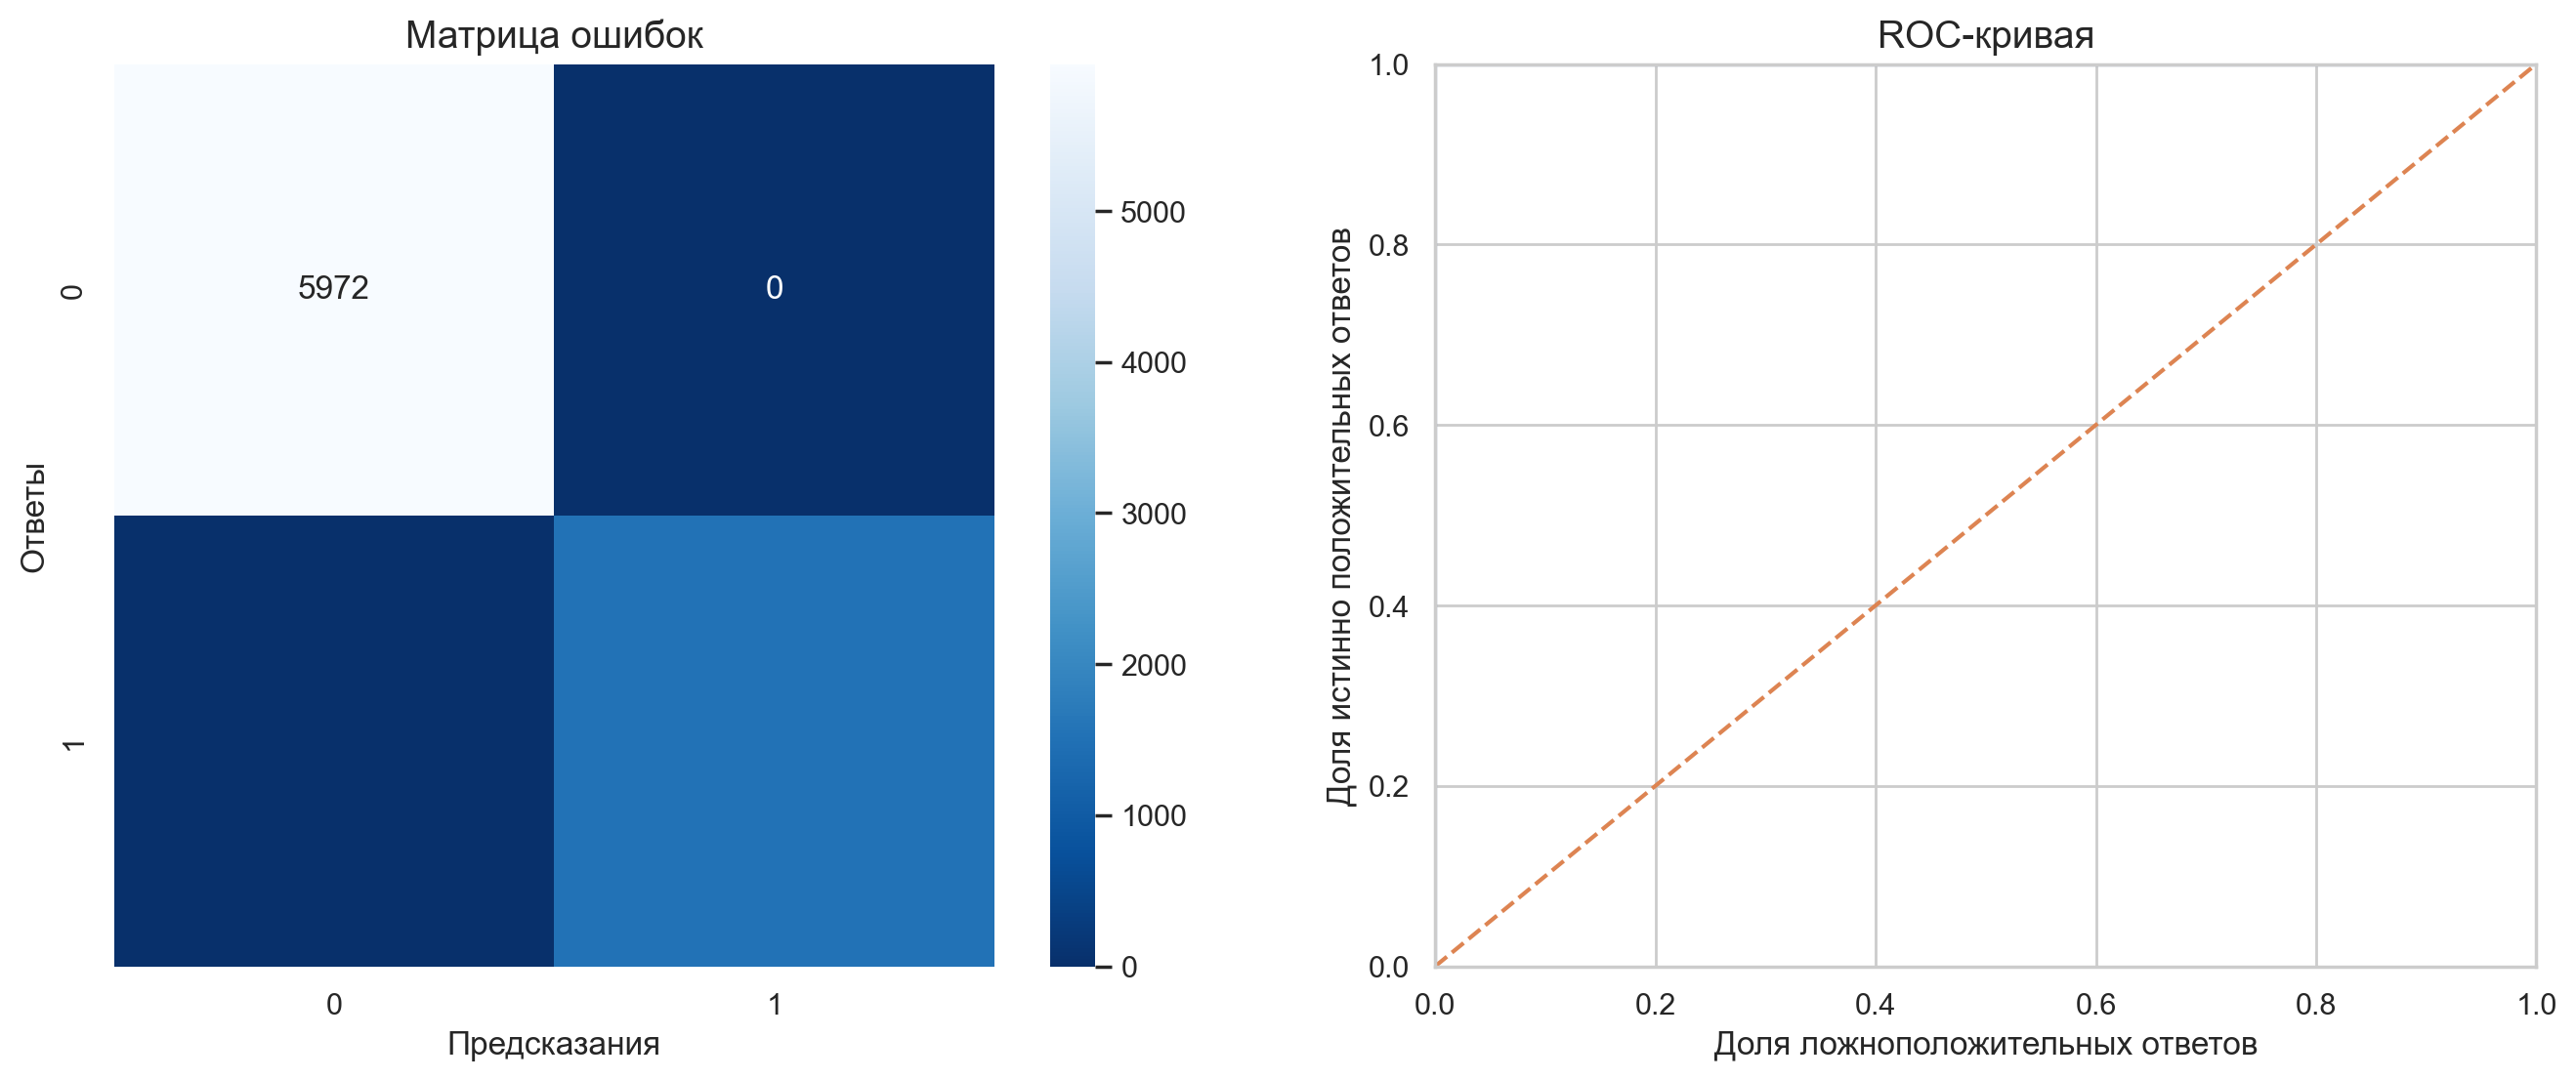

In [31]:
# построим матрицу ошибок и ROC-кривую
matrix_roc_auc(best_model_forest, features_train)

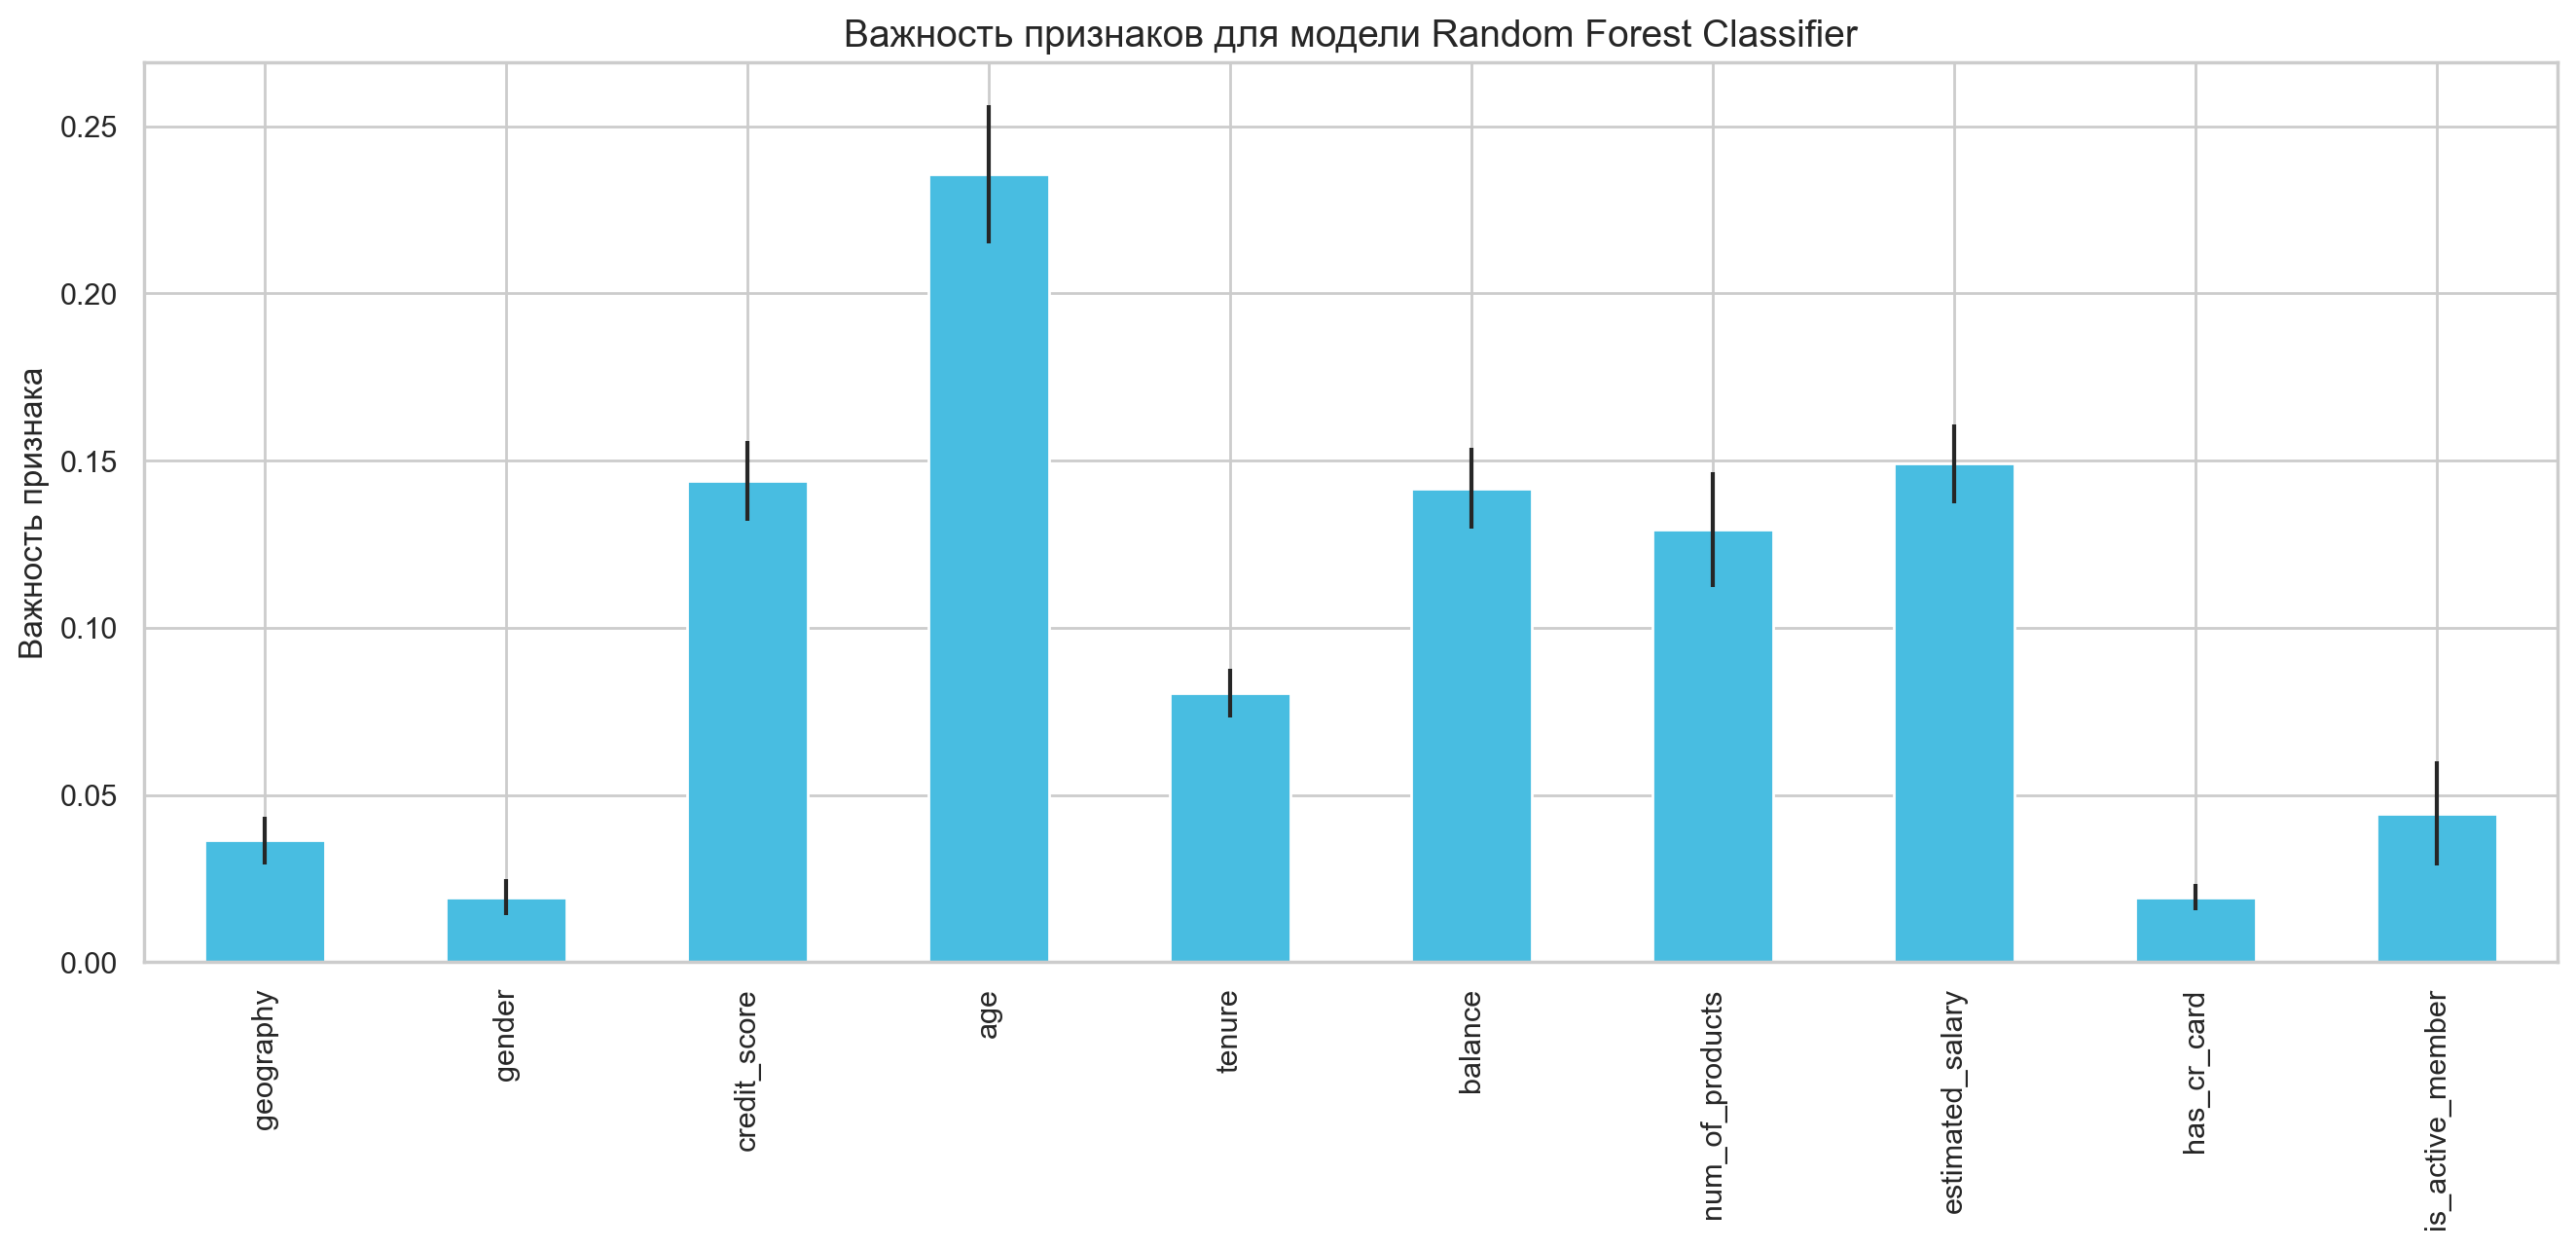

In [32]:
# построим график важности признаков
coef_forest = best_model_forest[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model_forest[1].estimators_], axis=0)
forest_importances = pd.Series(coef_forest, index=features_train_forest.columns)
feature_importance(forest_importances, std, name='Random Forest Classifier')

**Вывод:**

- После проверки моделей на несбалансированной выборке видим, что модель случайного леса имеет самое высокое значение F1-меры 0.57, когда задан гиперпараметр глубины дерева равный None с количеством деревьев 360;
- Значение AUC-ROC для данной модели равно 0.84, что выше модели дерева решений.

### Логистическая регрессия / Logistic Regression. Обучение модели без учета дисбаланса классов

- Обучим модель и оценим ее качество с помощью кроссвалидации, используя метрики F1 и AUC-ROC
- Построим матрицу ошибок и ROC кривую

In [33]:
# для кодирования и масштабирования логистической регрессии применим make_column_transformer
col_transformer_logreg = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore', sparse=True), cat_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [34]:
# применим make_column_transformer к обучающим данным
features_train_logreg = col_transformer_logreg.fit_transform(features_train)

# конвертируем разреженную матрицу в формат "sparse" по умолчанию для pandas
features_train_logreg = csc_matrix(features_train_logreg)

# создаём DataFrame с помощью метода pd.DataFrame.sparse.from_spmatrix()
features_train_logreg = pd.DataFrame.sparse.from_spmatrix(
    features_train_logreg, 
    columns=col_transformer_logreg.get_feature_names_out()
)

# выведем первые несколько строк
features_train_logreg.head()

,geography_Germany,geography_Spain,gender_Male,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.00,0.15,0.58,-0.00,1.26,0.81,-0.85,1.00,0.00
1,0.00,0.00,0.00,-0.10,2.69,-0.73,-1.22,-0.92,-1.00,0.00,1.00
2,0.00,0.00,0.00,-0.04,-0.86,-0.00,-1.22,0.81,-1.51,1.00,0.00
3,0.00,0.00,1.00,0.84,-0.28,-0.00,-1.22,0.81,1.06,1.00,0.00
4,0.00,0.00,1.00,1.45,-0.28,0.36,0.56,-0.92,1.55,1.00,1.00


In [35]:
# переберем различные гиперпараметры  Logistic Regression с помощью GridSearch CV. Найдем лучшие
model_logreg = LogisticRegression(random_state=Random_state)
pipeline_logreg = make_pipeline(col_transformer_logreg, model_logreg)

logreg_params = {
    'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(-3, 3, 7),
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 250, 500, 1000]
}


gs_logreg_pl = GridSearchCV (
    pipeline_logreg, 
    logreg_params, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_logreg_pl.fit(features_train, target_train)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_logreg_pl.cv_results_)[metrics].iloc[gs_logreg_pl.best_index_]
f1_logreg = results[0]
roc_auc_logreg = results[1]
best_model_logreg = gs_logreg_pl.best_estimator_

print(f'Среднее значение F1: {round(f1_logreg, 3)}')
print(f'Среднее значение ROC-AUC: {round(roc_auc_logreg, 3)}')
print(f'Лучшие параметры: {gs_logreg_pl.best_params_}')

Среднее значение F1: 0.314
Среднее значение ROC-AUC: 0.761
Лучшие параметры: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'none', 'logisticregression__solver': 'newton-cg'}


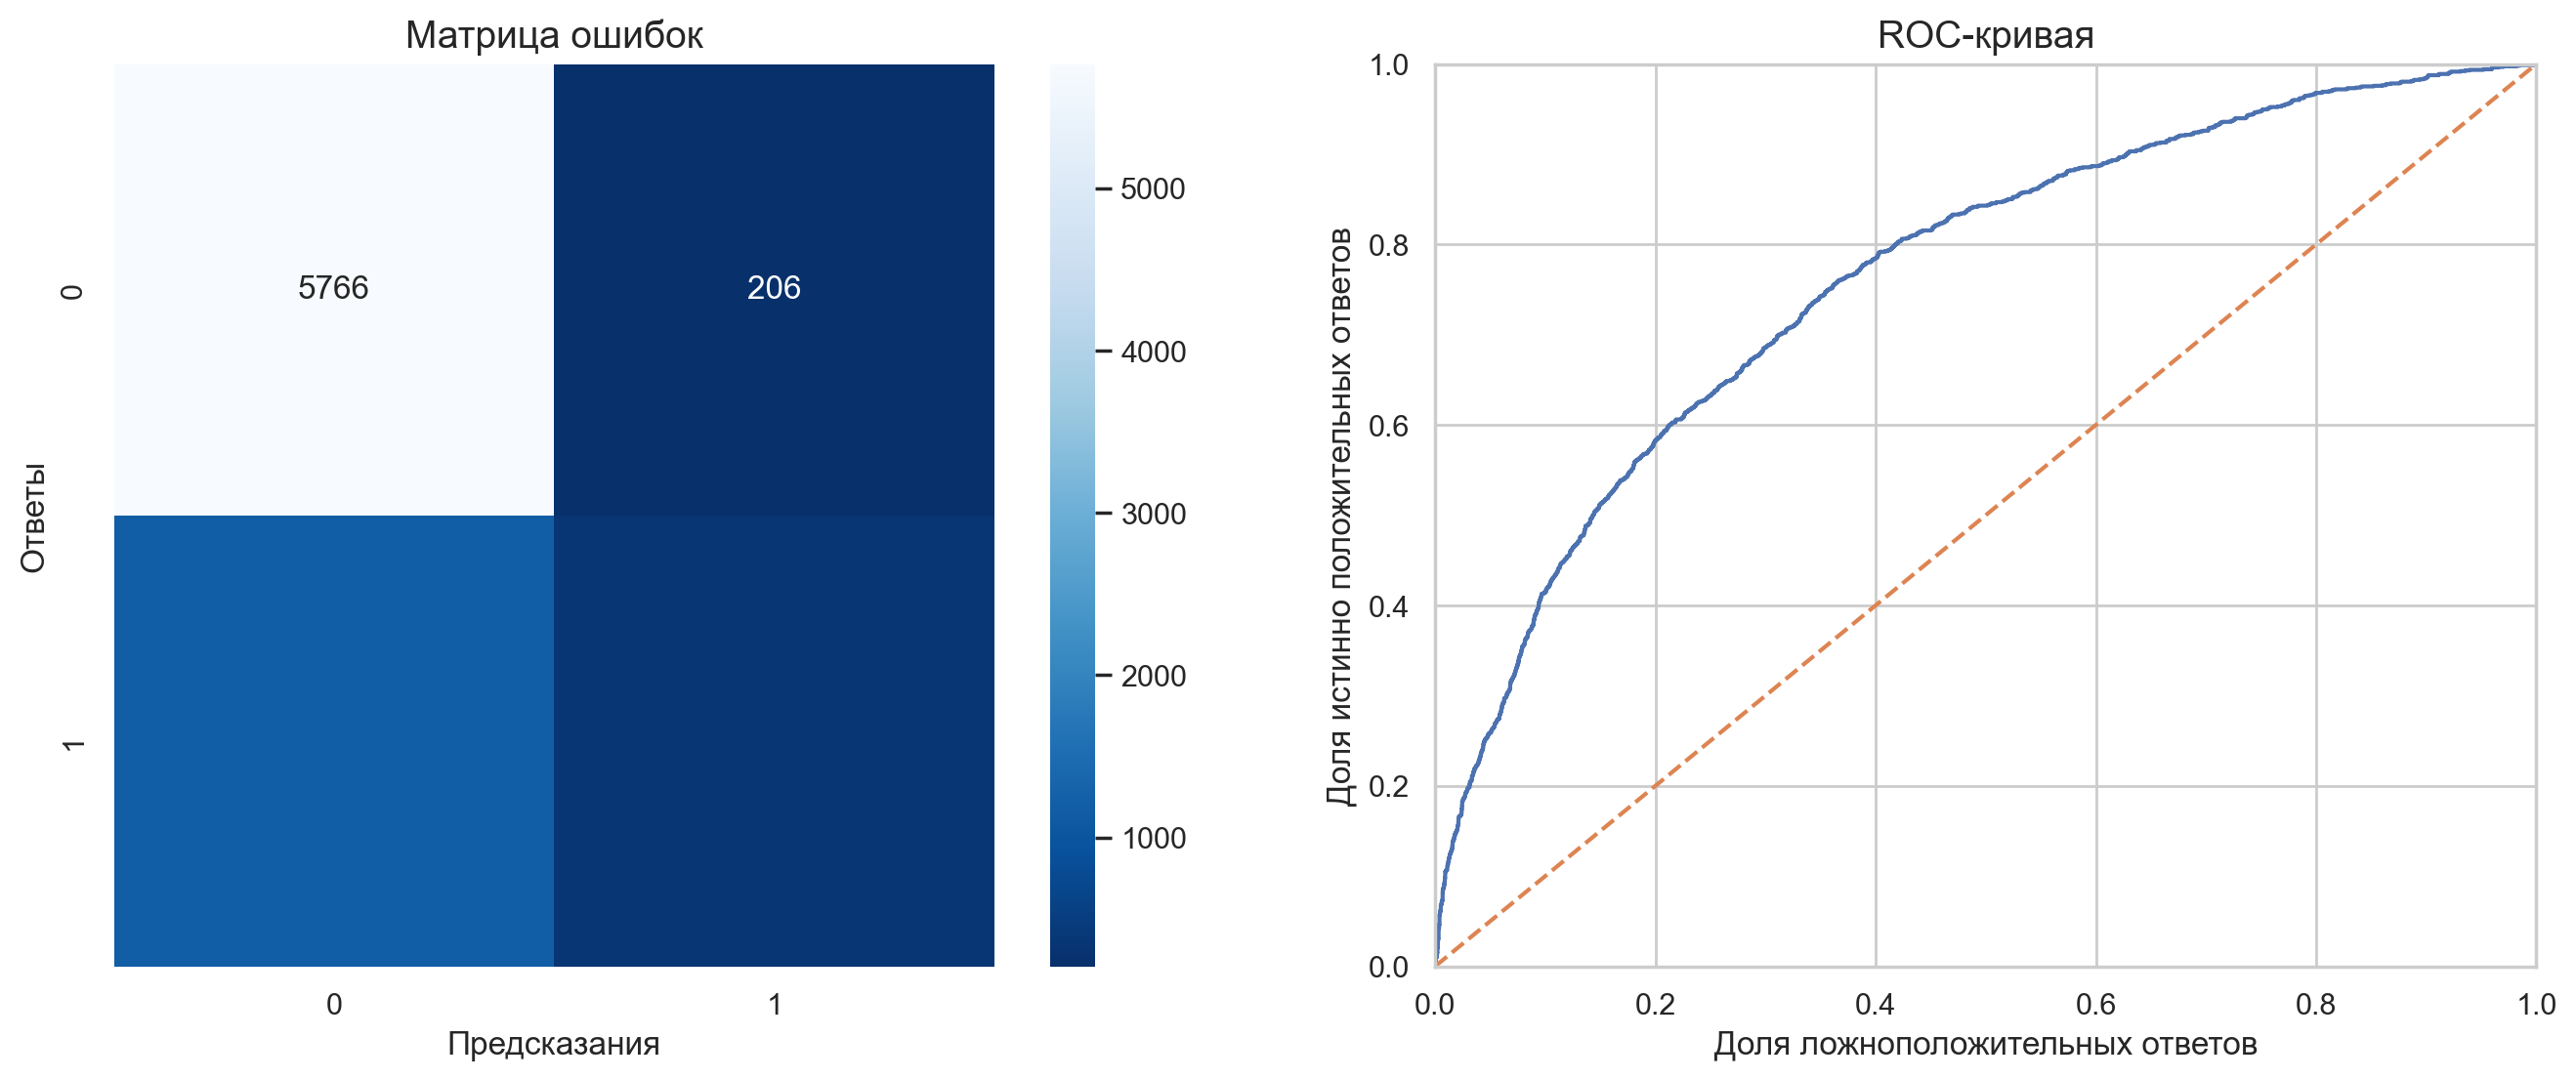

In [36]:
# построим матрицу ошибок и ROC-кривую
matrix_roc_auc(best_model_logreg, features_train)

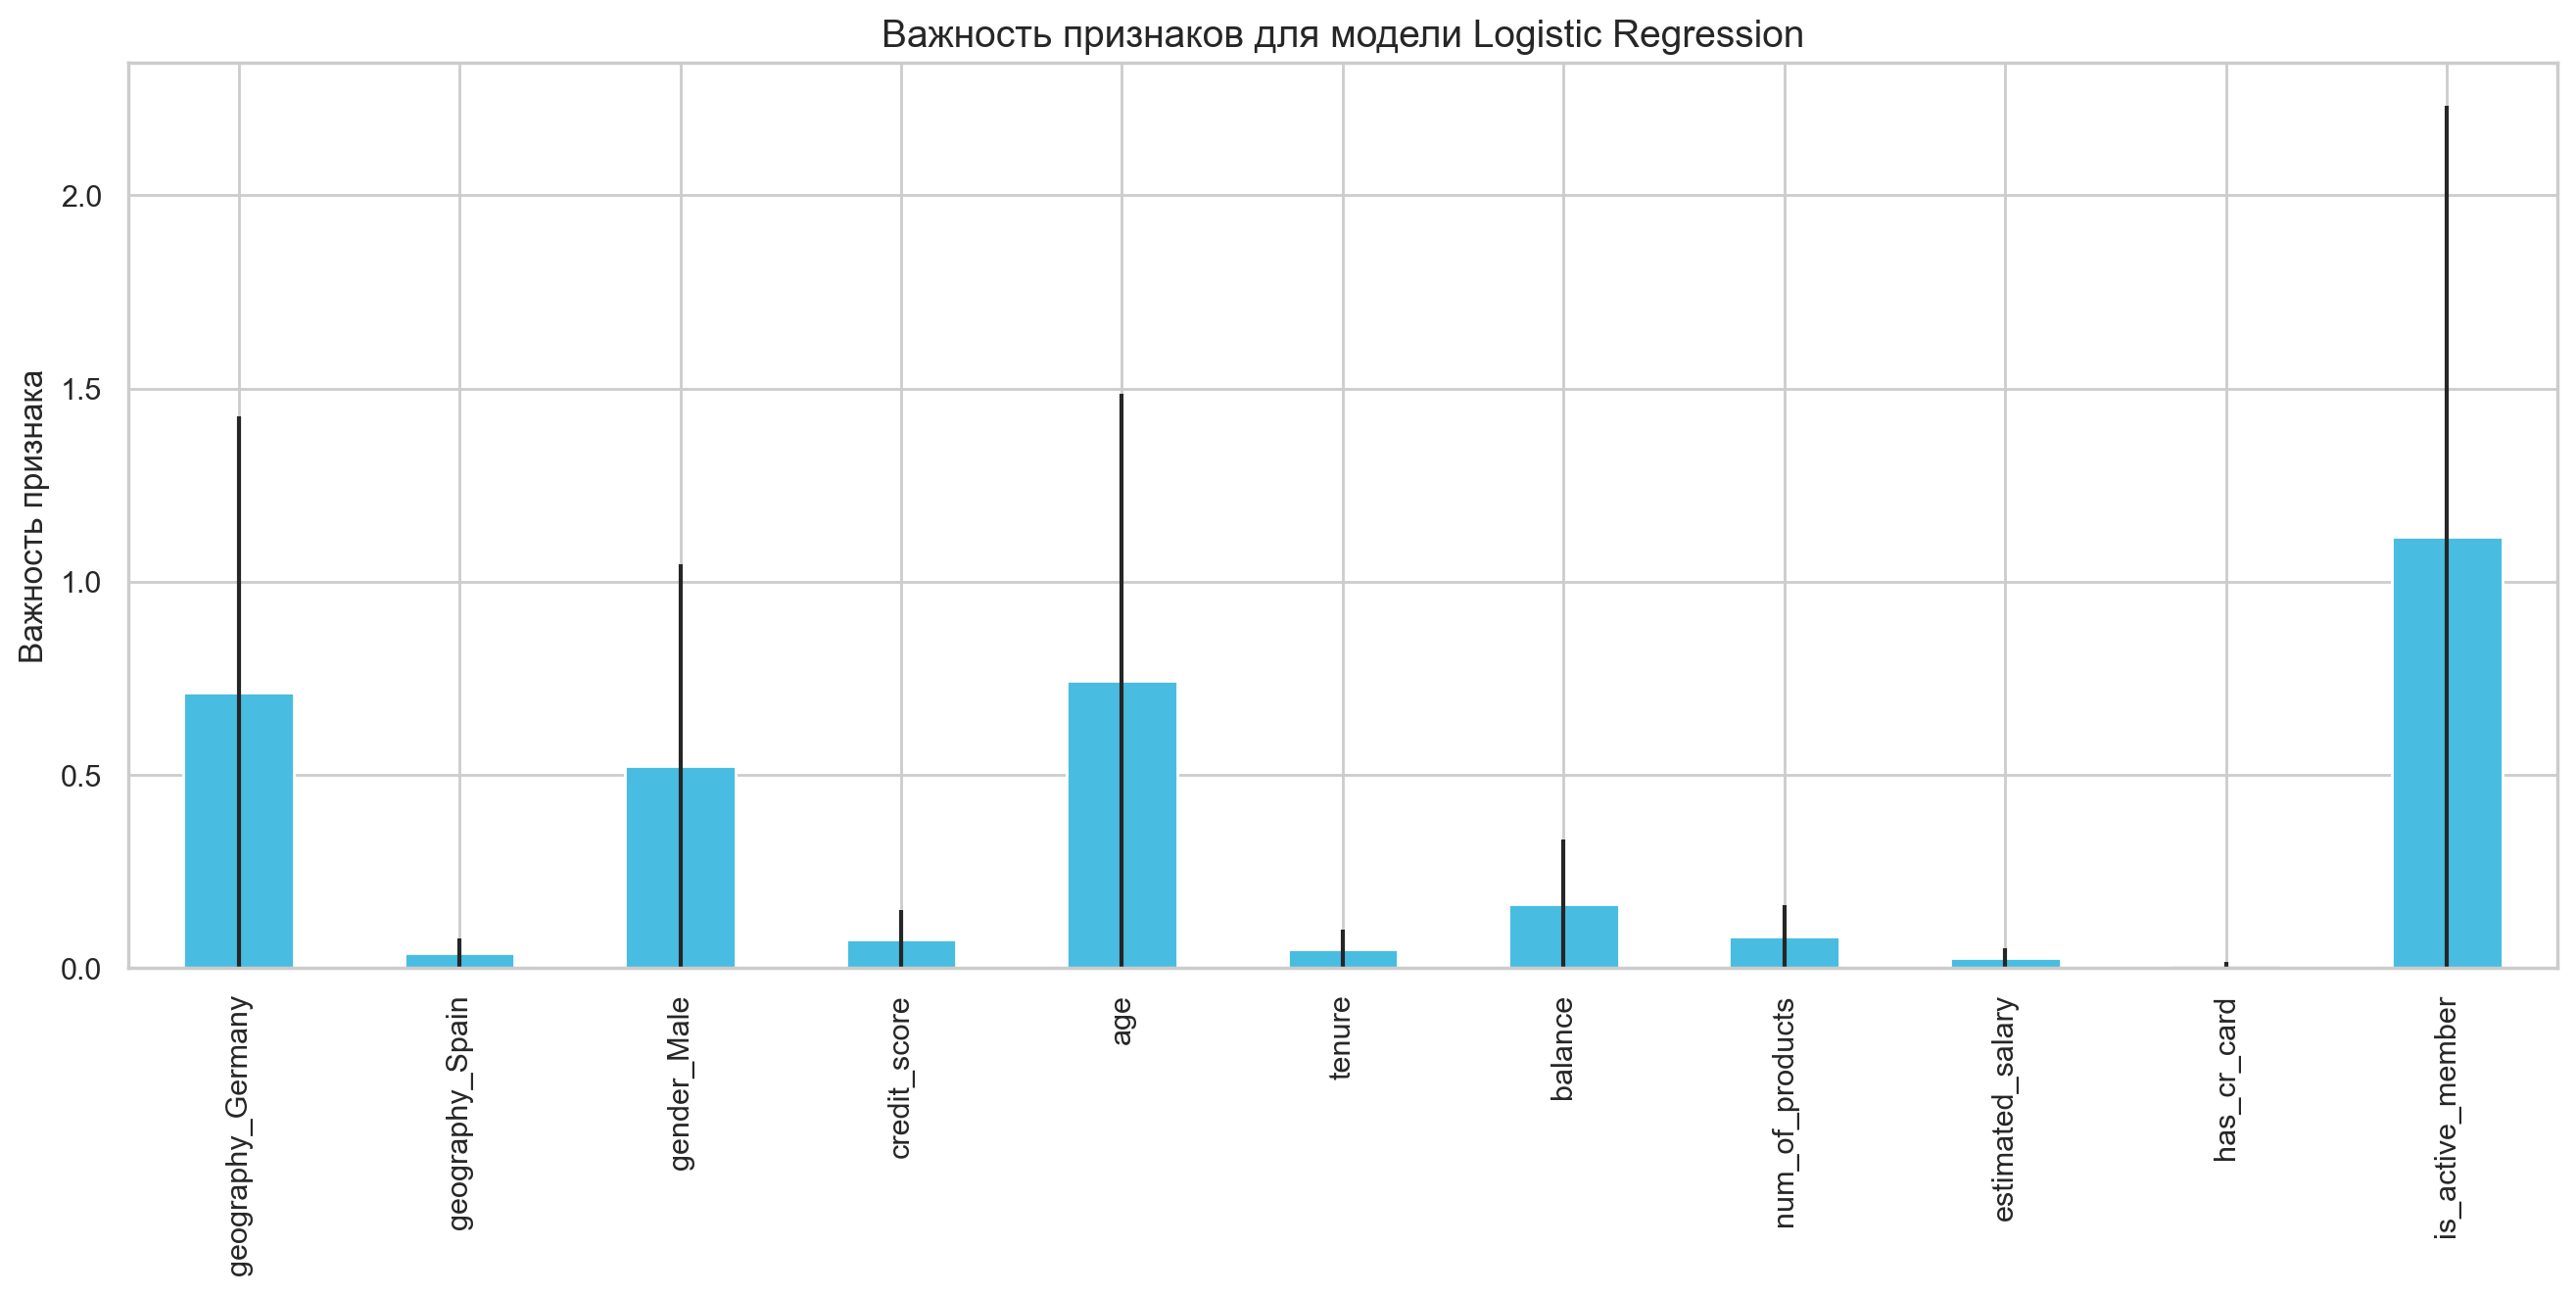

In [37]:
# построим график важности признаков
coef_logreg = best_model_logreg[1].coef_[0]
logreg_importances = pd.Series(abs(coef_logreg), index=features_train_logreg.columns)
feature_importance(logreg_importances, logreg_importances, name='Logistic Regression')

**Вывод:**

- Значение F1-меры для модели логистической регрессии равно 0.31;
- На матрице ошибок видим, что модель логистической регрессии верно предсказывает положительный класс примерно в 1 случае из 5-ти;
- Значение AUC-ROC для данной модели равно 0.76, что ниже, чем в предыдущих моделях.

### Вывод по этапу "Исследование задачи": 

1. По результатам исследования можно сказать, что лучшие результаты показывают модели случайного леса с глубиной None и количеством деревьев 360 и модель дерева решений с глубиной дерева 6. 


2. Тем не менее данные модели ошибаются в предсказании положительного класса (клиент ушел из банка) примерно в 50% случаев.


3. Улучшить результаты можно путем работы с дисбалансом классов.

## Борьба с дисбалансом

Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую. Для борьбы с дисбалансом будем использовать следующие подходы:
   - Взвешивание классов
   - Увеличение выборки
   - Уменьшение выборки

In [38]:
# создадим функцию для построения ROC-кривых
def roc_model(tree, forest, logistic, feacheres, target):
    probabilities_valid_tree = tree.predict_proba(feacheres)
    probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
    fpr_tree, tpr_tree, thresholds = roc_curve(target, probabilities_one_valid_tree) 

    probabilities_valid_forest = forest.predict_proba(feacheres)
    probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
    fpr_forest, tpr_forest, thresholds = roc_curve(target, probabilities_one_valid_forest) 
    
    probabilities_valid_logistic = logistic.predict_proba(feacheres)
    probabilities_one_valid_logistic = probabilities_valid_logistic[:, 1]
    fpr_logistic, tpr_logistic, thresholds = roc_curve(target, probabilities_one_valid_logistic) 

    plt.figure(figsize=(16, 8))
    plt.plot(fpr_tree, tpr_tree, label='Дерево решений')
    plt.plot(fpr_forest, tpr_forest, label='Случайный лес')
    plt.plot(fpr_logistic, tpr_logistic, label='Логистическая регрессия')
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0])
    plt.xlabel("Доля ложноположительных ответов", fontsize=12) 
    plt.ylabel("Доля истинно положительных ответов", fontsize=12)
    plt.title("ROC-кривая", fontsize=14)
    plt.show()

In [39]:
# создадим функцию для построения матрицы ошибок
def matrix_model(tree, forest, logistic, feacheres, target):
    
    print()
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    predictions = tree.predict(feacheres)
    matrix_tree = confusion_matrix(target, predictions)
    sns.heatmap(matrix_tree, annot=True, fmt=".0f", cmap="Blues_r", ax=ax[0])
    
    predictions = forest.predict(feacheres)
    matrix_forest = confusion_matrix(target, predictions)
    sns.heatmap(matrix_forest, annot=True, fmt=".0f", cmap="Blues_r", ax=ax[1])
    
    predictions = logistic.predict(feacheres)
    matrix_tree_log = confusion_matrix(target, predictions)
    sns.heatmap(matrix_tree_log, annot=True, fmt=".0f", cmap="Blues_r", ax=ax[2])
    
    ax[0].set(title='Матрица ошибок Дерева решений')
    ax[1].set(title='Матрица ошибок Случайного леса')
    ax[2].set(title='Матрица ошибок Логистической регрессии')
    ax[0].set(xlabel='Предсказания')
    ax[1].set(xlabel='Предсказания')
    ax[2].set(xlabel='Предсказания')
    ax[0].set(ylabel='Ответы')
    ax[1].set(ylabel='Ответы')
    ax[2].set(ylabel='Ответы')
    plt.show()

### Взвешивание классов

Обучим модели:
- Дерево решений / Decision Tree
- Случайный лес / Random Forest
- Логистическая регрессия / Logistic Regression

И добавим гиперпараметр class_weight='balanced'. Определим гиперпараметры, при которых достигается наилучшее качество модели.

In [40]:
# переберем различные гиперпараметры DecisionTreeClassifier с помощью Grid Search CV. Найдем лучшие
model_tree = DecisionTreeClassifier(random_state=Random_state)
pipeline_tree = make_pipeline(col_transformer_tree, model_tree)

param_grid_tree = {
    'decisiontreeclassifier__max_depth': [None] + [i for i in range(2, 7)],
    'decisiontreeclassifier__random_state': [Random_state],
    'decisiontreeclassifier__class_weight': ['balanced'],
}

gs_tree_pl = GridSearchCV (
    pipeline_tree, 
    param_grid_tree, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_tree_pl.fit(features_train, target_train)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_tree_pl.cv_results_)[metrics].iloc[gs_tree_pl.best_index_]
f1_tree_balanced = results[0]
roc_auc_tree_balanced = results[1]
best_model_tree = gs_tree_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_tree_balanced, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_tree_balanced, 3)}')
print(f'Лучшие параметры: {gs_tree_pl.best_params_}')

Среднее значение F1-меры: 0.56
Среднее значение AUC-ROC: 0.828
Лучшие параметры: {'decisiontreeclassifier__class_weight': 'balanced', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__random_state': 12345}


In [41]:
# переберем различные гиперпараметры RandomForestClassifier с помощью Grid Search CV. Найдем лучшие
model_forest = RandomForestClassifier(random_state=Random_state)
pipeline_forest = make_pipeline(col_transformer_forest, model_forest)

param_grid_forest = {
    'randomforestclassifier__max_depth': [None] + [i for i in range(2, 7)],
    'randomforestclassifier__n_estimators': range(10, 500, 50),
    'randomforestclassifier__random_state': [Random_state],
    'randomforestclassifier__class_weight': ['balanced'],
}

gs_forest_pl = GridSearchCV (
    pipeline_forest, 
    param_grid_forest, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_forest_pl.fit(features_train, target_train)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_forest_pl.cv_results_)[metrics].iloc[gs_forest_pl.best_index_]
f1_forest_balanced = results[0]
roc_auc_forest_balanced = results[1]

best_model_forest = gs_forest_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_forest_balanced, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_forest_balanced, 3)}')
print(f'Лучшие параметры: {gs_forest_pl.best_params_}')

Среднее значение F1-меры: 0.591
Среднее значение AUC-ROC: 0.852
Лучшие параметры: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 60, 'randomforestclassifier__random_state': 12345}


In [42]:
# переберем различные гиперпараметры  Logistic Regression с помощью GridSearch CV. Найдем лучшие
model_logreg = LogisticRegression(random_state=Random_state)
pipeline_logreg = make_pipeline(col_transformer_logreg, model_logreg)

logreg_params = {
    'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(-3, 3, 7),
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 250, 500, 1000],
    'logisticregression__class_weight': ['balanced'],
}


gs_logreg_pl = GridSearchCV (
    pipeline_logreg, 
    logreg_params, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_logreg_pl.fit(features_train, target_train)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_logreg_pl.cv_results_)[metrics].iloc[gs_logreg_pl.best_index_]
f1_log_balanced = results[0]
roc_auc_log_balanced = results[1]
best_model_logreg = gs_logreg_pl.best_estimator_

print(f'Среднее значение F1: {round(f1_log_balanced, 3)}')
print(f'Среднее значение ROC-AUC: {round(roc_auc_log_balanced, 3)}')
print(f'Лучшие параметры: {gs_logreg_pl.best_params_}')

Среднее значение F1: 0.498
Среднее значение ROC-AUC: 0.759
Лучшие параметры: {'logisticregression__C': 0.001, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


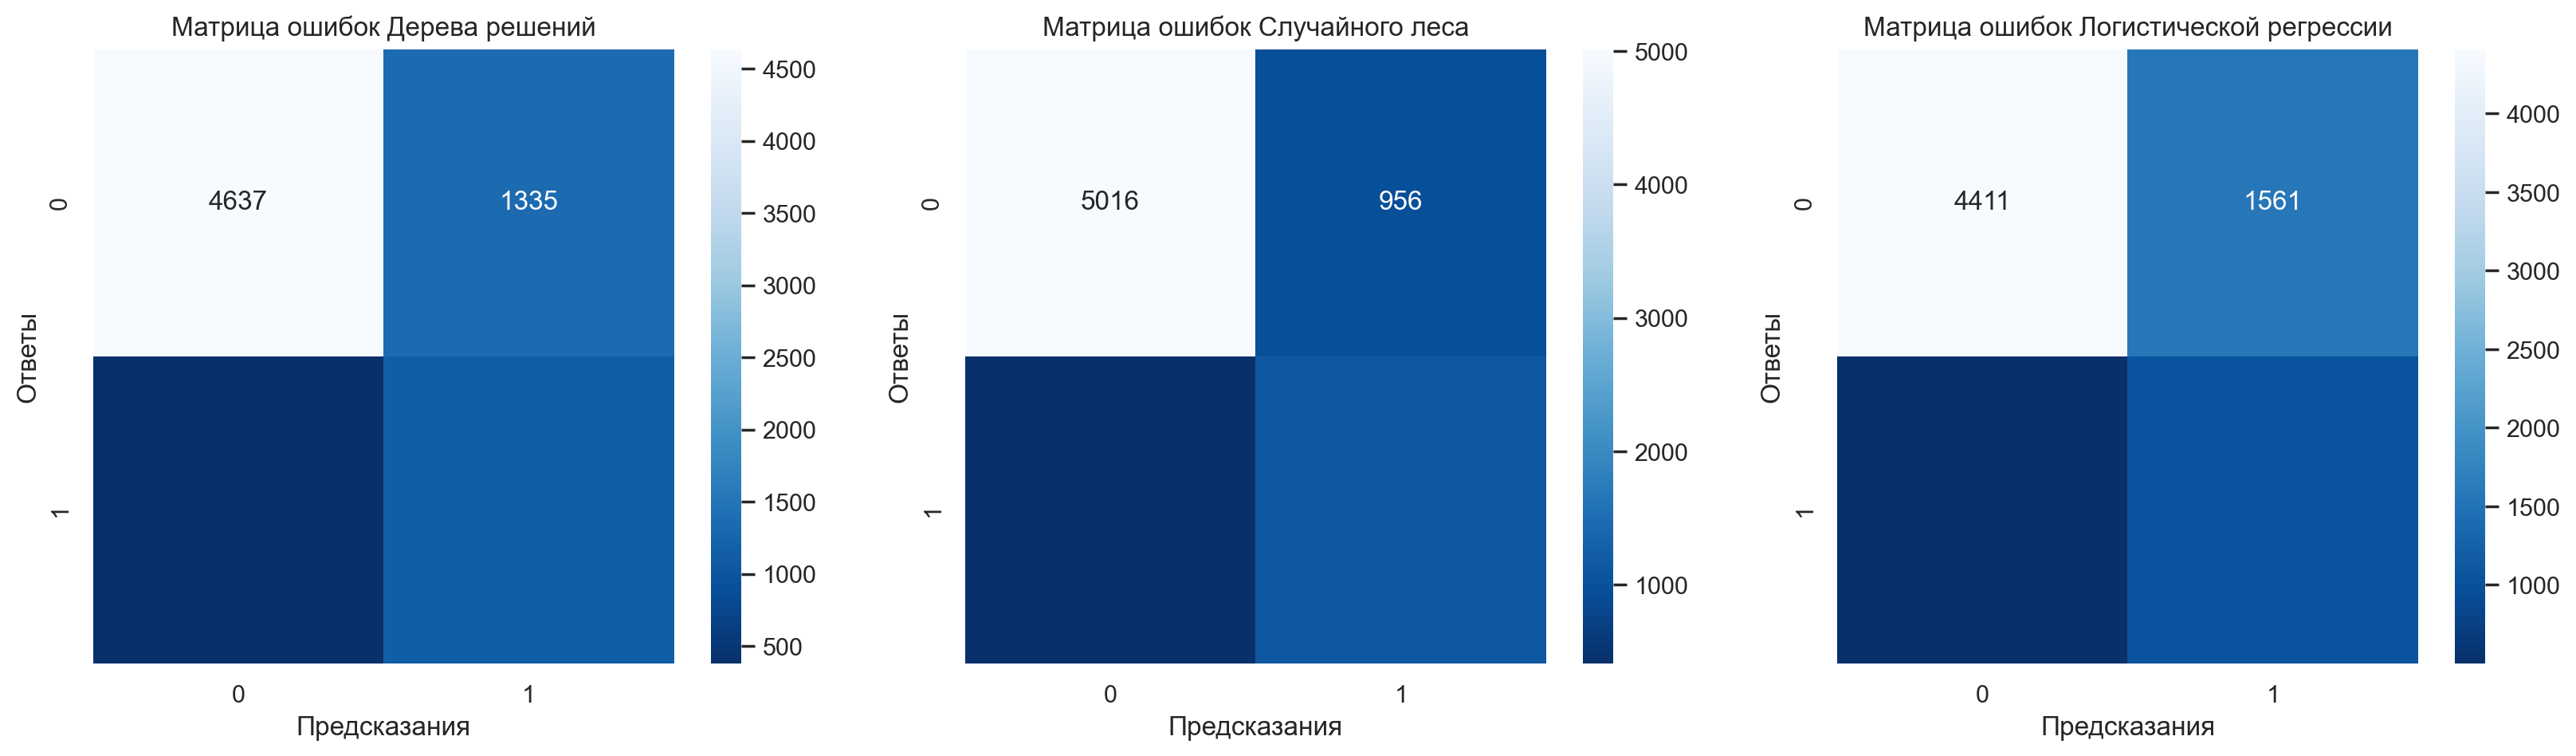

In [43]:
# построим матрицы ошибок
matrix_model(best_model_tree, best_model_forest, best_model_logreg, features_train, target_train)

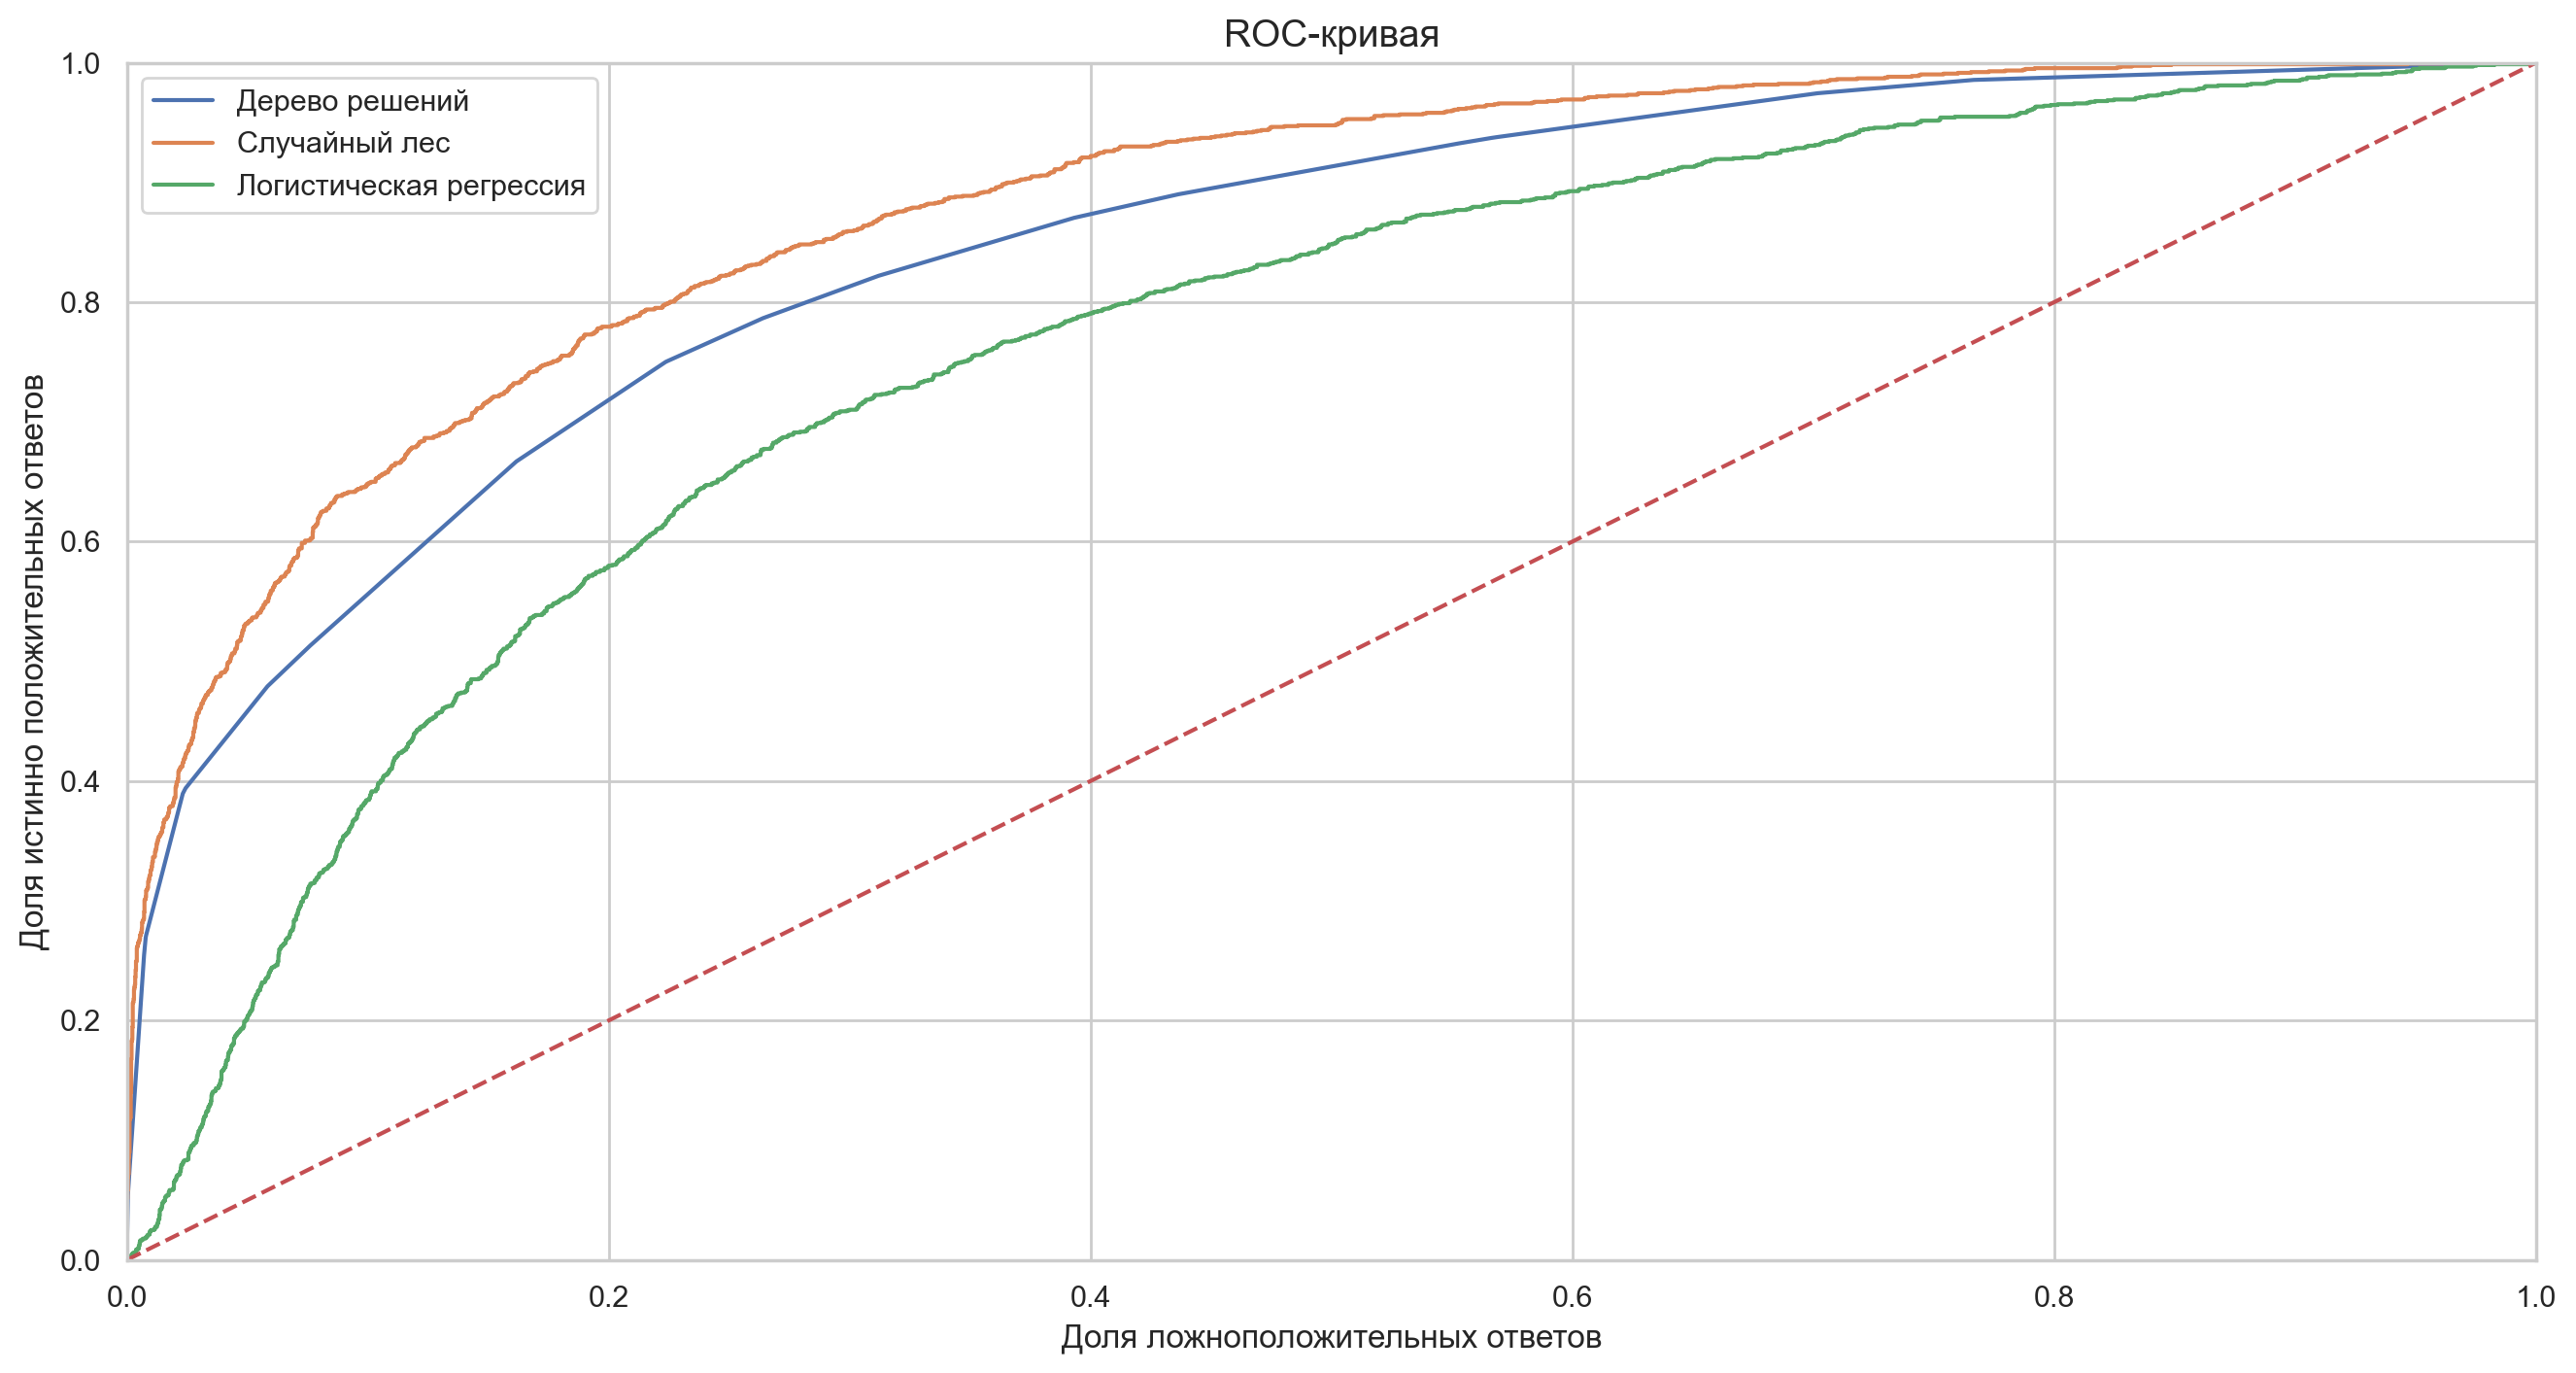

In [44]:
# сравним ROC-кривые
roc_model(best_model_tree, best_model_forest, best_model_logreg, features_train, target_train)

**Вывод:**

- Наилучшее значение метрики F1 = 0.59 показывает модель Случайного леса с глубиной 6 и количеством деревьев 60, что является хорошим результатом. Данная модель стала лучше предсказывать положительный класс (клиент ушел из банка), но хуже отрицательный.

- Можно заметить, что взвешивание классов повысило распознание положительного класса и понизило распознание отрицательного у всех моделей.

- Взвешивание классов значительно повысило значение F1-меры у логистической регрессии.

### Увеличение выборки

- Разделим обучающую выборку на отрицательные и положительные объекты,
- Скопируем несколько раз положительные объекты,
- С учётом полученных данных создим новую обучающую выборку,
- Перемешаем данные.

Обучим модели Дерева решений, Случайного леса и Логистической регрессии на новой выборке.

In [45]:
# создадим функцию для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [46]:
# подготовим обучающую выборку, увеличив долю положительного класса в 3 раза
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
display(features_upsampled.shape)
target_upsampled.value_counts()

(10556, 10)

exited
0    5972
1    4584
Name: count, dtype: int64

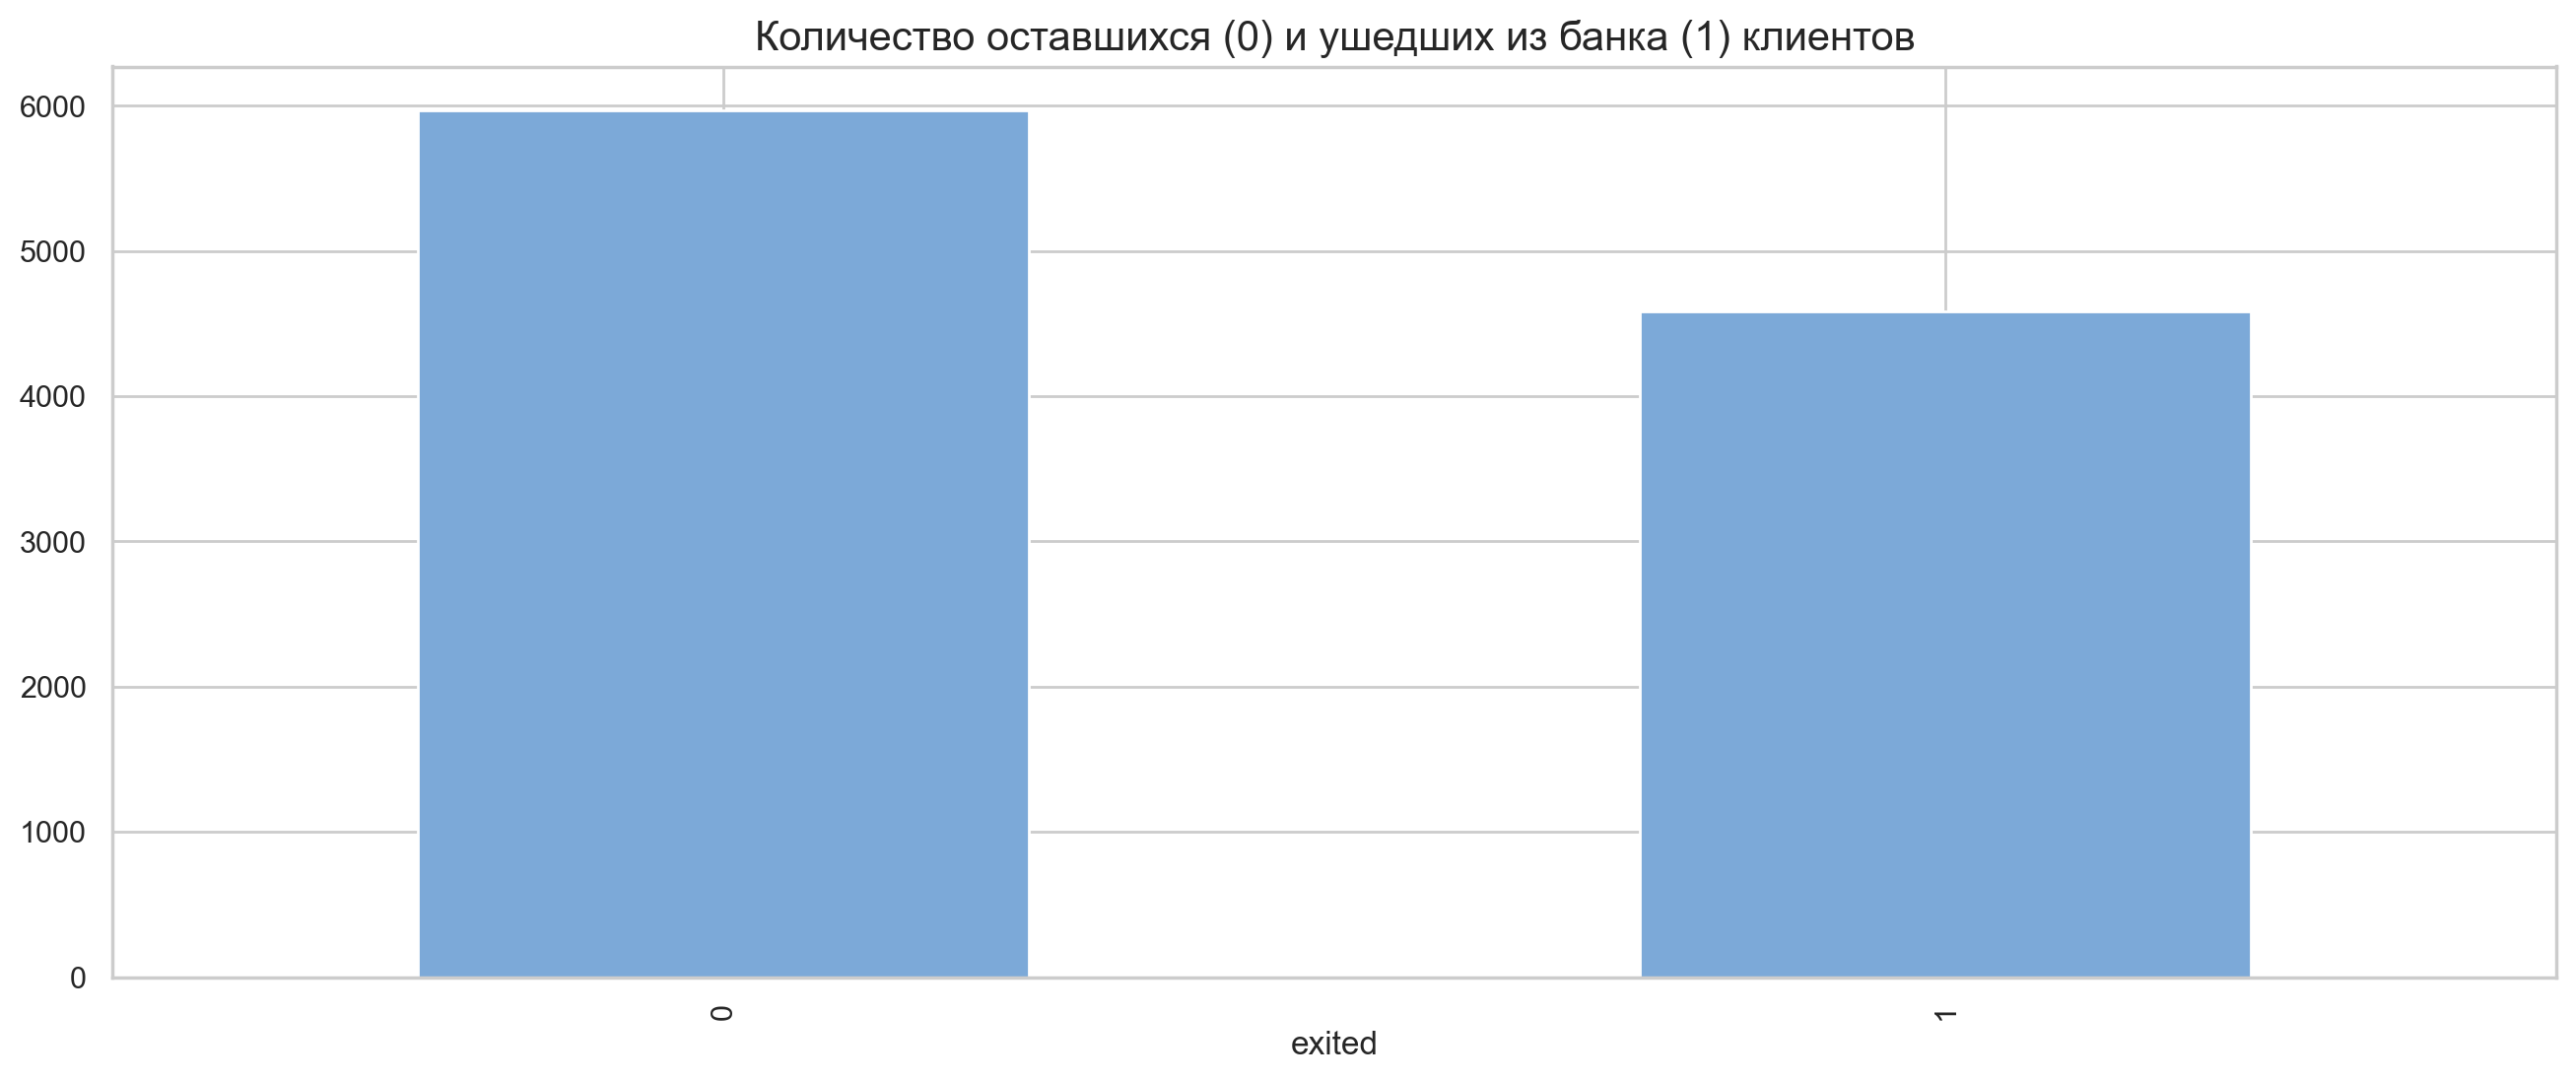

In [47]:
# построим распределение
plt.figure(figsize=(16, 6))
target_upsampled.value_counts().plot(kind='bar', color='#7ca9d8', grid=True)
plt.title("Количество оставшихся (0) и ушедших из банка (1) клиентов", fontsize=15)
plt.show()

In [48]:
# применим make_column_transformer к обучающим данным
features_train_tree_upsampled = col_transformer_tree.fit_transform(features_upsampled)
features_train_tree_upsampled = csc_matrix(features_train_tree_upsampled)
features_train_tree_upsampled = pd.DataFrame.sparse.from_spmatrix(
    features_train_tree_upsampled, 
    columns=col_transformer_tree.get_feature_names_out()
)

features_train_tree_upsampled.head()

,geography,gender,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.56,-0.15,1.82,0.35,0.75,1.23,1.00,0.00
1,0.00,1.00,1.06,0.51,1.09,-1.31,2.28,-0.18,1.00,0.00
2,1.00,1.00,-0.12,0.23,-1.44,0.89,0.75,0.01,0.00,1.00
3,1.00,0.00,-0.12,-0.15,-0.72,0.47,-0.79,-0.22,1.00,1.00
4,0.00,1.00,0.00,-0.15,-0.72,0.52,-0.79,-0.71,1.00,1.00


In [49]:
# переберем различные гиперпараметры DecisionTreeClassifier с помощью Grid Search CV. Найдем лучшие
model_tree = DecisionTreeClassifier(random_state=Random_state)
pipeline_tree = make_pipeline(col_transformer_tree, model_tree)

param_grid_tree = {
    'decisiontreeclassifier__max_depth': [i for i in range(2, 7)],
    'decisiontreeclassifier__random_state': [Random_state],
}

gs_tree_pl = GridSearchCV (
    pipeline_tree, 
    param_grid_tree, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_tree_pl.fit(features_upsampled, target_upsampled)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_tree_pl.cv_results_)[metrics].iloc[gs_tree_pl.best_index_]
f1_tree_upsampled = results[0]
roc_auc_tree_upsampled = results[1]
best_model_tree = gs_tree_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_tree_upsampled, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_tree_upsampled, 3)}')
print(f'Лучшие параметры: {gs_tree_pl.best_params_}')

Среднее значение F1-меры: 0.708
Среднее значение AUC-ROC: 0.847
Лучшие параметры: {'decisiontreeclassifier__max_depth': 6, 'decisiontreeclassifier__random_state': 12345}


In [50]:
# применим make_column_transformer к обучающим данным
features_train_forest_upsampled = col_transformer_forest.fit_transform(features_upsampled)
features_train_forest_upsampled = csc_matrix(features_train_forest_upsampled)
features_train_forest_upsampled = pd.DataFrame.sparse.from_spmatrix(
    features_train_forest_upsampled, 
    columns=col_transformer_forest.get_feature_names_out()
)

features_train_forest_upsampled.head()

,geography,gender,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.56,-0.15,1.82,0.35,0.75,1.23,1.00,0.00
1,0.00,1.00,1.06,0.51,1.09,-1.31,2.28,-0.18,1.00,0.00
2,1.00,1.00,-0.12,0.23,-1.44,0.89,0.75,0.01,0.00,1.00
3,1.00,0.00,-0.12,-0.15,-0.72,0.47,-0.79,-0.22,1.00,1.00
4,0.00,1.00,0.00,-0.15,-0.72,0.52,-0.79,-0.71,1.00,1.00


In [51]:
# переберем различные гиперпараметры RandomForestClassifier с помощью Grid Search CV. Найдем лучшие
model_forest = RandomForestClassifier(random_state=Random_state)
pipeline_forest = make_pipeline(col_transformer_forest, model_forest)

param_grid_forest = {
    'randomforestclassifier__max_depth': [i for i in range(2, 7)],
    'randomforestclassifier__n_estimators': range(10, 500, 50),
    'randomforestclassifier__random_state': [Random_state],
}

gs_forest_pl = GridSearchCV (
    pipeline_forest, 
    param_grid_forest, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_forest_pl.fit(features_upsampled, target_upsampled)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_forest_pl.cv_results_)[metrics].iloc[gs_forest_pl.best_index_]
f1_forest_upsampled = results[0]
roc_auc_forest_upsampled = results[1]

best_model_forest = gs_forest_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_forest_upsampled, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_forest_upsampled, 3)}')
print(f'Лучшие параметры: {gs_forest_pl.best_params_}')

Среднее значение F1-меры: 0.725
Среднее значение AUC-ROC: 0.866
Лучшие параметры: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 210, 'randomforestclassifier__random_state': 12345}


In [52]:
# применим make_column_transformer к обучающим данным
features_train_logreg_upsampled = col_transformer_logreg.fit_transform(features_upsampled)
features_train_logreg_upsampled = csc_matrix(features_train_logreg_upsampled)
features_train_logreg_upsampled = pd.DataFrame.sparse.from_spmatrix(
    features_train_logreg_upsampled, 
    columns=col_transformer_logreg.get_feature_names_out()
)

features_train_logreg_upsampled.head()

,geography_Germany,geography_Spain,gender_Male,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.00,0.56,-0.15,1.82,0.35,0.75,1.23,1.00,0.00
1,0.00,0.00,1.00,1.06,0.51,1.09,-1.31,2.28,-0.18,1.00,0.00
2,1.00,0.00,1.00,-0.12,0.23,-1.44,0.89,0.75,0.01,0.00,1.00
3,1.00,0.00,0.00,-0.12,-0.15,-0.72,0.47,-0.79,-0.22,1.00,1.00
4,0.00,0.00,1.00,0.00,-0.15,-0.72,0.52,-0.79,-0.71,1.00,1.00


In [53]:
# переберем различные гиперпараметры  Logistic Regression с помощью GridSearch CV. Найдем лучшие
model_logreg = LogisticRegression(random_state=Random_state)
pipeline_logreg = make_pipeline(col_transformer_logreg, model_logreg)

logreg_params = {
    'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(-3, 3, 7),
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 250, 500, 1000],
}


gs_logreg_pl = GridSearchCV (
    pipeline_logreg, 
    logreg_params, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_logreg_pl.fit(features_upsampled, target_upsampled)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_logreg_pl.cv_results_)[metrics].iloc[gs_logreg_pl.best_index_]
f1_log_upsampled = results[0]
roc_auc_log_upsampled = results[1]
best_model_logreg = gs_logreg_pl.best_estimator_

print(f'Среднее значение F1: {round(f1_log_upsampled, 3)}')
print(f'Среднее значение ROC-AUC: {round(roc_auc_log_upsampled, 3)}')
print(f'Лучшие параметры: {gs_logreg_pl.best_params_}')

Среднее значение F1: 0.644
Среднее значение ROC-AUC: 0.727
Лучшие параметры: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


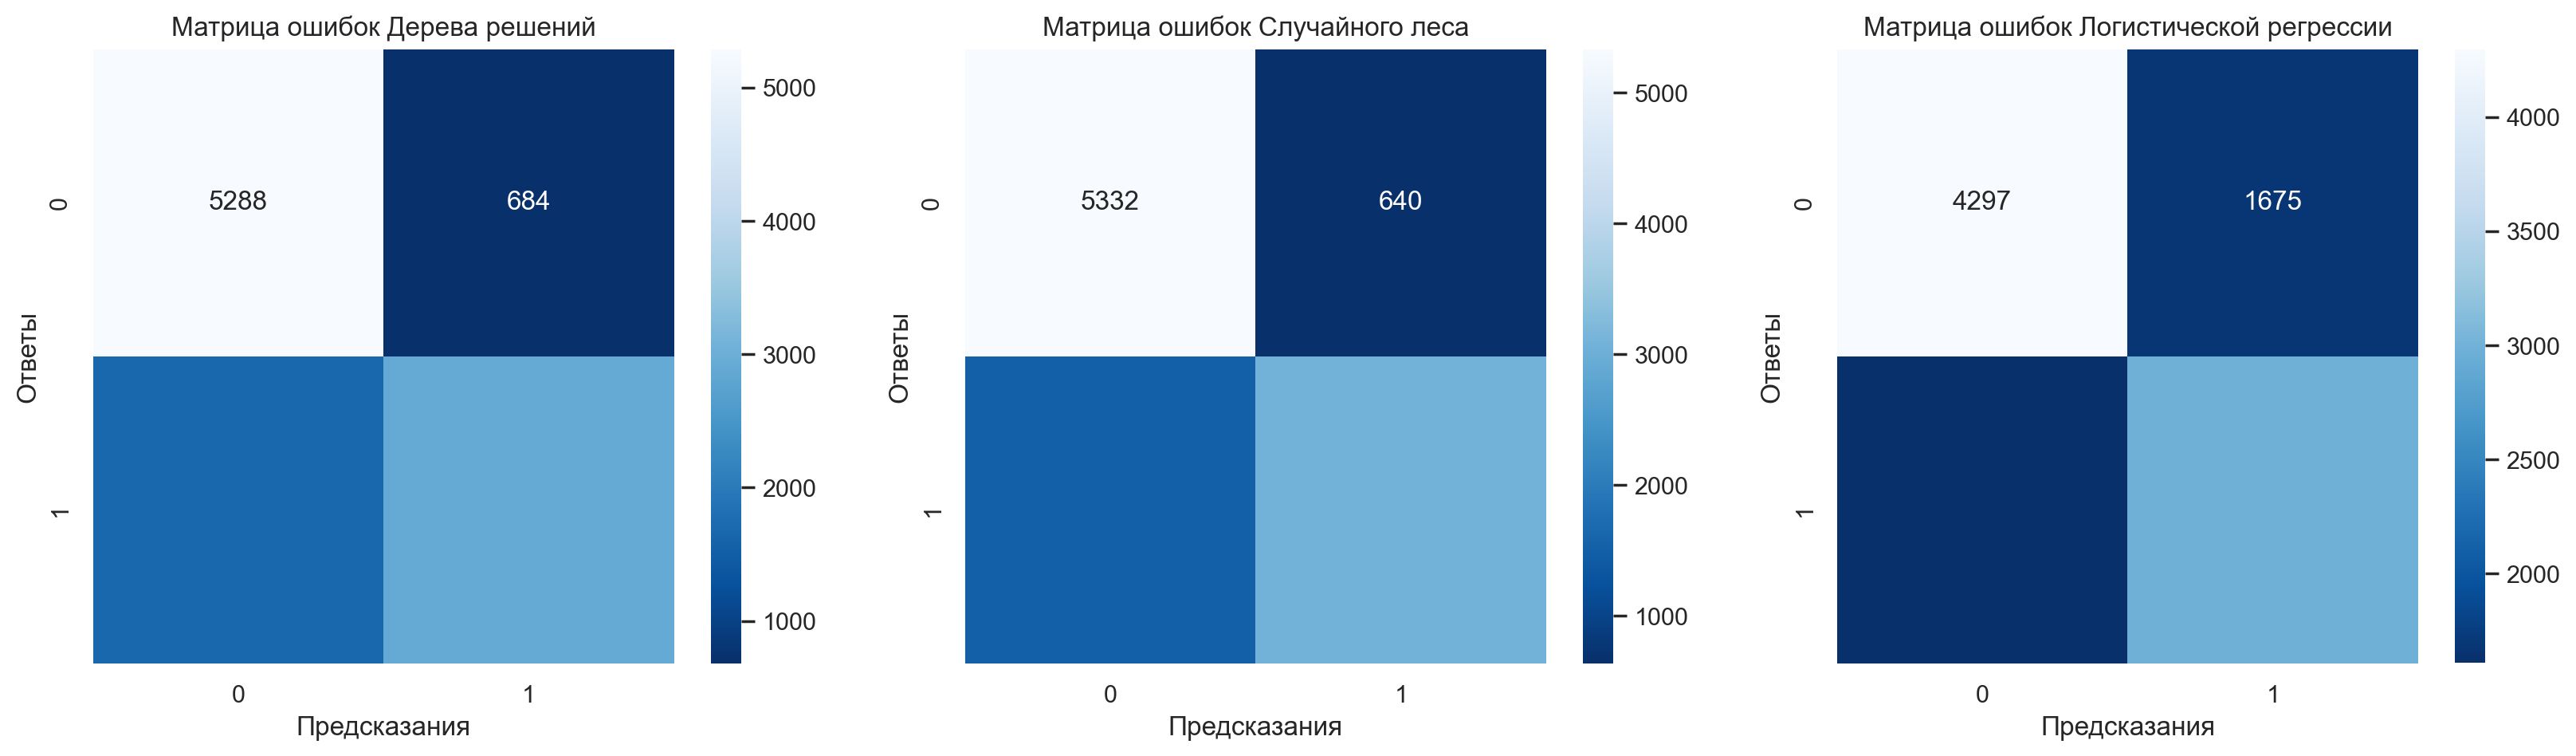

In [54]:
# построим матрицы ошибок
matrix_model(best_model_tree, best_model_forest, best_model_logreg, features_upsampled, target_upsampled)

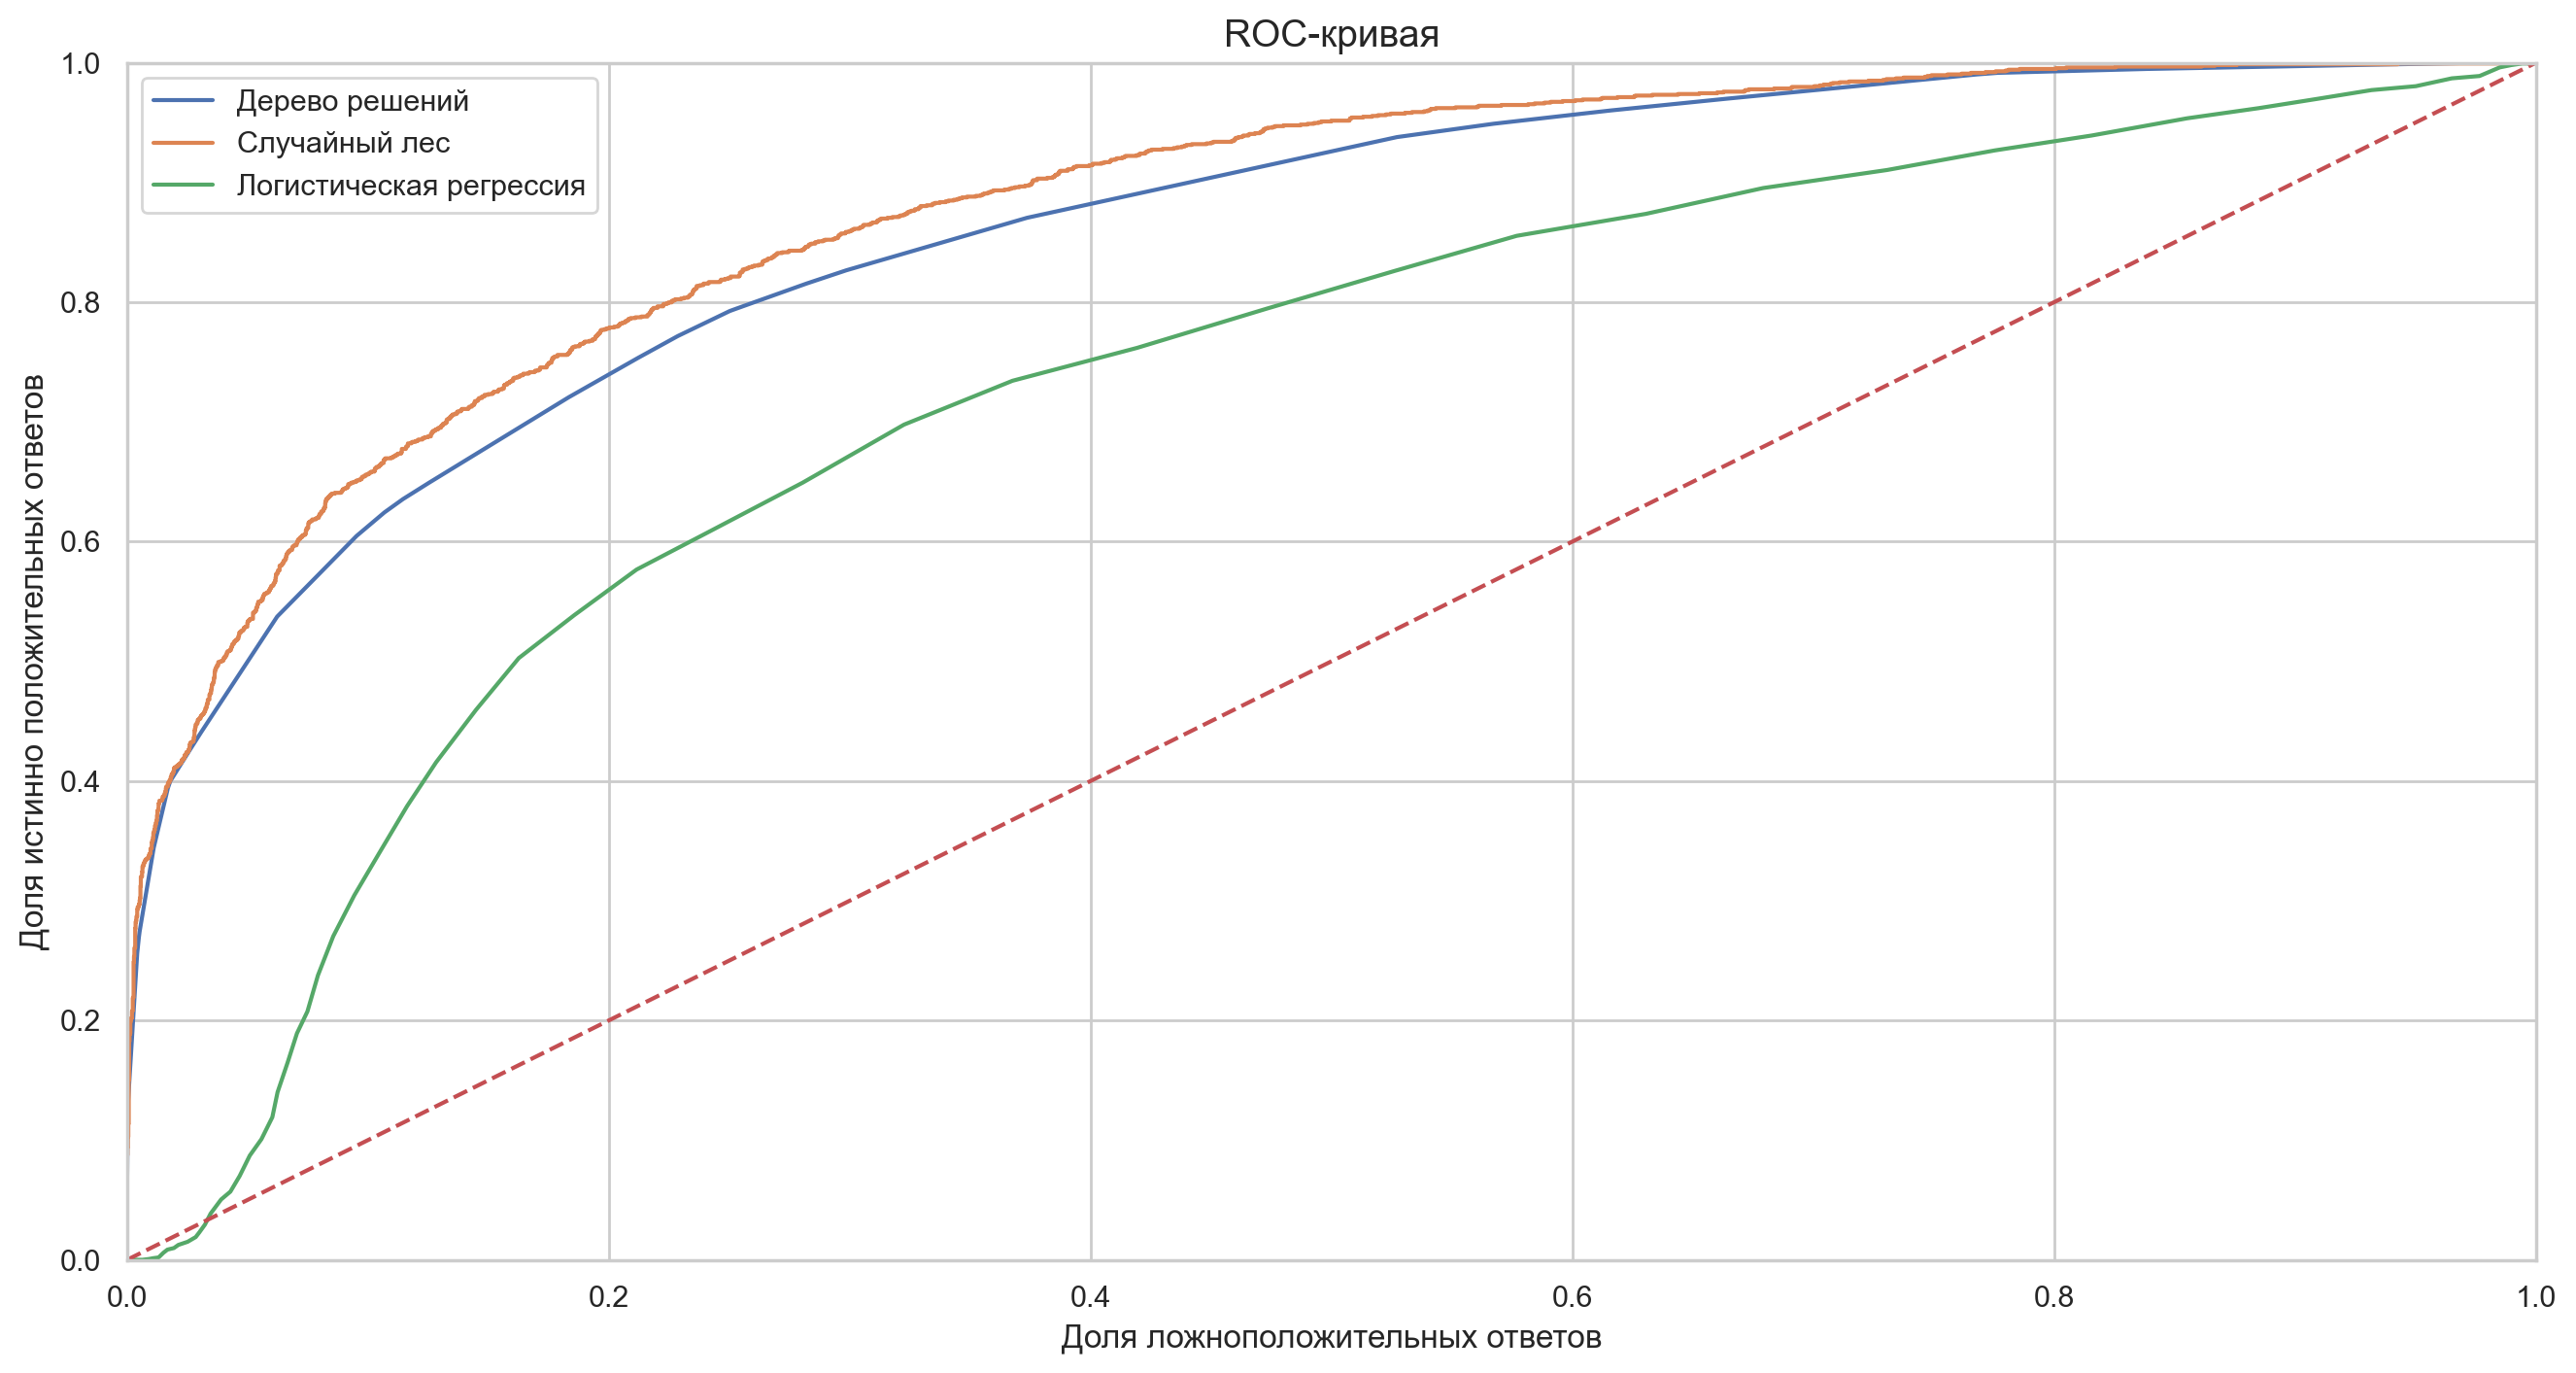

In [55]:
# сравним ROC-кривые
roc_model(best_model_tree, best_model_forest, best_model_logreg, features_upsampled, target_upsampled)

**Вывод:**

- Наилучшее значение метрики F1 = 0.72 по-прежнему показывает модель Случайного леса с глубиной 6 и количеством деревьев 210. Это значение выше, чем в методе взвешивания классов.

- Можно заметить, что увеличение выборки показывает лучшие по качеству результаты по сравнению с взвешиванием классов для всех моделей.

### Уменьшение выборки

- Разделим обучающую выборку на отрицательные и положительные объекты,
- Случайным образом отбросим часть из отрицательных объектов,
- С учётом полуенных данных создим новую обучающую выборку,
- Перемешаем данные.

Обучим модели Дерева решений, Случайного леса и Логистической регрессии на новой выборке.

In [56]:
# создадим функцию для уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [57]:
# подготовим обучающую выборку, уменьшив долю отрицательного класса в 2 раза
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)
display(features_downsampled.shape)
target_downsampled.value_counts()

(4514, 10)

exited
0    2986
1    1528
Name: count, dtype: int64

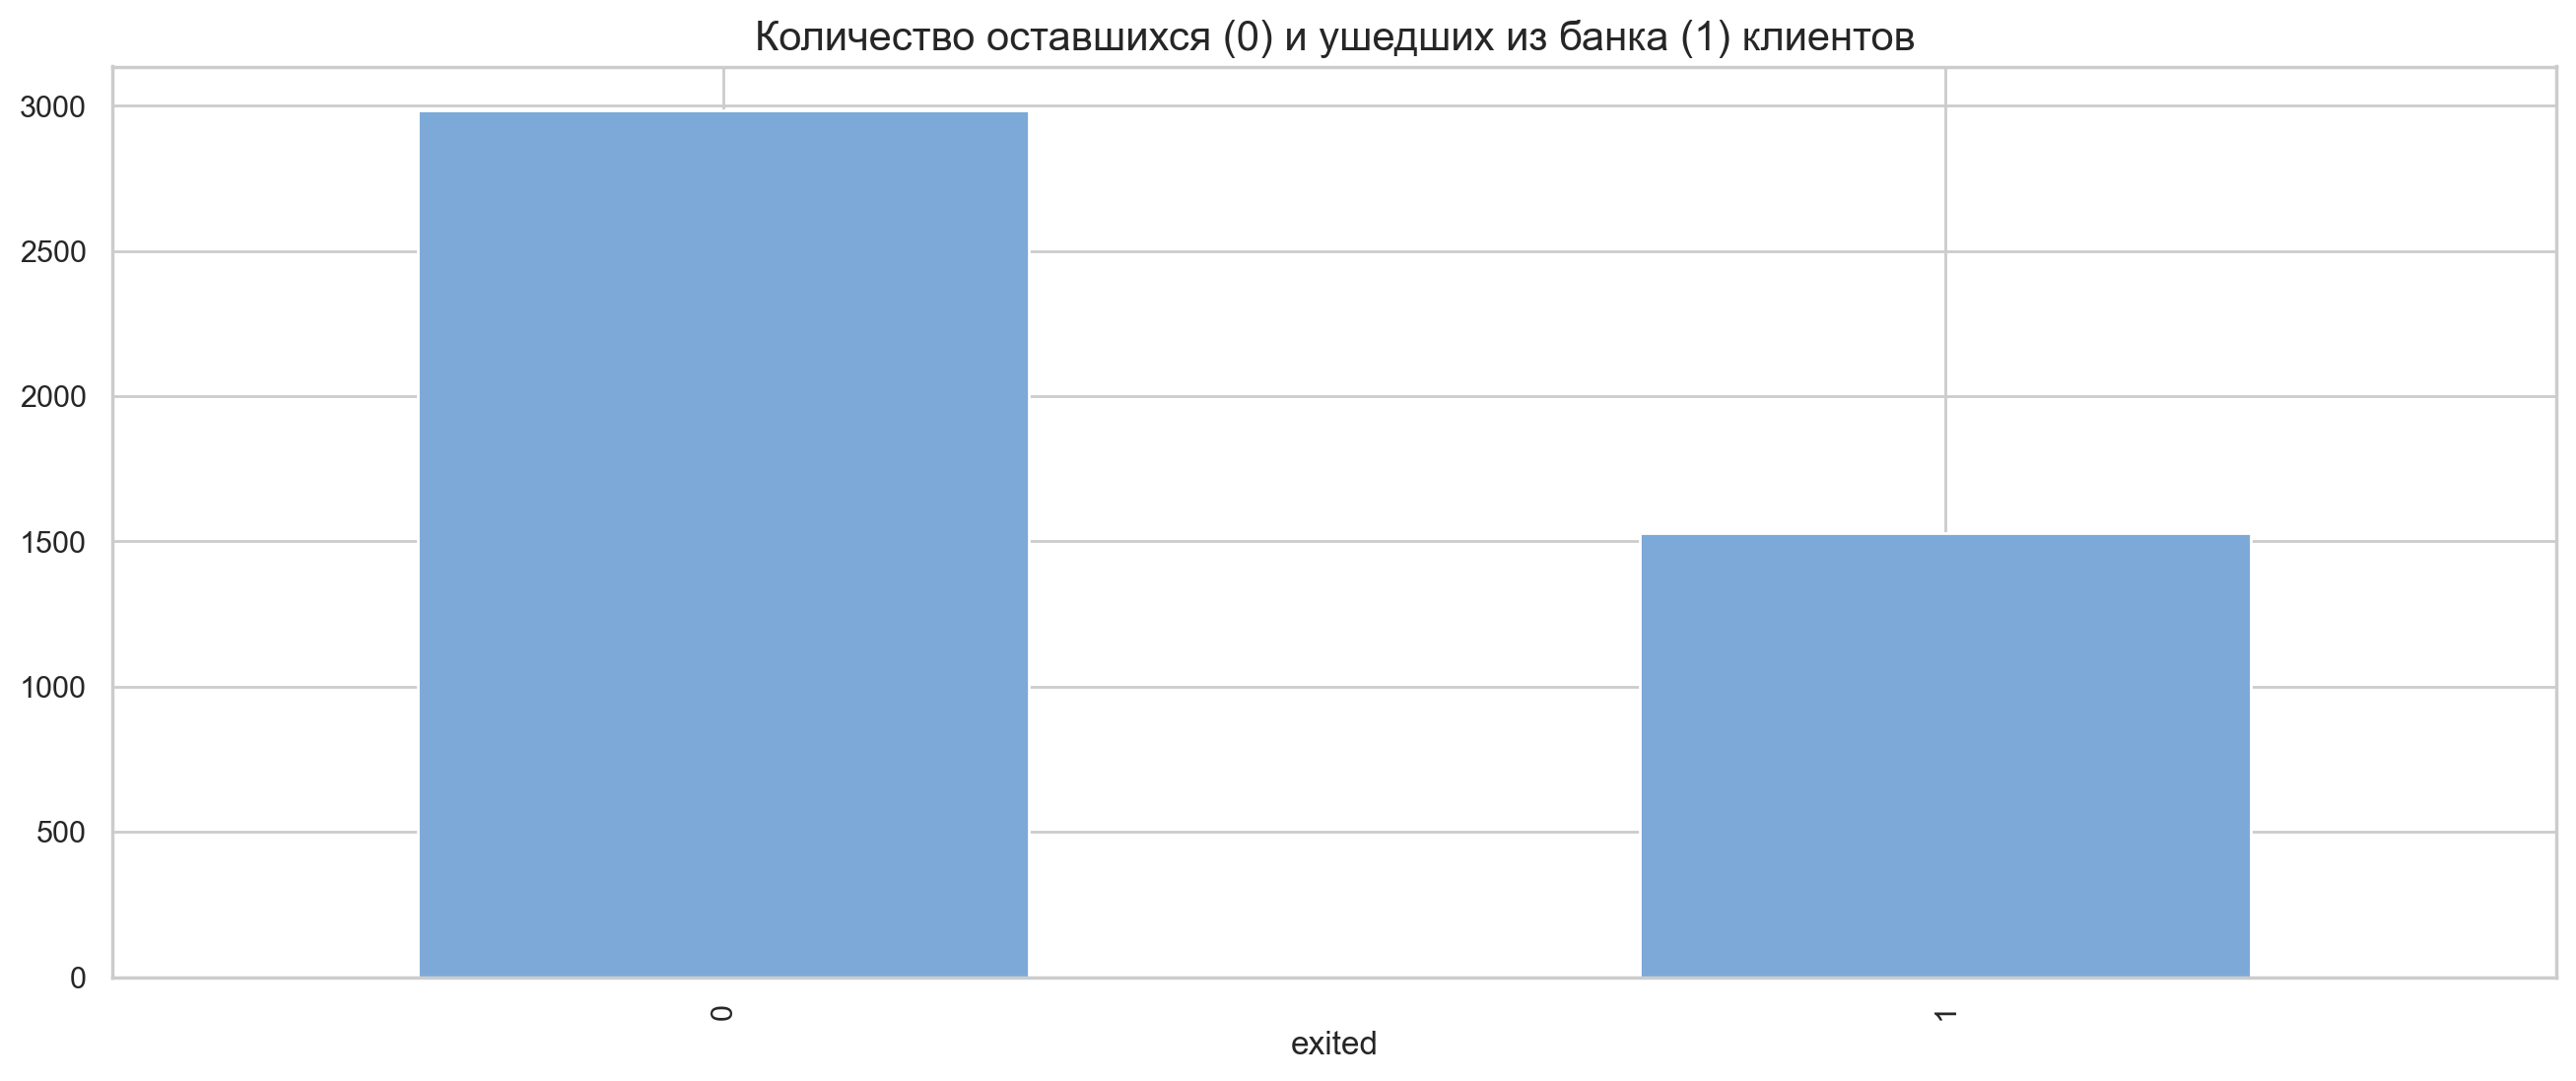

In [58]:
# построим распределение
plt.figure(figsize=(16, 6))
target_downsampled.value_counts().plot(kind='bar', color='#7ca9d8', grid=True)
plt.title("Количество оставшихся (0) и ушедших из банка (1) клиентов", fontsize=15)
plt.show()

In [59]:
# применим make_column_transformer к обучающим данным
features_train_tree_downsampled = col_transformer_tree.fit_transform(features_downsampled)
features_train_tree_downsampled = csc_matrix(features_train_tree_upsampled)
features_train_tree_downsampled = pd.DataFrame.sparse.from_spmatrix(
    features_train_tree_downsampled, 
    columns=col_transformer_tree.get_feature_names_out()
)

features_train_tree_downsampled.head()

,geography,gender,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.56,-0.15,1.82,0.35,0.75,1.23,1.00,0.00
1,0.00,1.00,1.06,0.51,1.09,-1.31,2.28,-0.18,1.00,0.00
2,1.00,1.00,-0.12,0.23,-1.44,0.89,0.75,0.01,0.00,1.00
3,1.00,0.00,-0.12,-0.15,-0.72,0.47,-0.79,-0.22,1.00,1.00
4,0.00,1.00,0.00,-0.15,-0.72,0.52,-0.79,-0.71,1.00,1.00


In [60]:
# переберем различные гиперпараметры DecisionTreeClassifier с помощью Grid Search CV. Найдем лучшие
model_tree = DecisionTreeClassifier(random_state=Random_state)
pipeline_tree = make_pipeline(col_transformer_tree, model_tree)

param_grid_tree = {
    'decisiontreeclassifier__max_depth': [None] + [i for i in range(2, 7)],
    'decisiontreeclassifier__random_state': [Random_state],
}

gs_tree_pl = GridSearchCV (
    pipeline_tree, 
    param_grid_tree, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_tree_pl.fit(features_downsampled, target_downsampled)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_tree_pl.cv_results_)[metrics].iloc[gs_tree_pl.best_index_]
f1_tree_downsampled = results[0]
roc_auc_tree_downsampled = results[1]
best_model_tree = gs_tree_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_tree_downsampled, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_tree_downsampled, 3)}')
print(f'Лучшие параметры: {gs_tree_pl.best_params_}')

Среднее значение F1-меры: 0.641
Среднее значение AUC-ROC: 0.833
Лучшие параметры: {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__random_state': 12345}


In [61]:
# применим make_column_transformer к обучающим данным
features_train_forest_downsampled = col_transformer_forest.fit_transform(features_downsampled)
features_train_forest_downsampled = csc_matrix(features_train_tree_upsampled)
features_train_forest_downsampled = pd.DataFrame.sparse.from_spmatrix(
    features_train_forest_downsampled, 
    columns=col_transformer_forest.get_feature_names_out()
)

features_train_forest_downsampled.head()

,geography,gender,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,1.00,0.00,0.56,-0.15,1.82,0.35,0.75,1.23,1.00,0.00
1,0.00,1.00,1.06,0.51,1.09,-1.31,2.28,-0.18,1.00,0.00
2,1.00,1.00,-0.12,0.23,-1.44,0.89,0.75,0.01,0.00,1.00
3,1.00,0.00,-0.12,-0.15,-0.72,0.47,-0.79,-0.22,1.00,1.00
4,0.00,1.00,0.00,-0.15,-0.72,0.52,-0.79,-0.71,1.00,1.00


In [62]:
# переберем различные гиперпараметры RandomForestClassifier с помощью Grid Search CV. Найдем лучшие
model_forest = RandomForestClassifier(random_state=Random_state)
pipeline_forest = make_pipeline(col_transformer_forest, model_forest)

param_grid_forest = {
    'randomforestclassifier__max_depth': [i for i in range(2, 7)],
    'randomforestclassifier__n_estimators': range(10, 500, 50),
    'randomforestclassifier__random_state': [Random_state],
}

gs_forest_pl = GridSearchCV (
    pipeline_forest, 
    param_grid_forest, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_forest_pl.fit(features_downsampled, target_downsampled)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_forest_pl.cv_results_)[metrics].iloc[gs_forest_pl.best_index_]
f1_forest_downsampled = results[0]
roc_auc_forest_downsampled = results[1]

best_model_forest = gs_forest_pl.best_estimator_

print(f'Среднее значение F1-меры: {round(f1_forest_downsampled, 3)}')
print(f'Среднее значение AUC-ROC: {round(roc_auc_forest_downsampled, 3)}')
print(f'Лучшие параметры: {gs_forest_pl.best_params_}')

Среднее значение F1-меры: 0.632
Среднее значение AUC-ROC: 0.842
Лучшие параметры: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__random_state': 12345}


In [63]:
# применим make_column_transformer к обучающим данным
features_train_logreg_downsampled = col_transformer_logreg.fit_transform(features_downsampled)
features_train_logreg_downsampled = csc_matrix(features_train_logreg_downsampled)
features_train_logreg_downsampled = pd.DataFrame.sparse.from_spmatrix(
    features_train_logreg_downsampled, 
    columns=col_transformer_logreg.get_feature_names_out()
)

features_train_logreg_downsampled.head()

,geography_Germany,geography_Spain,gender_Male,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,0.00,0.00,1.00,-2.08,-0.75,1.11,-1.27,0.77,0.56,0.00,0.00
1,0.00,0.00,0.00,-1.66,-0.56,-1.08,0.28,-0.83,-1.60,0.00,0.00
2,1.00,0.00,1.00,0.19,-0.27,1.84,1.19,0.77,1.02,1.00,1.00
3,0.00,0.00,0.00,-1.49,0.88,0.75,-1.27,2.38,-0.23,0.00,1.00
4,0.00,0.00,0.00,0.81,-0.75,1.48,-1.27,0.77,0.86,0.00,0.00


In [64]:
# переберем различные гиперпараметры  Logistic Regression с помощью GridSearch CV. Найдем лучшие
model_logreg = LogisticRegression(random_state=Random_state)
pipeline_logreg = make_pipeline(col_transformer_logreg, model_logreg)

logreg_params = {
    'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'logisticregression__C': np.logspace(-3, 3, 7),
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__max_iter': [100, 250, 500, 1000],
}


gs_logreg_pl = GridSearchCV (
    pipeline_logreg, 
    logreg_params, 
    scoring=['f1', 'roc_auc'], 
    refit='f1',
    cv=5,
    n_jobs=-1
)

gs_logreg_pl.fit(features_downsampled, target_downsampled)
metrics = [f'mean_test_{x}' for x in ['f1', 'roc_auc']]
results = pd.DataFrame(gs_logreg_pl.cv_results_)[metrics].iloc[gs_logreg_pl.best_index_]
f1_log_downsampled = results[0]
roc_auc_log_downsampled = results[1]
best_model_logreg = gs_logreg_pl.best_estimator_

print(f'Среднее значение F1: {round(f1_log_downsampled, 3)}')
print(f'Среднее значение ROC-AUC: {round(roc_auc_log_downsampled, 3)}')
print(f'Лучшие параметры: {gs_logreg_pl.best_params_}')

Среднее значение F1: 0.547
Среднее значение ROC-AUC: 0.768
Лучшие параметры: {'logisticregression__C': 1.0, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


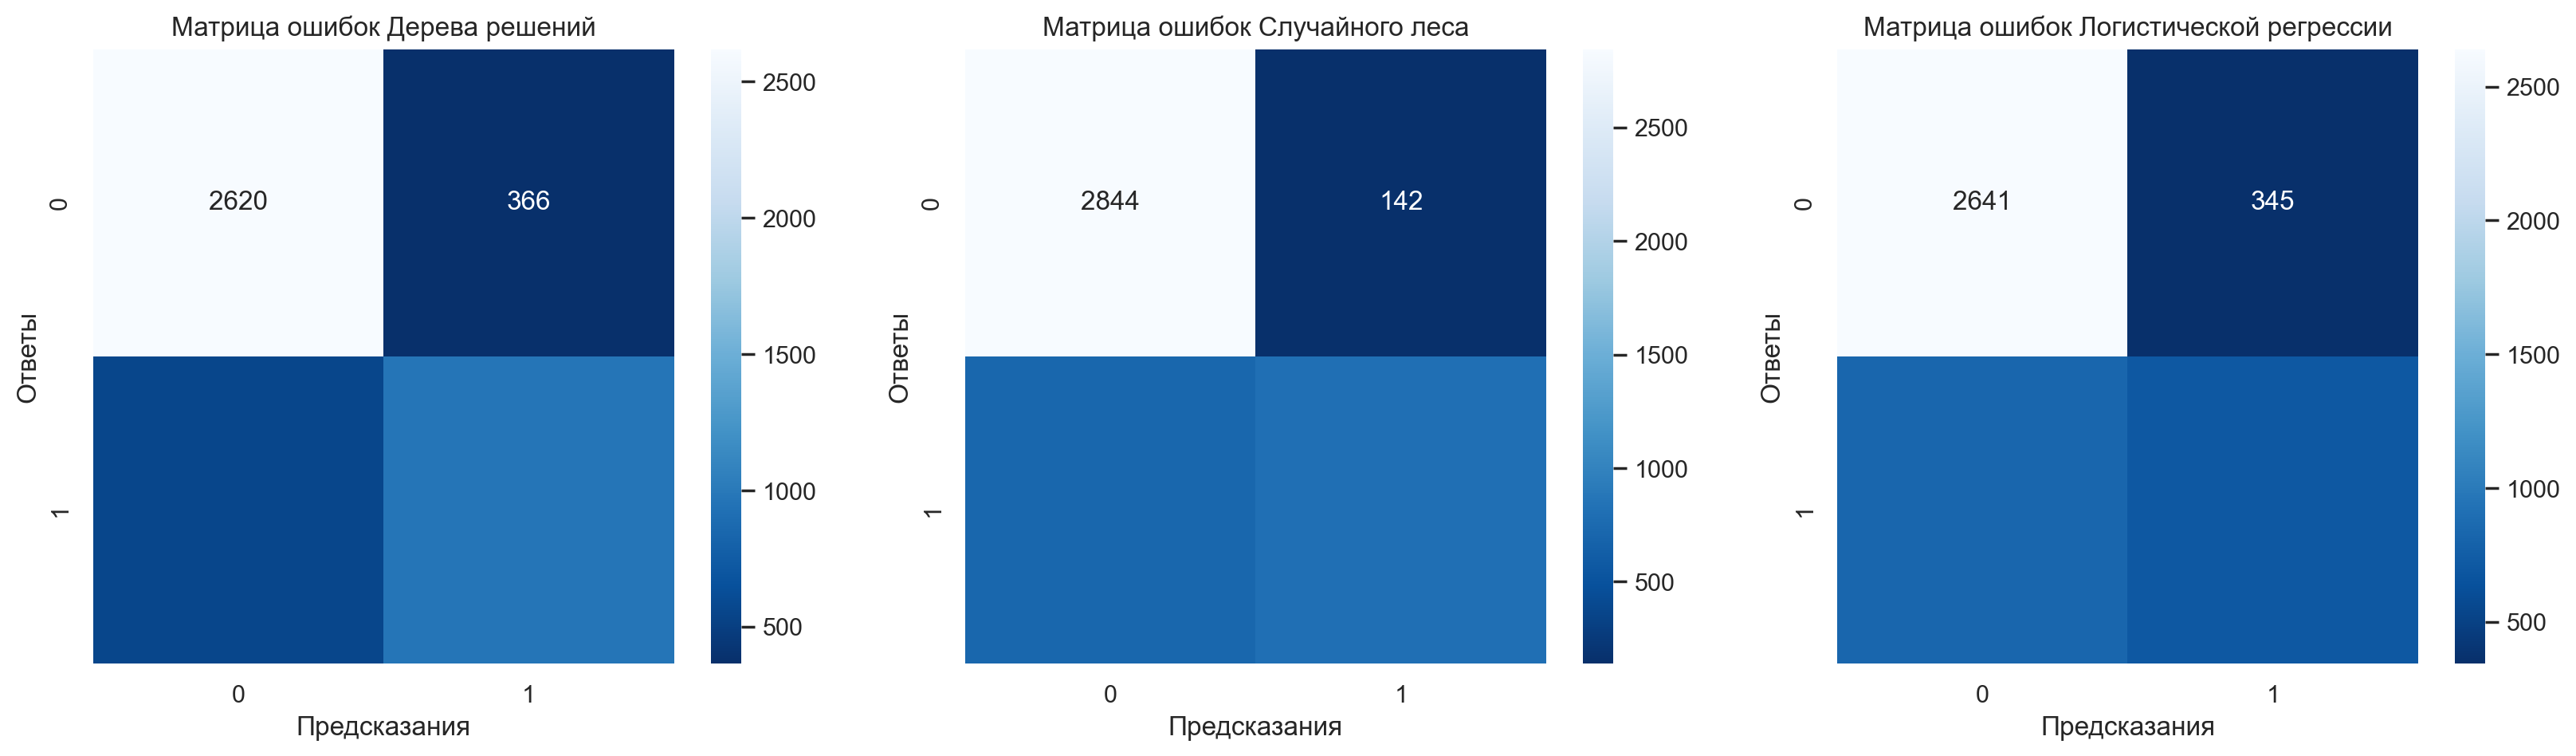

In [65]:
# построим матрицы ошибок
matrix_model(best_model_tree, best_model_forest, best_model_logreg, features_downsampled, target_downsampled)

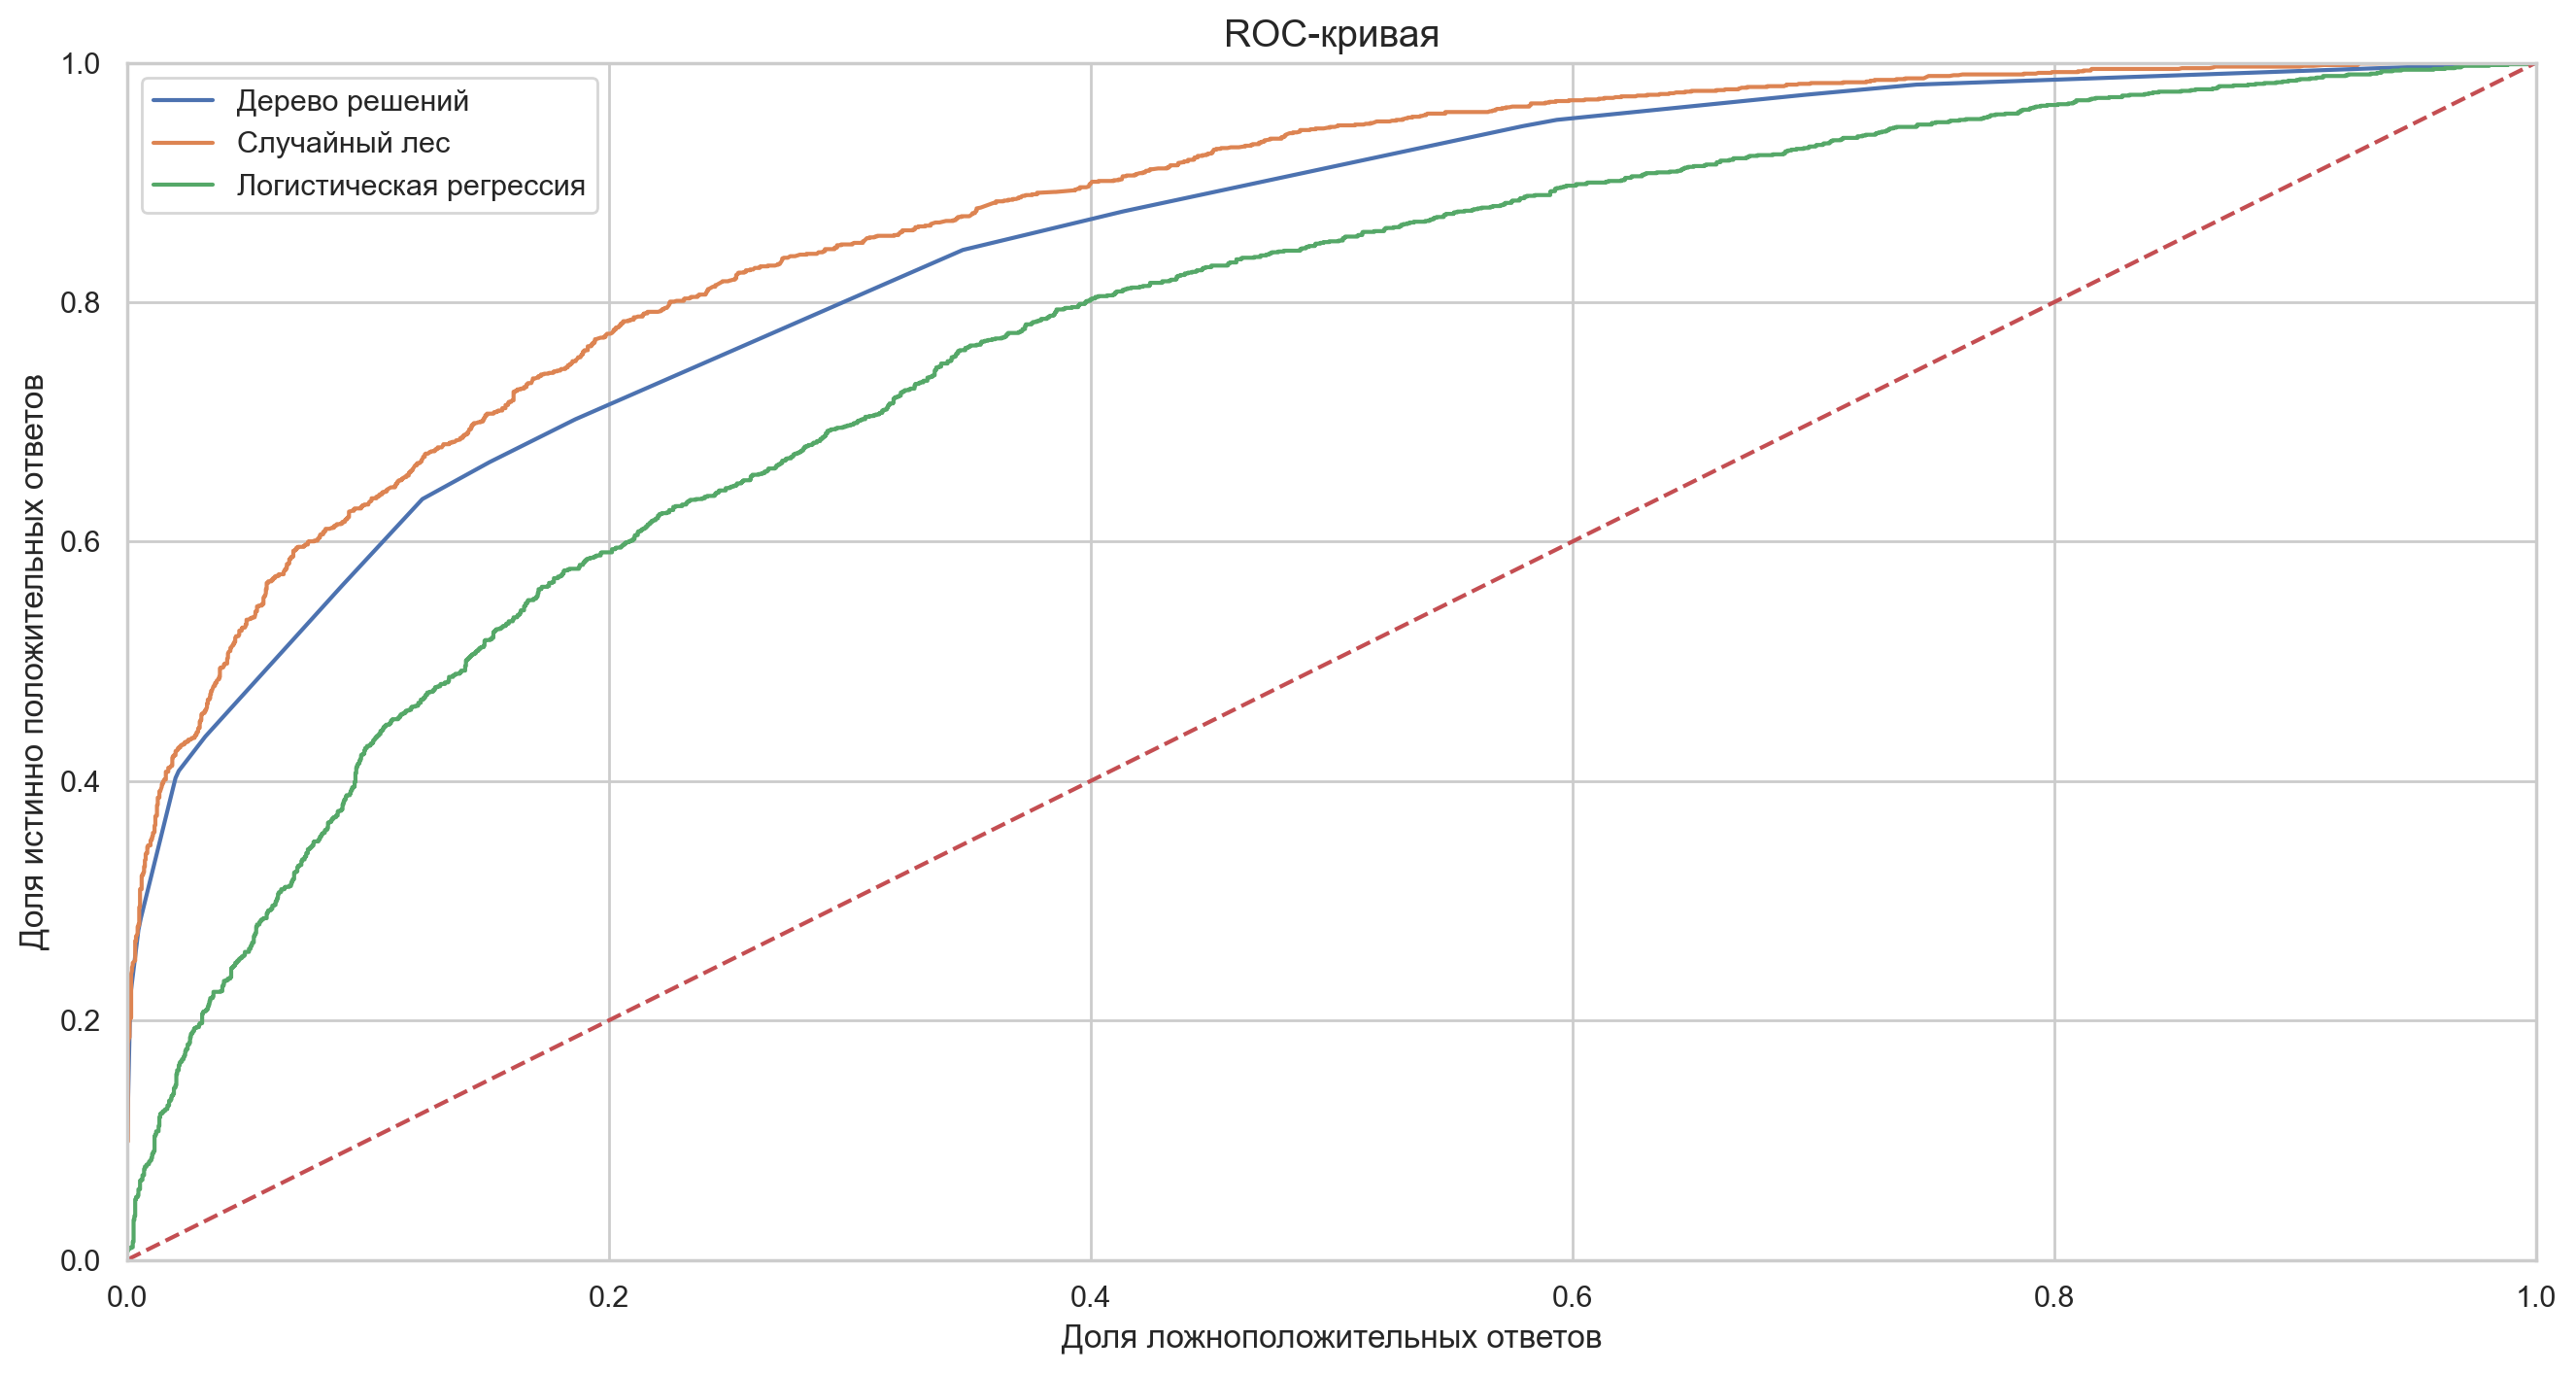

In [66]:
# сравним ROC-кривые
roc_model(best_model_tree, best_model_forest, best_model_logreg, features_downsampled, target_downsampled)

**Вывод:**

- Наилучшее значение метрики F1 = 0.63 также показывает модель Случайного леса с глубиной 6 и количеством деревьев 10. Этот результат слабее по сравнению с предыдущим методом.

In [67]:
#создадим таблицу с показателями F1 и AUC-ROC
index = ['Decision Tree с дисбалансом классов',
         'Decision Tree с взвешиванием классов',
         'Decision Tree с увеличением выборки',
         'Decision Tree с уменьшением выборки',
         'Random Forest с дисбалансом классов',
         'Random Forest с взвешиванием классов',
         'Random Forest с увеличением выборки',
         'Random Forest с уменьшением выборки',
         'Logistic Regression с дисбалансом классов',
         'Logistic Regression с взвешиванием классов',
         'Logistic Regression с увеличением выборки',
         'Logistic Regression с уменьшением выборки',
        ]

metrics = {'F1':[round(f1_tree, 2),
                round(f1_tree_balanced, 2),
                round(f1_tree_upsampled, 2),
                round(f1_tree_downsampled, 2),
                round(f1_forest, 2),
                round(f1_forest_balanced, 2),
                round(f1_forest_upsampled, 2),
                round(f1_forest_downsampled, 2),
                round(f1_logreg, 2),
                round(f1_log_balanced, 2),
                round(f1_log_upsampled, 2),
                round(f1_log_downsampled, 2),],
        
        'AUC-ROC':[round(roc_auc_tree, 2),
                round(roc_auc_tree_balanced, 2),
                round(roc_auc_tree_upsampled, 2),
                round(roc_auc_tree_downsampled, 2),
                round(roc_auc_forest, 2),
                round(roc_auc_forest_balanced, 2),
                round(roc_auc_forest_upsampled, 2),
                round(roc_auc_forest_downsampled, 2),
                round(roc_auc_logreg, 2),
                round(roc_auc_log_balanced, 2),
                round(roc_auc_log_upsampled, 2),
                round(roc_auc_log_downsampled, 2),]
       }

metrics_data = pd.DataFrame(data=metrics, index=index)
metrics_data.sort_values(by=['F1', 'AUC-ROC'], ascending=False)

,F1,AUC-ROC
Random Forest с увеличением выборки,0.73,0.87
Decision Tree с увеличением выборки,0.71,0.85
Decision Tree с уменьшением выборки,0.64,0.83
Logistic Regression с увеличением выборки,0.64,0.73
Random Forest с уменьшением выборки,0.63,0.84
Random Forest с взвешиванием классов,0.59,0.85
Random Forest с дисбалансом классов,0.56,0.84
Decision Tree с взвешиванием классов,0.56,0.83
Logistic Regression с уменьшением выборки,0.55,0.77
Decision Tree с дисбалансом классов,0.54,0.83


1. По результатам исследования видим, что лучшее значение F1-меры (0.73) у модели Случайного Леса с количеством деревьев 210 и глубиной 6 с применением техники увеличения выборки. 


2. Данная модель хорошо справляется как с распознанием положительного класса (клиент ушел их банка), так и с распознанием нулевого класса (клиент остался в банке).


3. Проверим данную модель на тестовой выборке.

## Тестирование модели

Протестируем модель Random Forest с увеличением выборки с количеством деревьев 360 и глубиной None.

In [68]:
# трансформируем тестовую выборку
features_test_forest = col_transformer_forest.transform(features_test)

# конвертируем разреженную матрицу в формат "sparse" по умолчанию для pandas
features_test_forest = csc_matrix(features_test_forest)

# создаём DataFrame с помощью метода pd.DataFrame.sparse.from_spmatrix()
features_test_forest = pd.DataFrame.sparse.from_spmatrix(
    features_test_forest, 
    columns=col_transformer_forest.get_feature_names_out()
)

# выводим первые несколько строк
features_test_forest.head()

,geography,gender,credit_score,age,tenure,balance,num_of_products,estimated_salary,has_cr_card,is_active_member
0,0.00,0.00,-0.57,-0.85,-1.81,0.01,-0.83,-0.40,1.00,0.00
1,0.00,1.00,0.65,1.27,0.38,0.58,-0.83,1.57,0.00,0.00
2,2.00,0.00,1.37,0.21,-1.08,0.49,0.77,-1.65,1.00,0.00
3,0.00,0.00,-2.09,-0.65,0.75,-1.27,0.77,0.37,1.00,0.00
4,1.00,1.00,0.29,-0.75,-0.35,0.98,-0.83,0.30,1.00,1.00


In [69]:
# обучим модель и проверим ее на тестовой выборке
model = RandomForestClassifier(random_state=Random_state, n_estimators=210, max_depth=6)
model.fit(features_train_forest_upsampled, target_upsampled)
predictions_test = model.predict(features_test_forest)
f1 = f1_score(target_test, predictions_test)
recall = recall_score(target_test, predictions_test)
roc_auc = roc_auc_score(target_test, predictions_test)
print('F1-мера с увеличением выборки:', f1)
print('Полнота с увеличением выборки:', recall)
print('AUC-ROC с увеличением выборки:', roc_auc)

F1-мера с увеличением выборки: 0.6212914485165794
Полнота с увеличением выборки: 0.6994106090373281
AUC-ROC с увеличением выборки: 0.7791377505256958


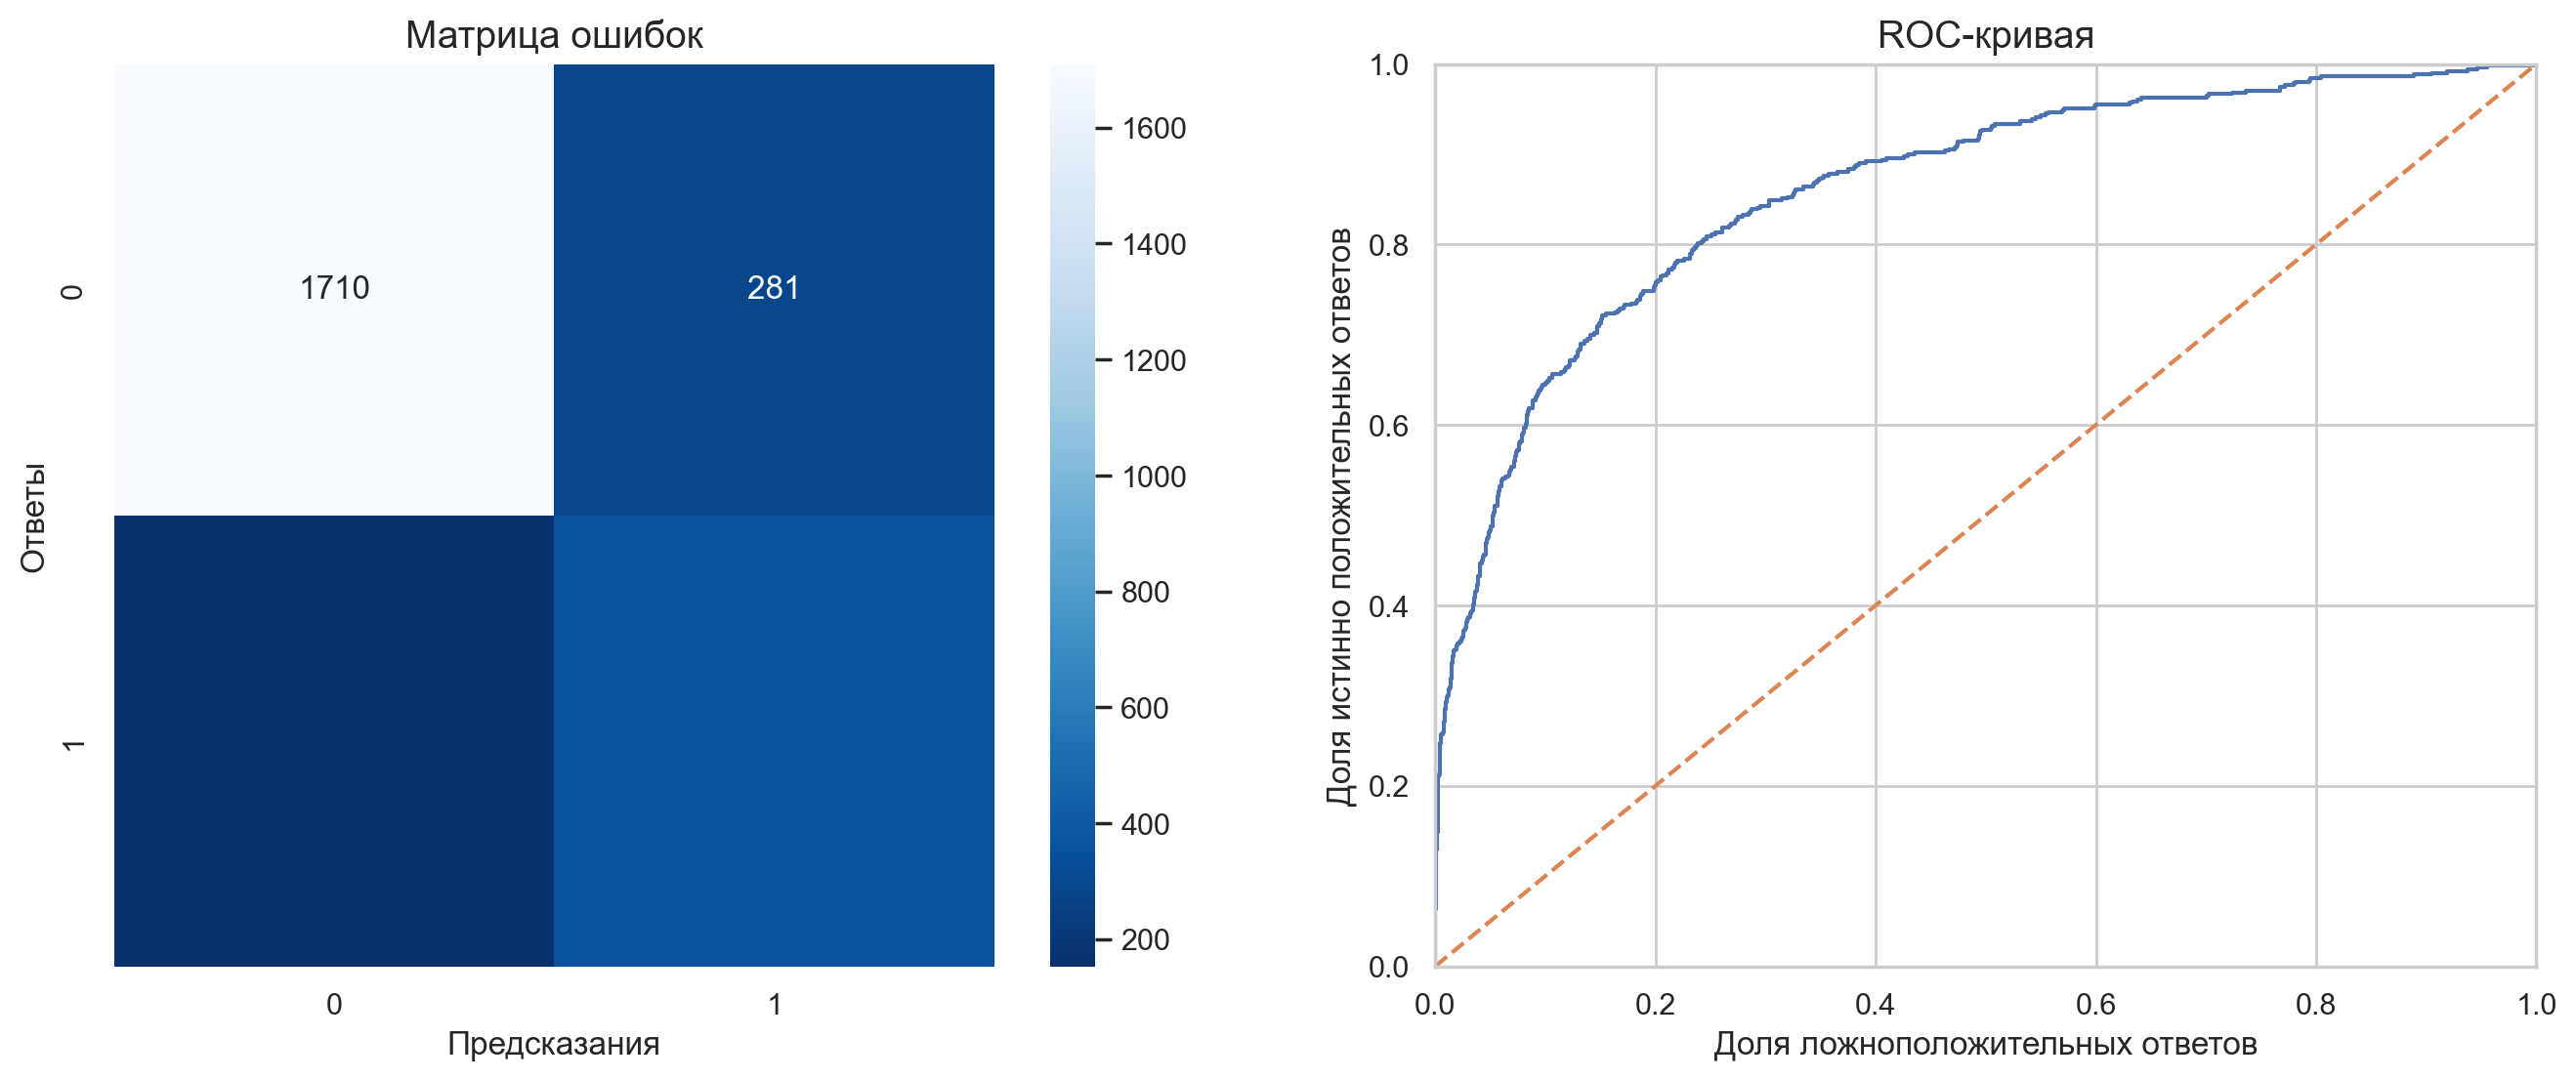

In [70]:
# построим матрицу ошибок и ROC-кривую
matrix = confusion_matrix(target_test, predictions_test)

plt.figure(figsize=(16, 6))
    
plt.subplot(1, 2, 1)
sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues_r")
plt.title('Матрица ошибок', fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)

plt.subplot(1, 2, 2)
probabilities_valid = model.predict_proba(features_test_forest)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("Доля ложноположительных ответов", fontsize=12) 
plt.ylabel("Доля истинно положительных ответов", fontsize=12)
plt.title("ROC-кривая", fontsize=14)

plt.show()

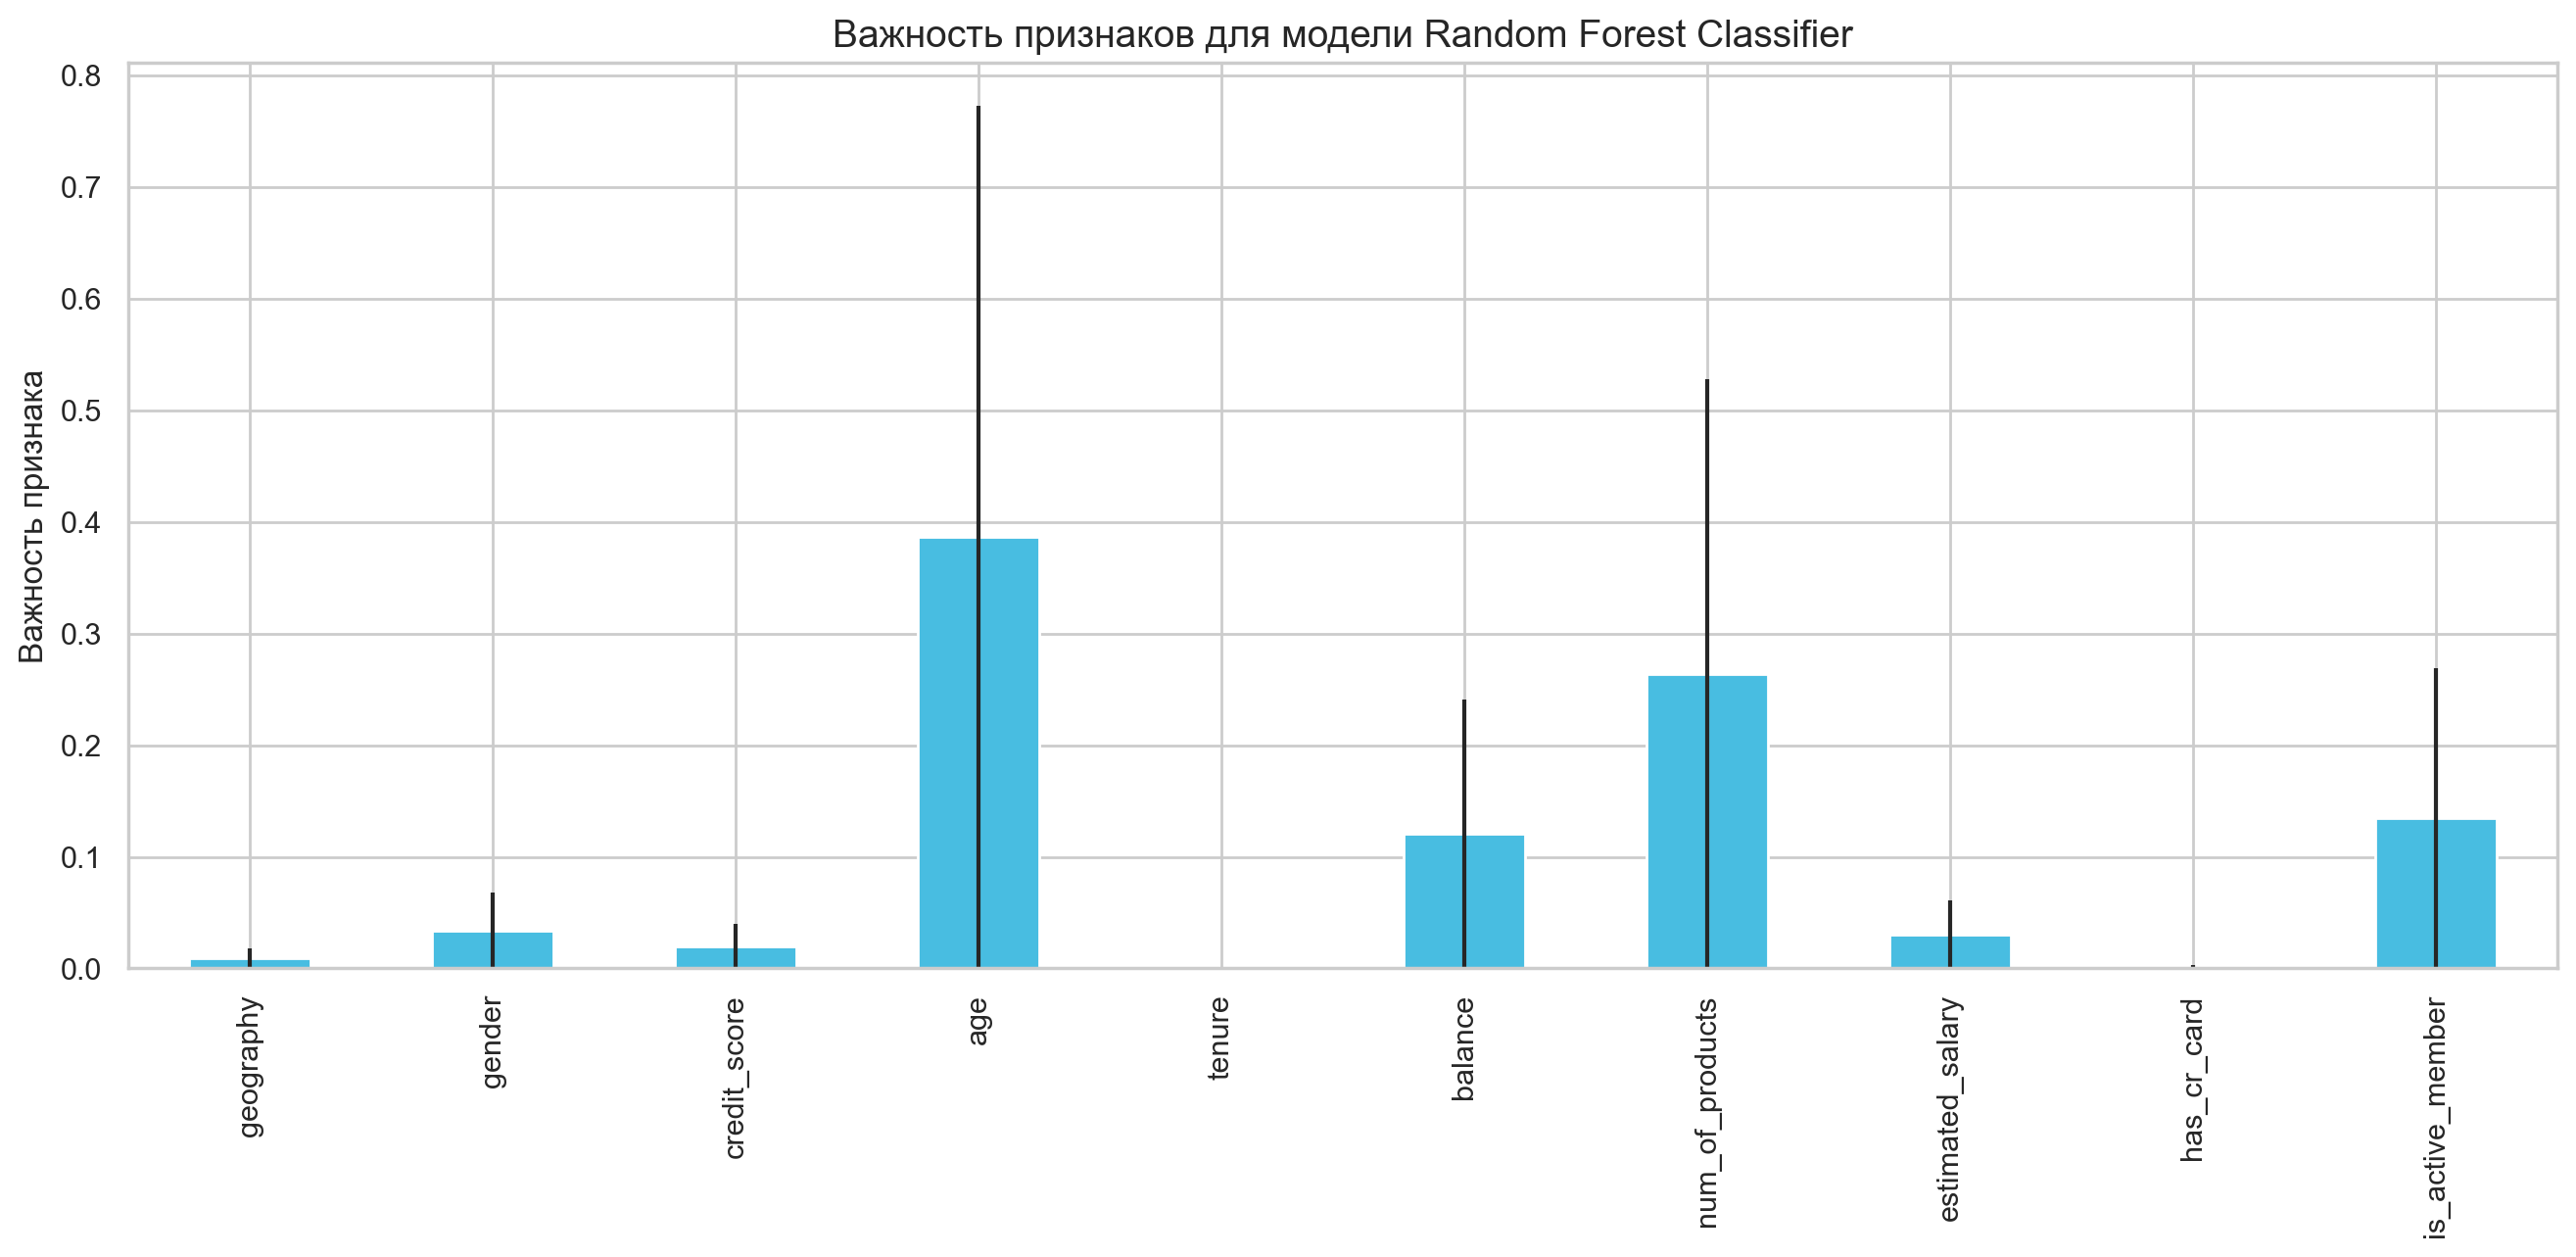

In [71]:
# построим график важности признаков
coef_forest = model[1].feature_importances_
forest_importances = pd.Series(coef_forest, index=features_train_forest.columns)
feature_importance(forest_importances, forest_importances, name='Random Forest Classifier')

### Вывод по этапу "Тестирование модели": 

1. На тестовой выборке все три модели показывают близкие результаты F1-меры = 0.63, что является хорошим результатом.


2. AUC-ROC лучшей модели = 0.78, что выше значения AUC-ROC константной модели (0.5). Полученную модель можно считать адекватной.

## Общий вывод

Цель настоящего исследования - построить модель, способную спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В нашем распоряжении были исторические данные о поведении клиентов и расторжении договоров с банком. 

<br>

1. Перед началом исследования данные были подготовлены:
    - удалены признаки, которые не несут ценности для обучения модели,
    - обработаны пропущенные значения,
    - исходный датафрейм был разделён на две выборки: обучающую (75%) и тестовую (25%).

<br>

2. В исследовании участвовали три различные алгоритма классификации: Дерево решений (Decision Tree), Случайный лес (Random Forest) и Логистическая регрессия (Logistic Regression). У каждой модели менялись гиперпараметры, чтобы добиться наиболее высокой оценки качества. 


Итоговый список признаков для обучения моделей:
- `geography` - страна проживания,
- `gender` - пол,
- `credit_score` - кредитный рейтинг,
- `age` - возраст,
- `tenure` - сколько лет человек является клиентом банка,
- `balance` - баланс на счете,	
- `num_of_products` - количество продуктов банка, используемых клиентом,
- `estimated_salary` - предполагаемая зарплата,
- `has_cr_card` - наличие кредитной карты,
- `is_active_member` - активность клиента.

Целевой признак:
- `exited` - факт ухода клиента из банка.


Перед началом обучения:
- для Logistic Regression количественные признаки были масштабированы, а категориальные закодированы методом прямого кодирования (One-Hot Encoding) с использованием pipeline,
- для Random Forest и Decision Tree количественные признаки были масштабированы, а категориальные закодированы методом OrdinalEncoder с использованием pipeline.

<br>

3. Обучение моделей проводилось как на несбалансированных исходных данных, так и с применением методов борьбы с дисбалансом:
    - взвешивание классов, 
    - увеличение выборки (Upsampling),
    - уменьшение выборки (Downsampling).

<br>

4. По итогам исследования был сделан вывод, что для прогнозирования ухода клиента из банка наиболее подходящей моделью является модель, построенная на **алгоритме Случайного леса (Random Forest) с количеством деревьев 210 и максимальной глубиной дерева 6**. Такой результат был достигнут с применением **метода увеличения выборки (Upsampling)**.

<br>

Модель верно предсказывает положительный класс примерно в 50% случаев. Наибольший вклад в обучение модели вносят признаки: возраст клиента, количество продуктов, активность пользователя и баланс на счете.

5. Итоговое значение качества модели F1-мера на тестовой выборке составляет 0.63. Модель характеризуется высоким показателем полноты = 0.67 (min = 0, max = 1), поэтому она с высокой вероятностью предскажет уход клиента из банка. С точки зрения бизнеса полученная модель поможет маркетологам лучше определять килентов, которые могут уйти в ближайшее время. Для улучшения модели следует использовать данные, отражающие отношения клиента с банком в динамике.